In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

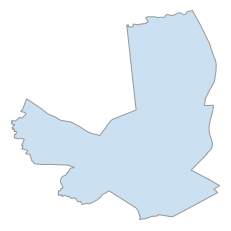

{'init': 'epsg:4326'}


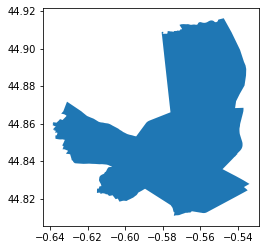

time: 304 ms


In [2]:
city = ox.gdf_from_place('Bordeaux, France')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

6236
data max index: 6235
number of NA prices: 0
average bedroom price 58.75952763373258
pointinpoly length: 6190
check contains: True
check if there are NAs: False


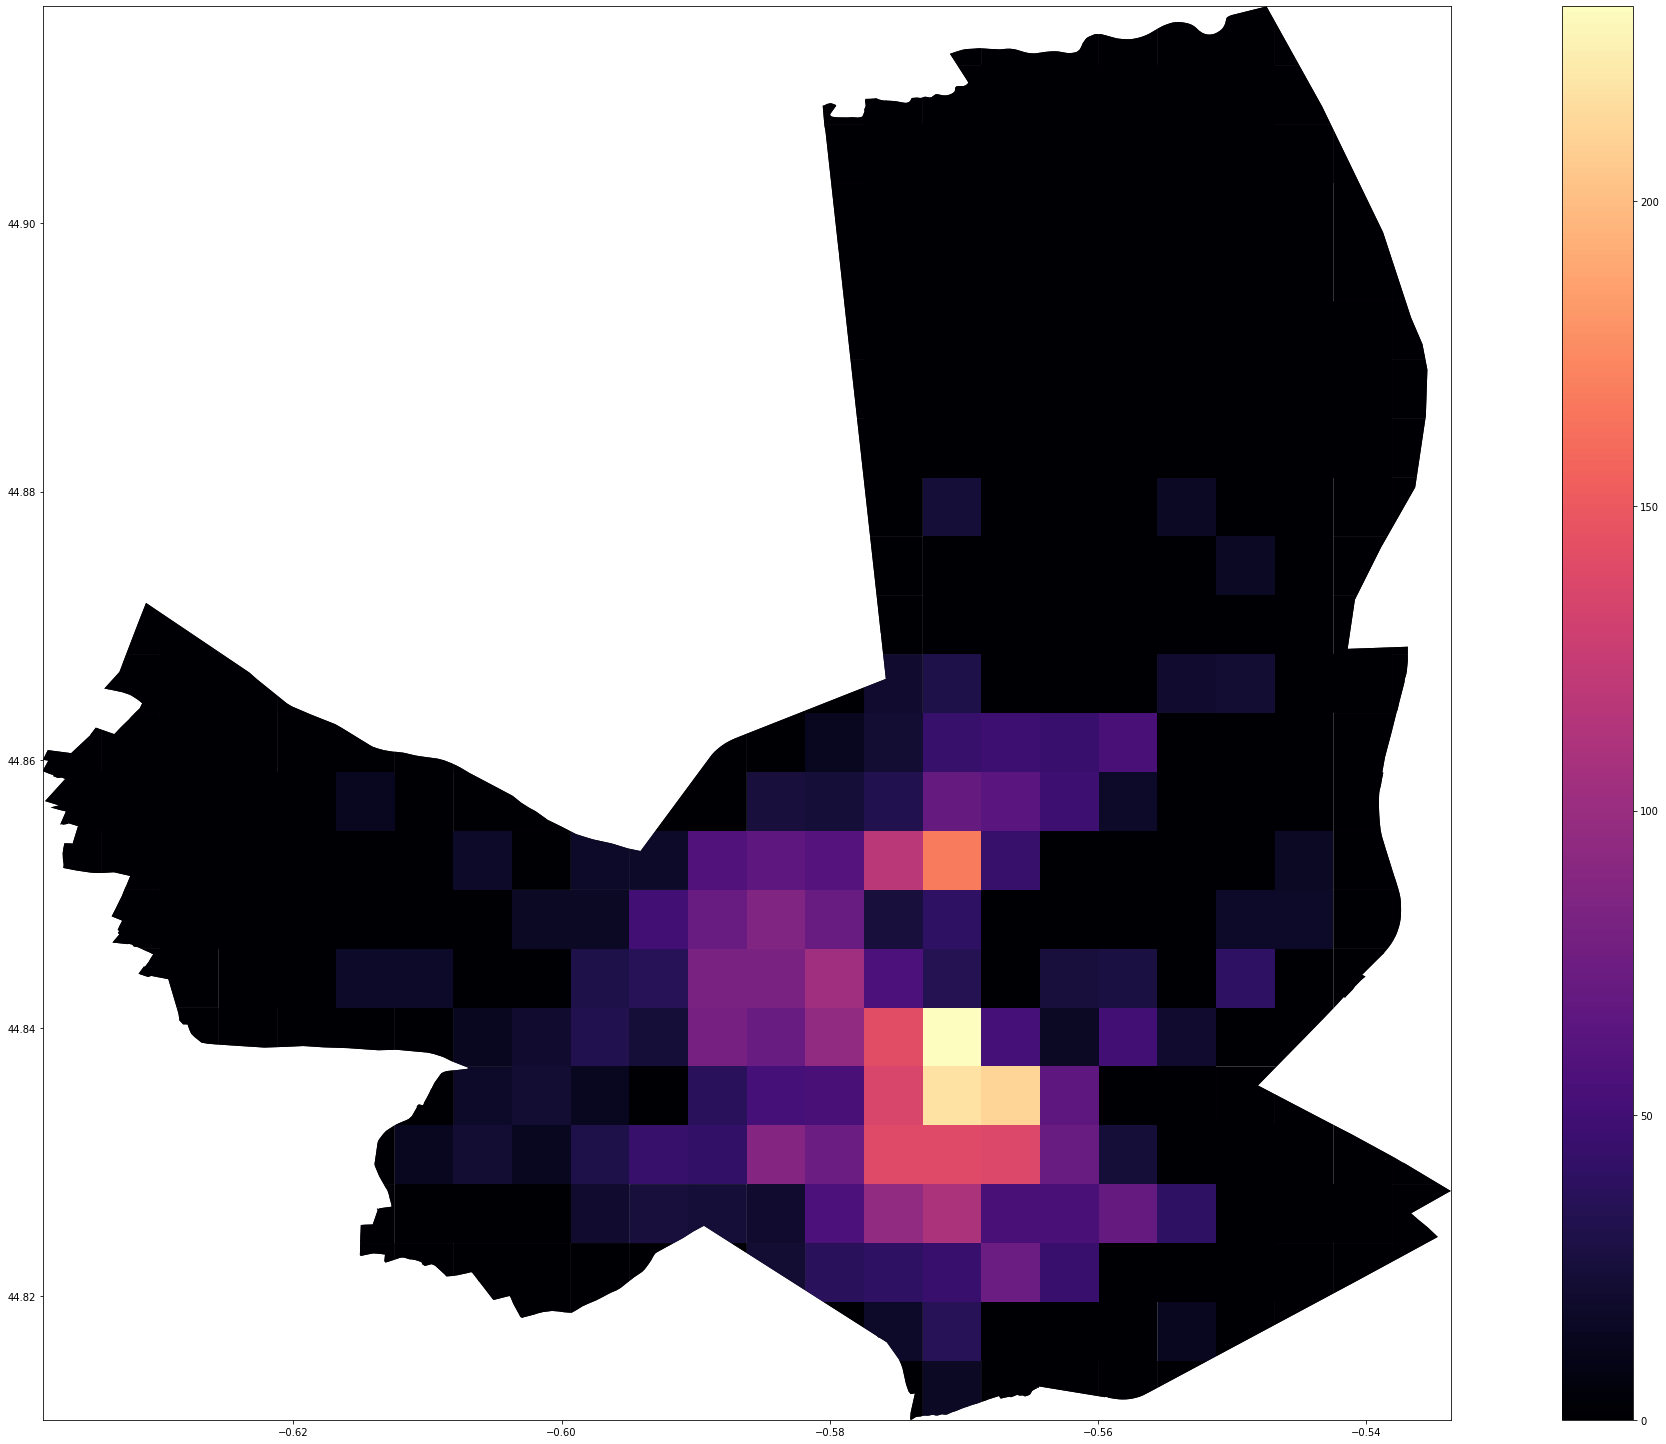

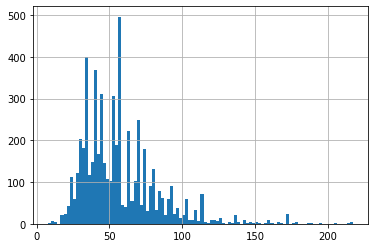

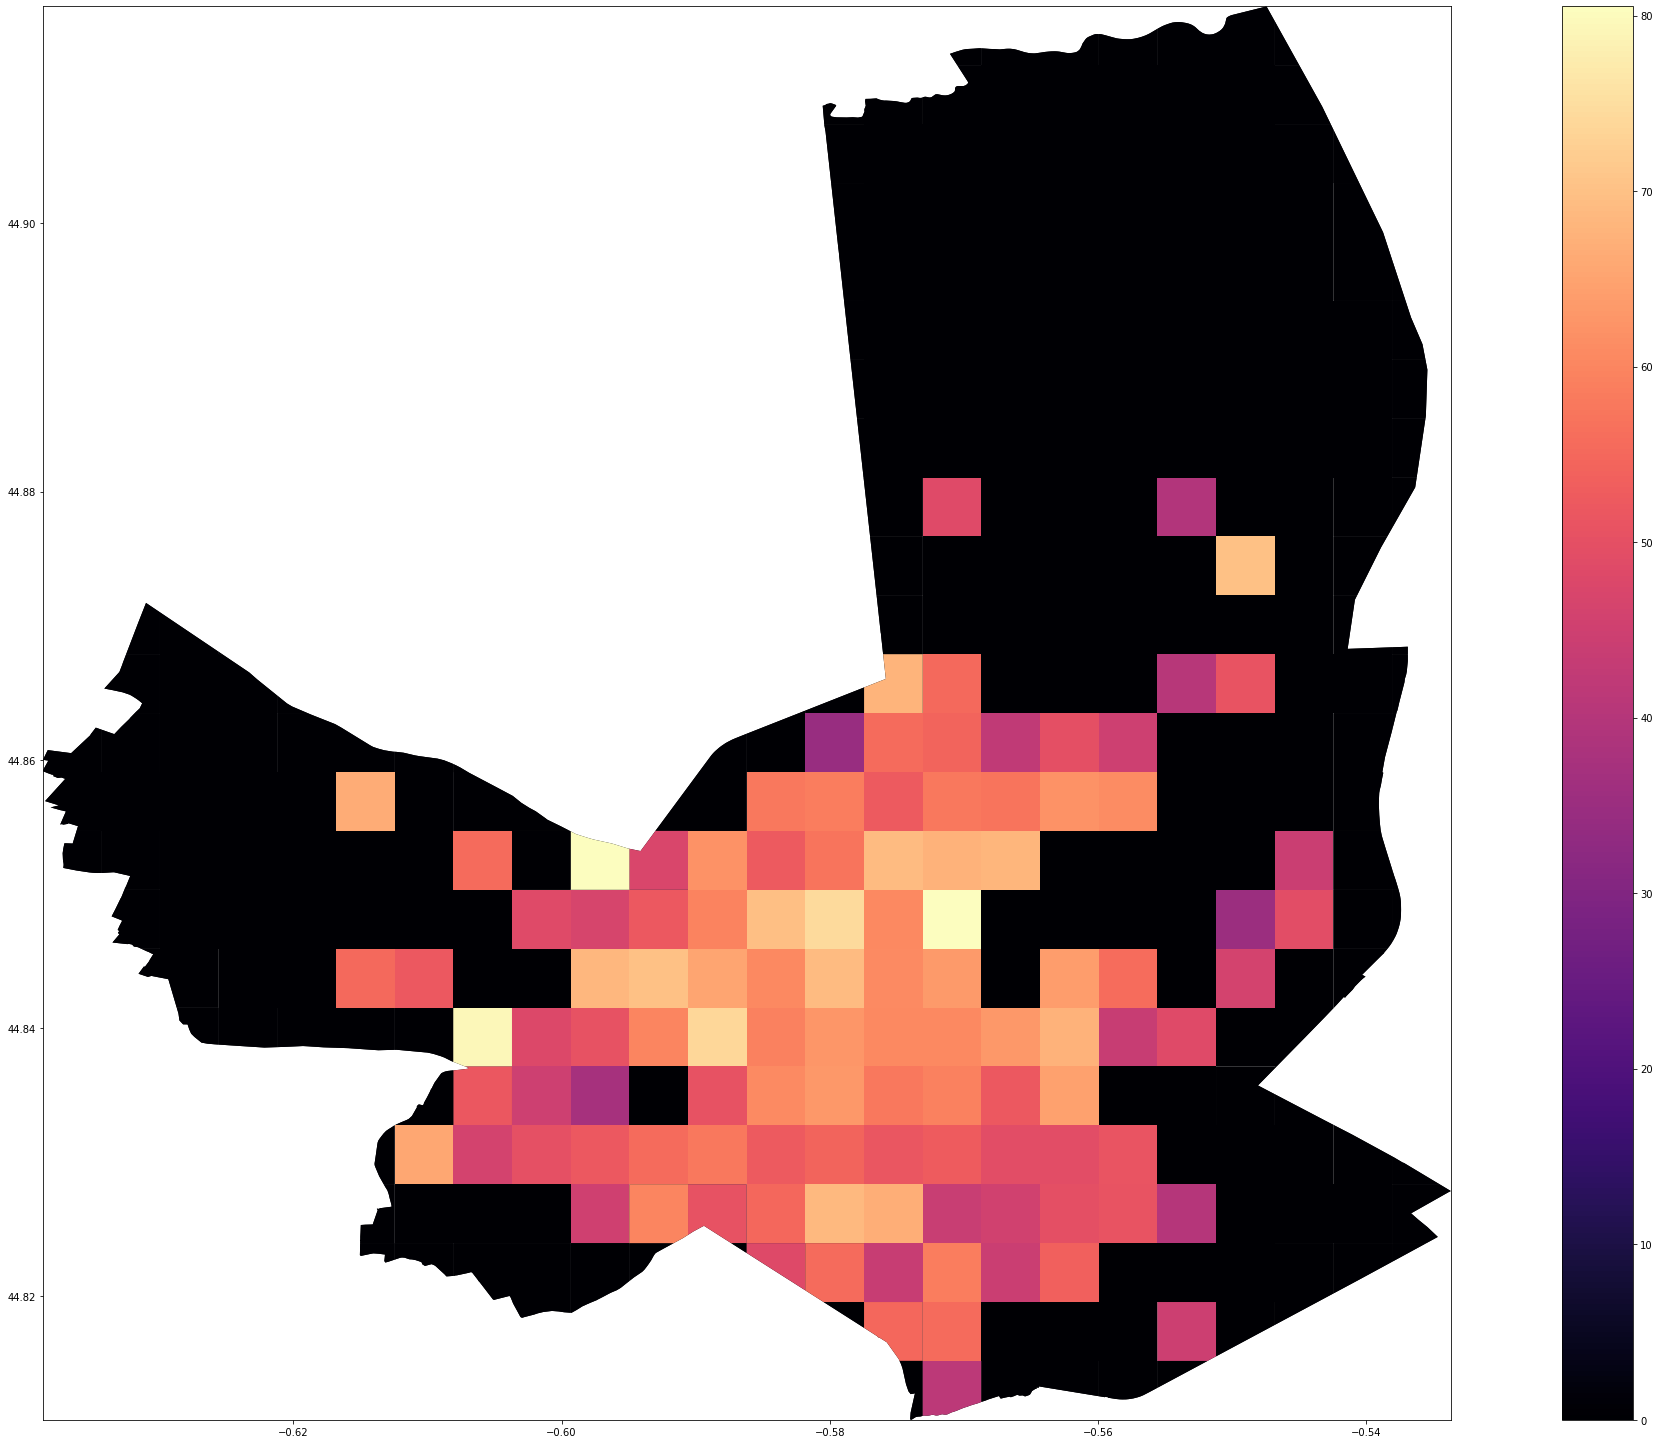

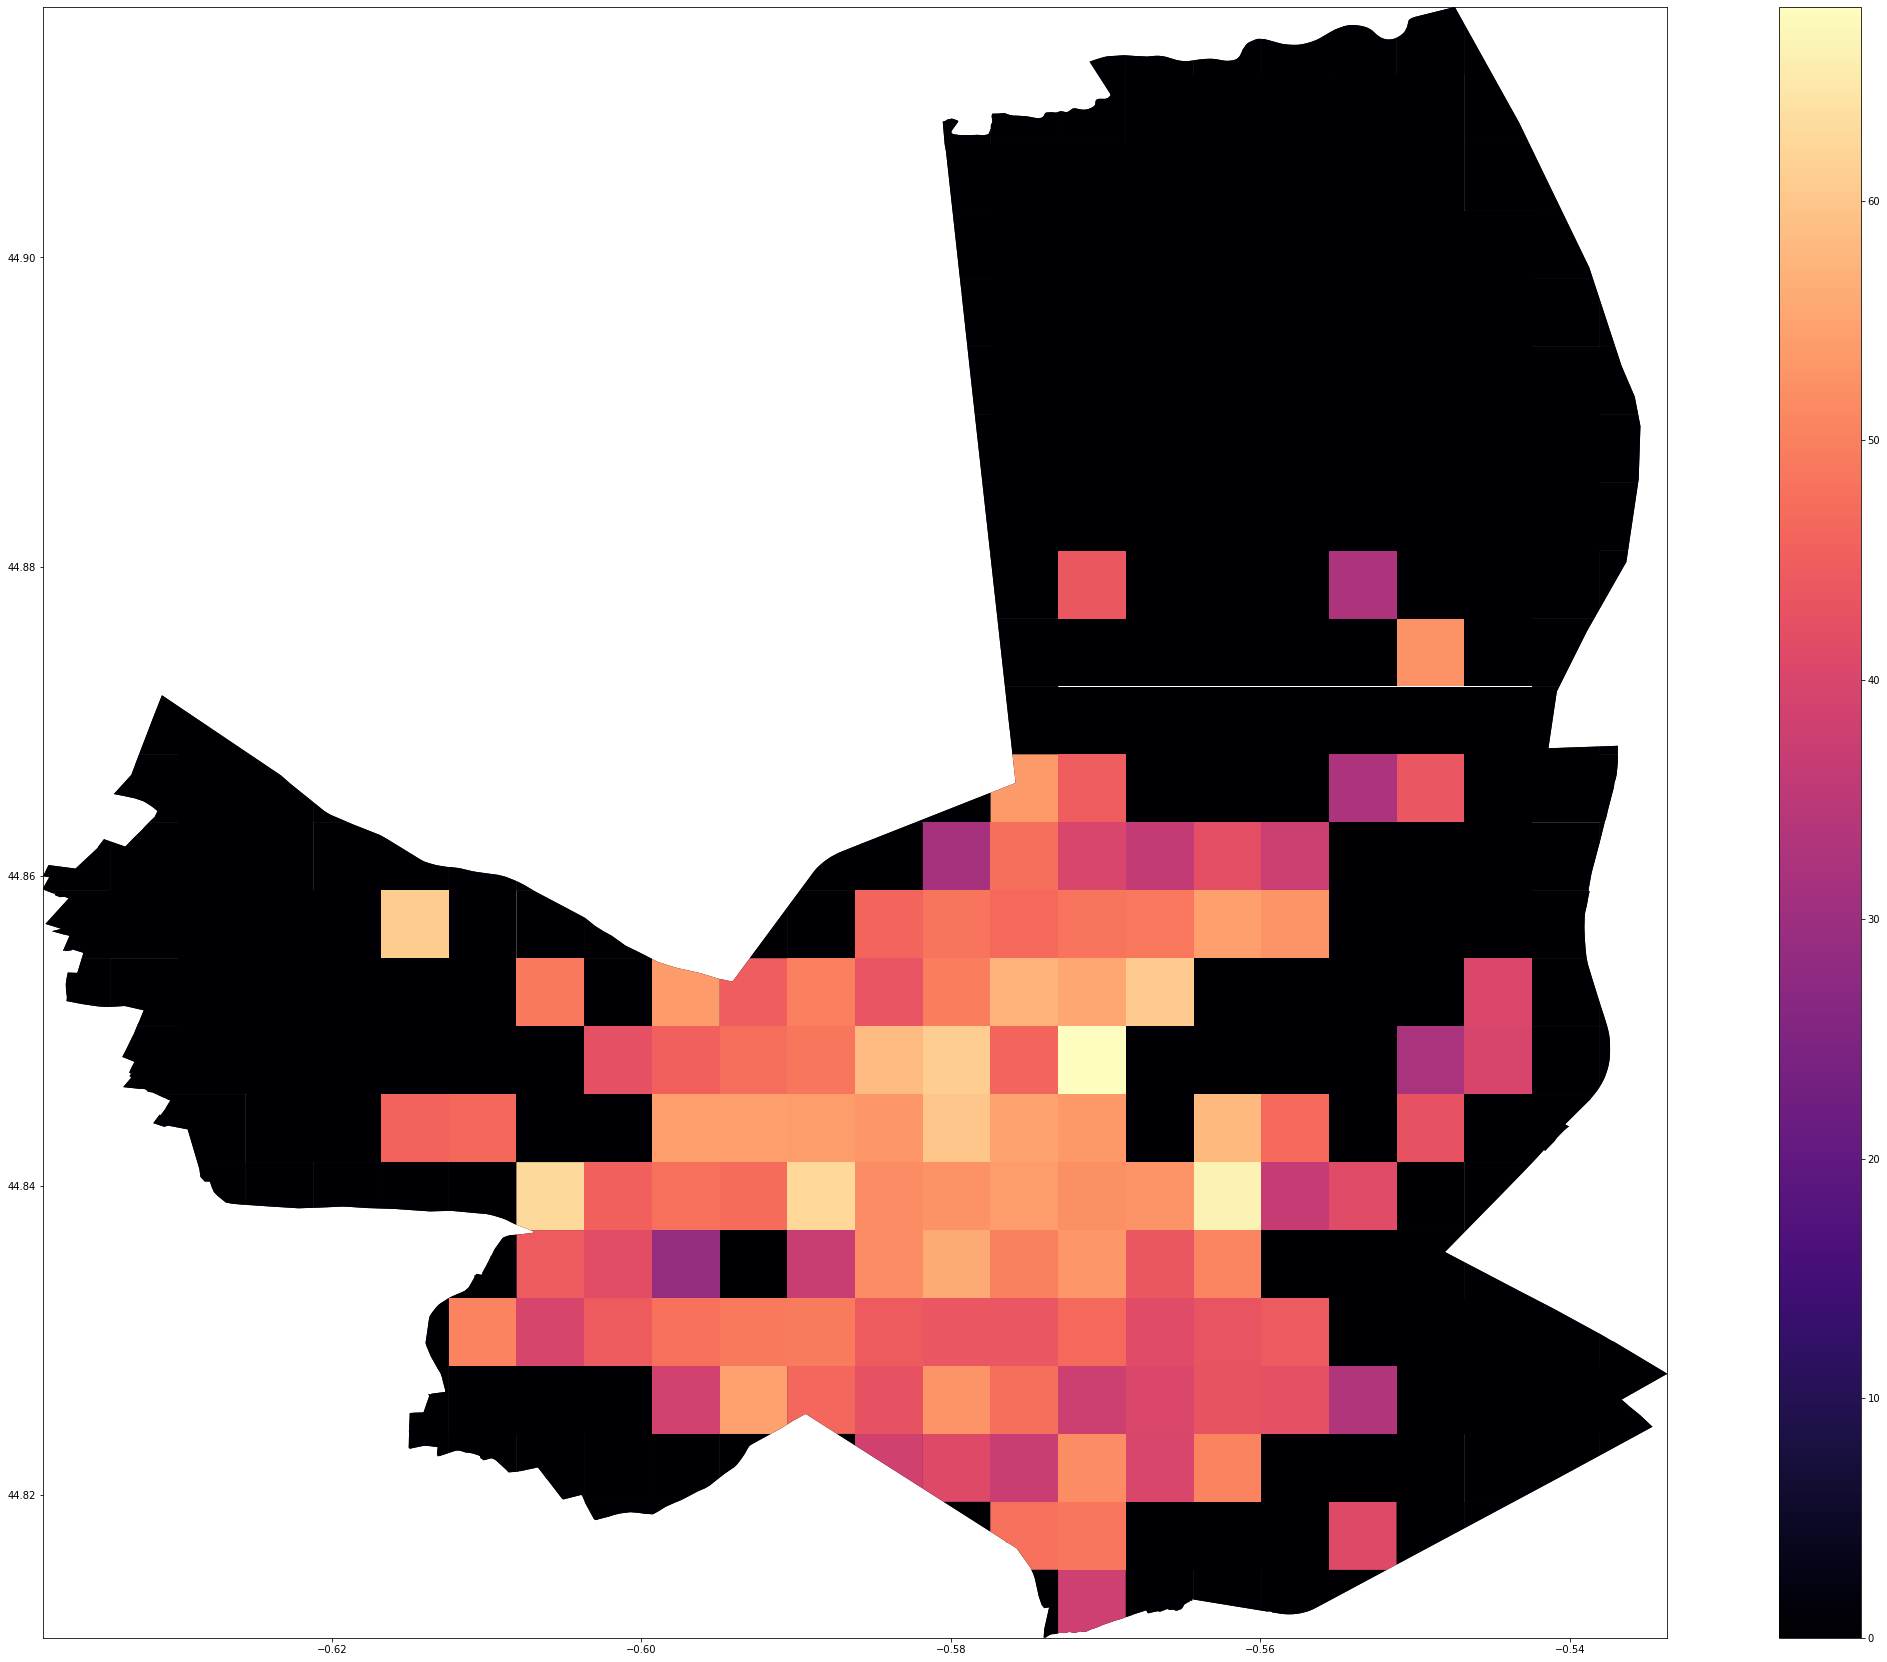

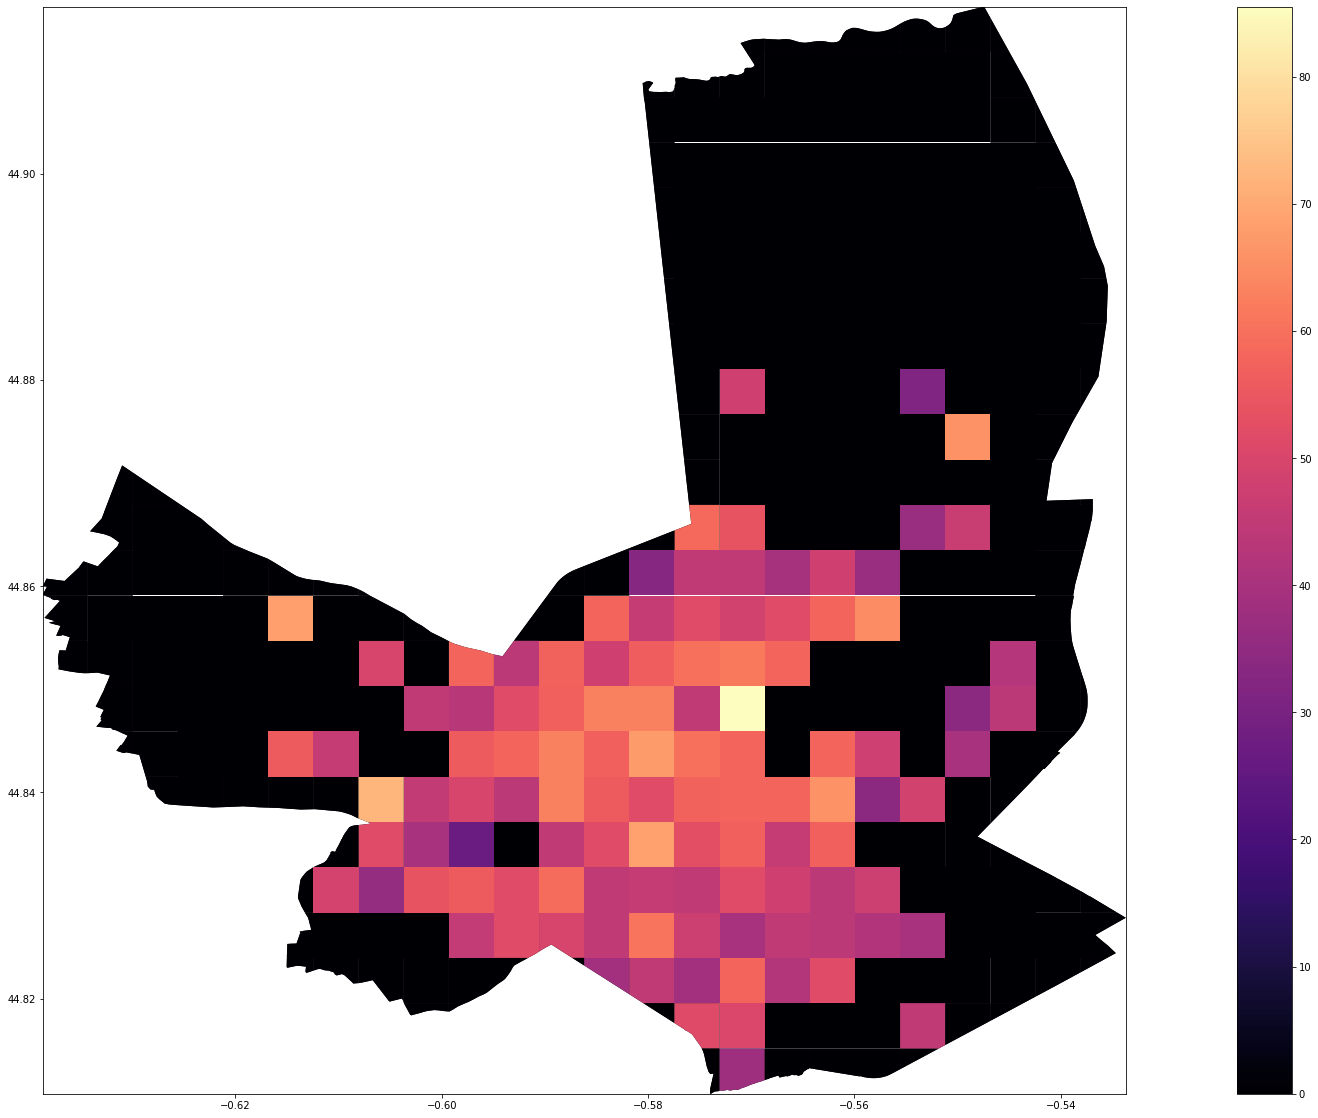

time: 4.08 s


In [3]:
data = pd.read_csv('data/Airbnb_Bordeaux.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]
# plot the city

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>12]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<225]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


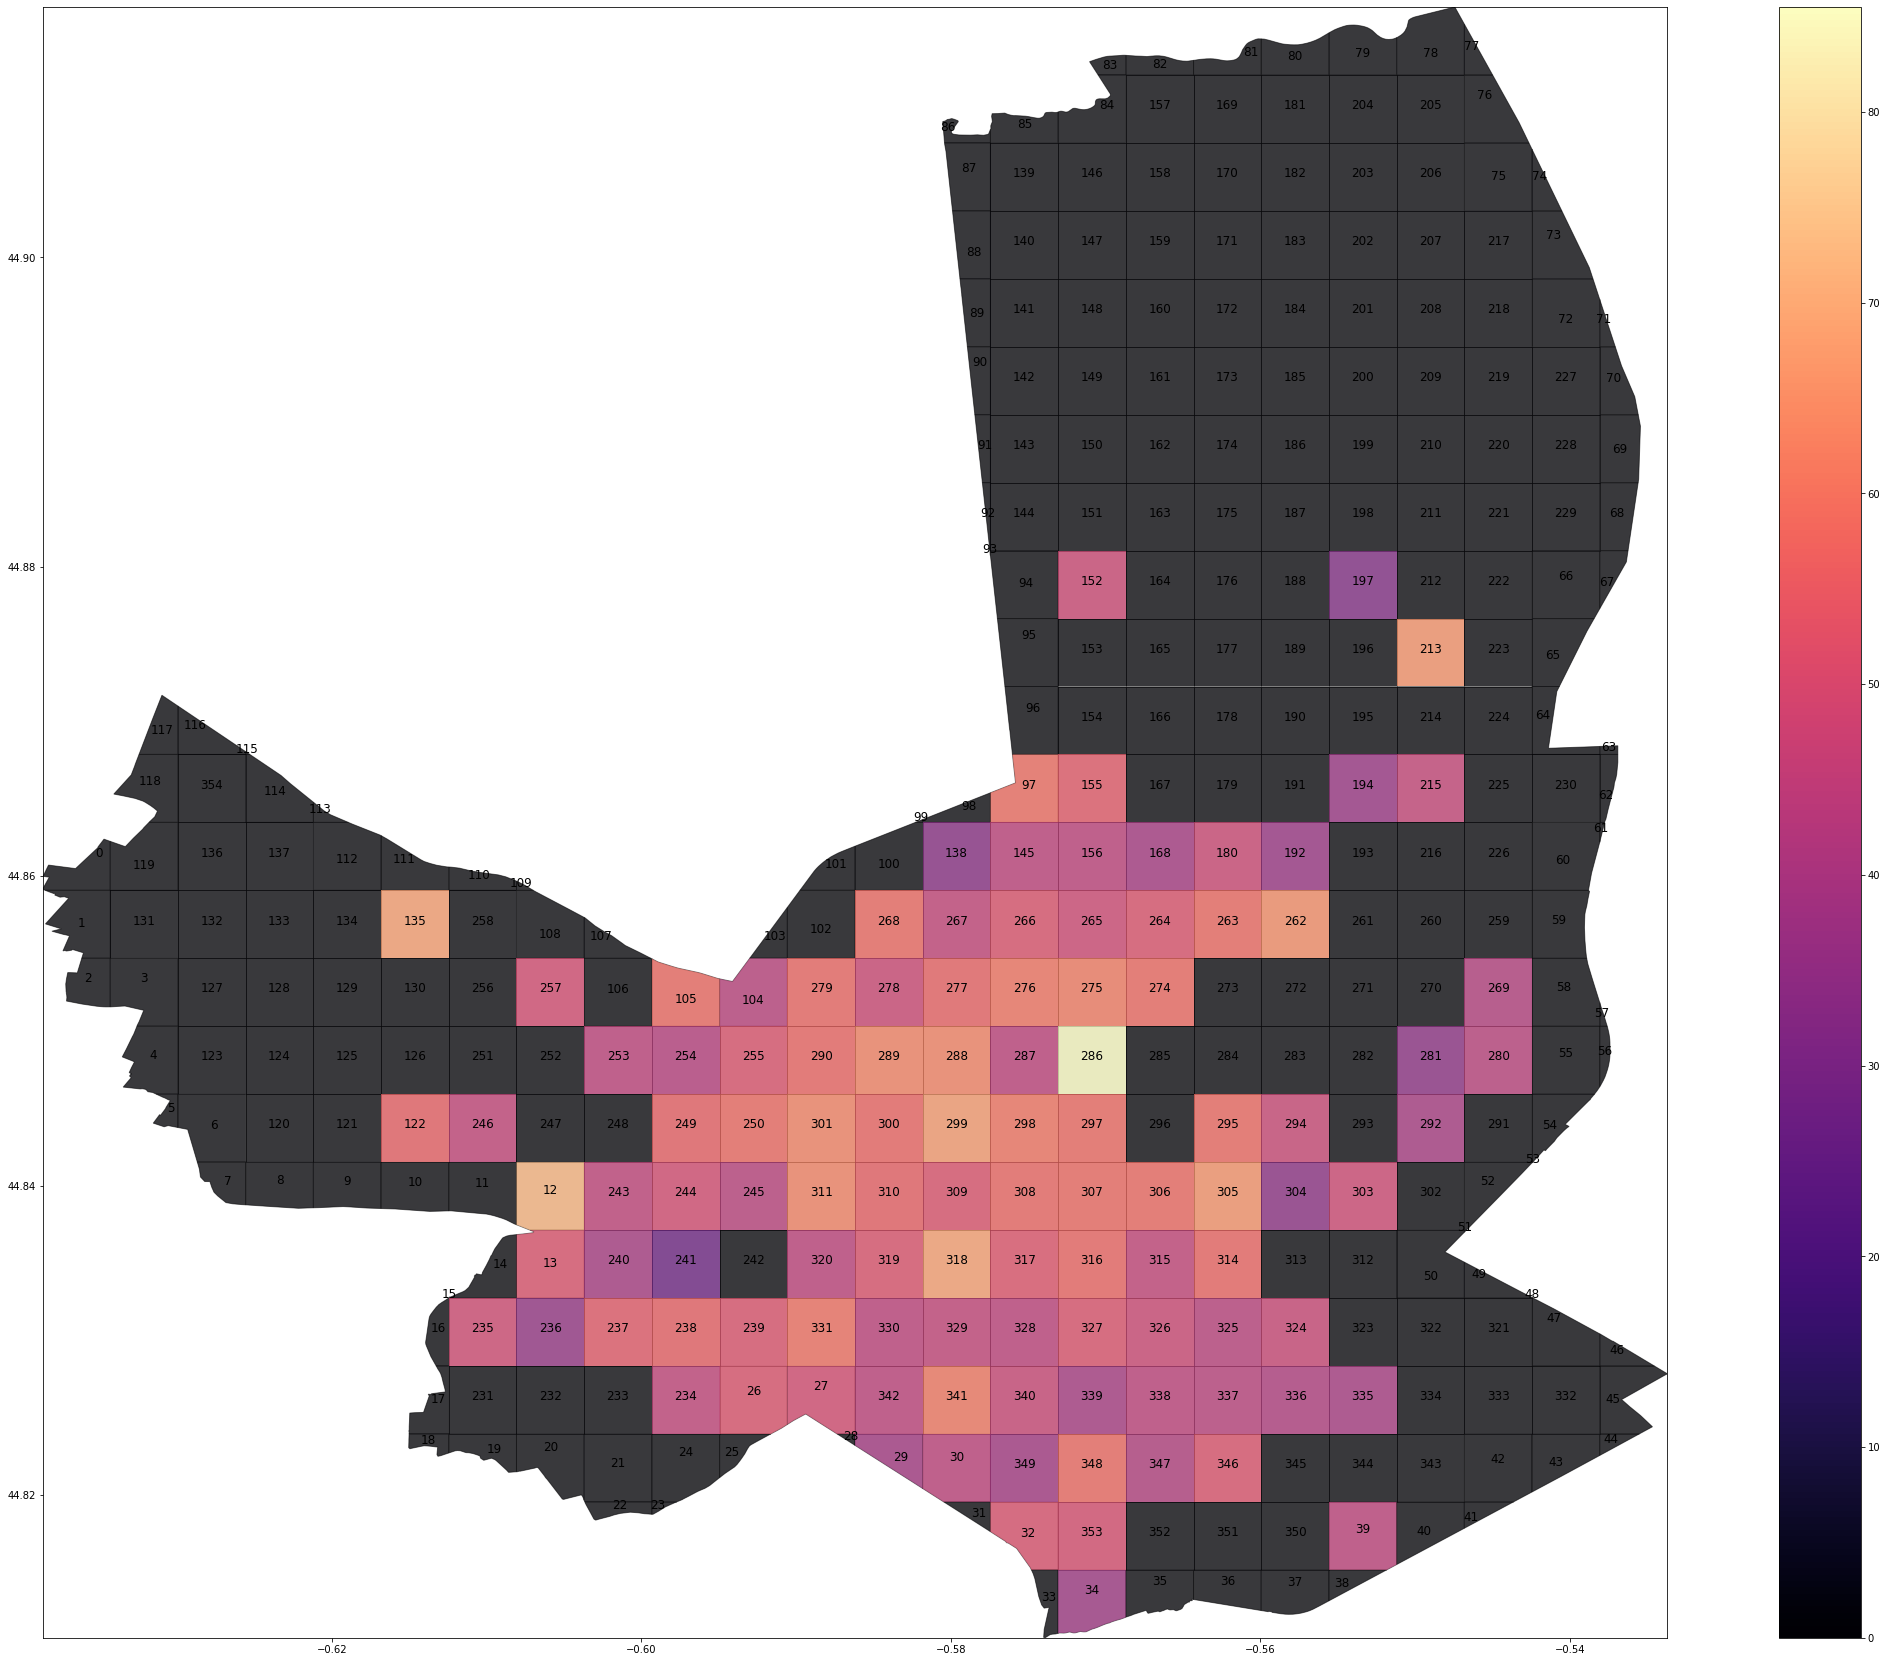

time: 3.39 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds

fig, ax = plt.subplots(figsize=(40,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=12)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [5]:
polyair.loc[polyair.index==135, 'median_prices'] = 32
polyair.loc[polyair.index==135, 'hmean_prices'] = 32
polyair.loc[polyair.index==135, 'prices'] = 32
polyair.loc[polyair.index==12, 'median_prices'] = 40
polyair.loc[polyair.index==12, 'hmean_prices'] = 40
polyair.loc[polyair.index==12, 'prices'] = 40

time: 9.99 ms


In [6]:
polyair.loc[polyair.index==213, 'median_prices'] = 30
polyair.loc[polyair.index==213, 'hmean_prices'] = 30
polyair.loc[polyair.index==213, 'prices'] = 30

time: 5 ms


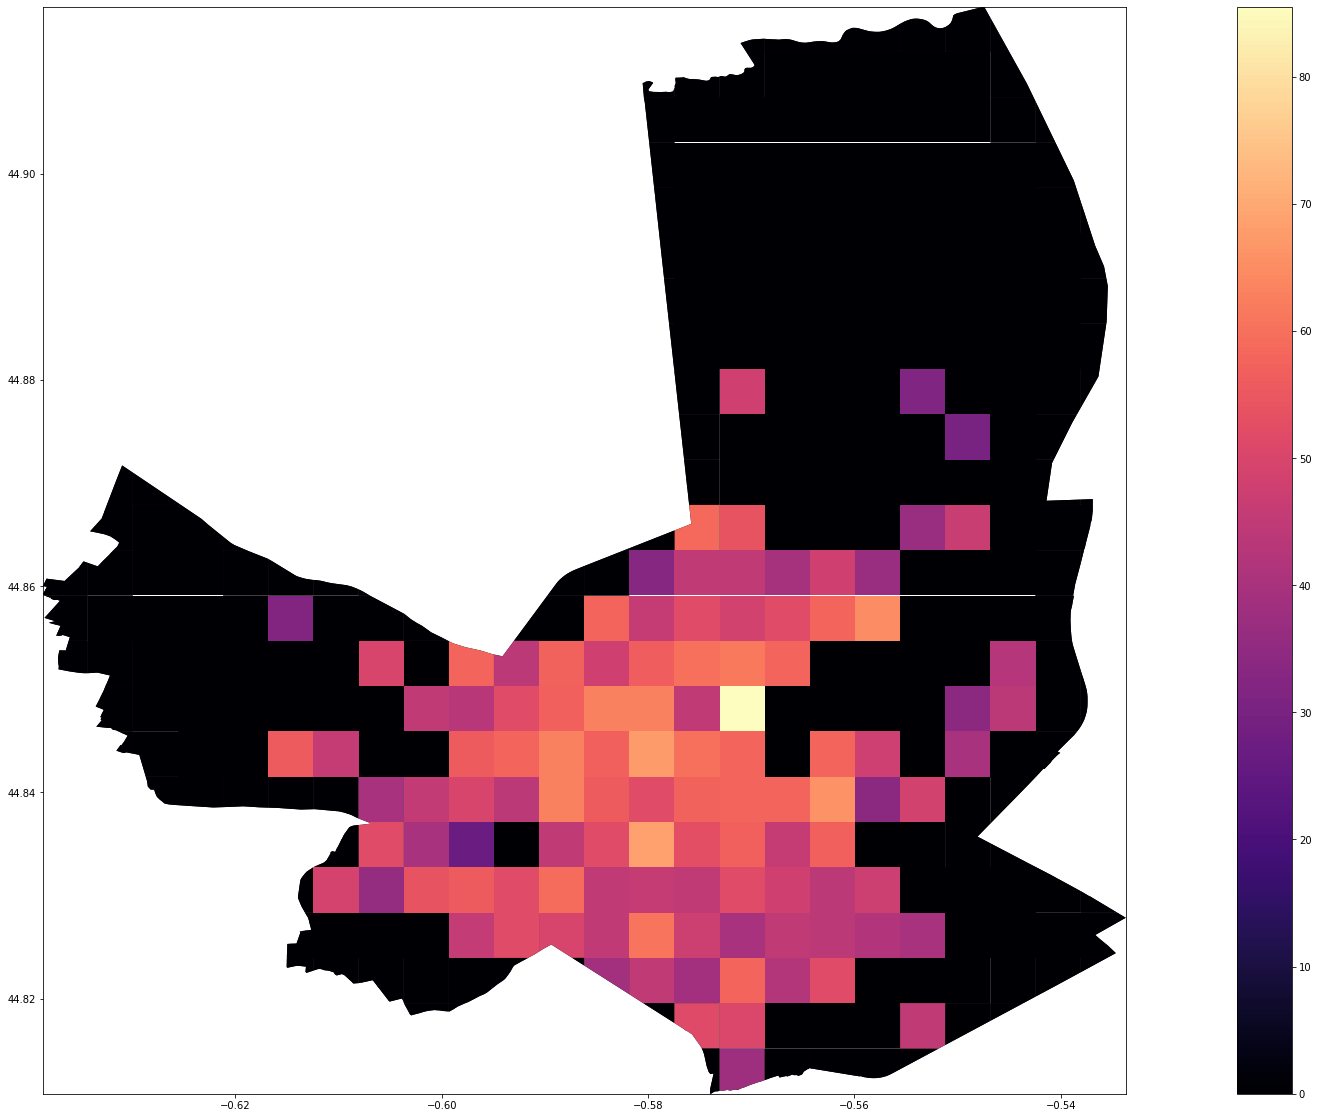

time: 704 ms


In [7]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

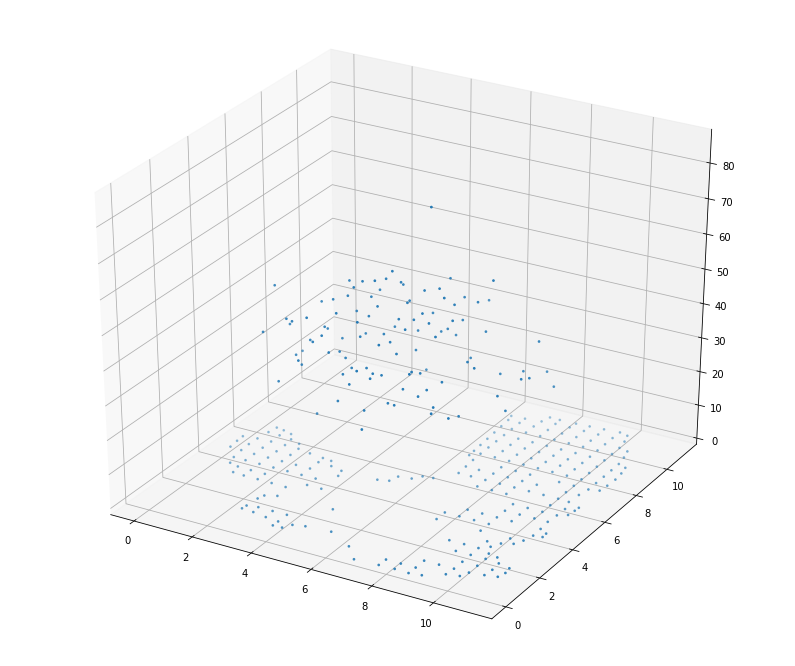

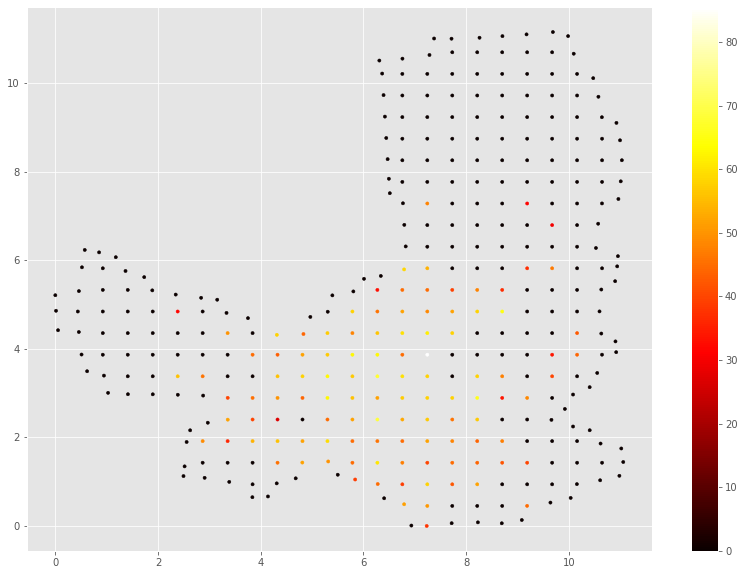

time: 1.29 s


In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=10, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Bordeaux_observed.jpg')
plt.show()

In [9]:
cdf = polyair[polyair.index.isin([286])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
286  POLYGON ((-0.5686887666711663 44.8503068499955...   -0.570877   

     center_lat  count  prices  hmean_prices  median_prices  cen_lon_km  \
286   44.848111     40    80.3     68.086676           85.5    7.245143   

     cen_lat_km  
286    3.868765

time: 175 ms


Fitted parameters:
[58.73069784  6.35763144  3.01255903  1.95520704  2.10108842 10.67006072
  1.38734192]
RMS residual = 14.739013840457137


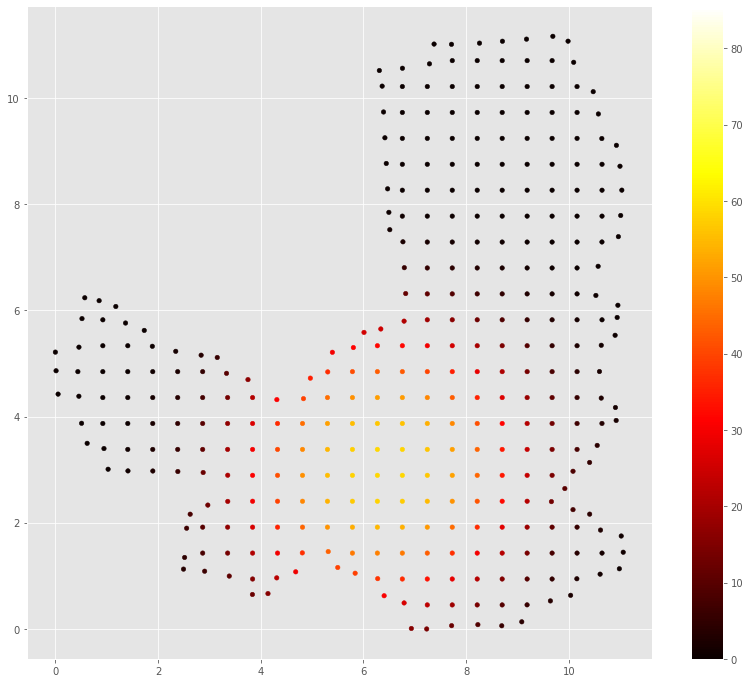

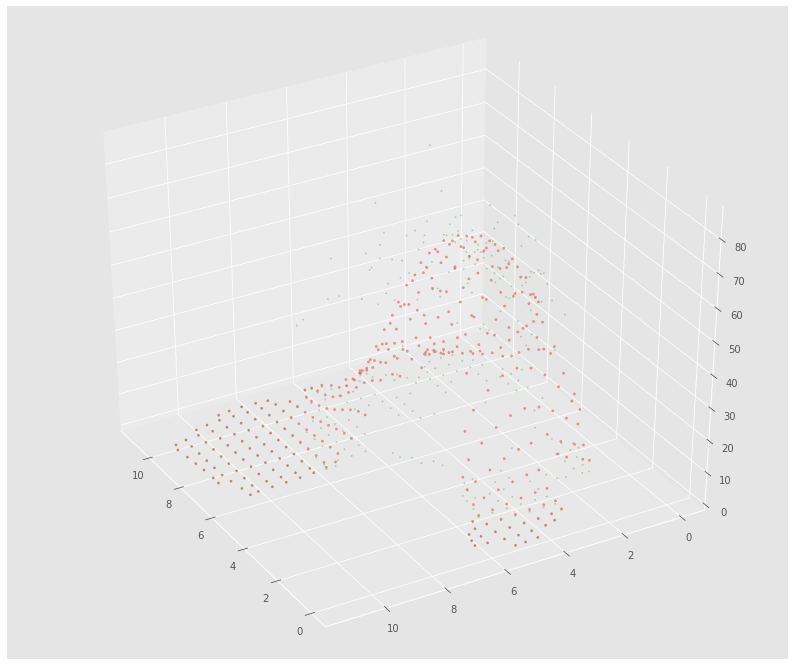

{'Bordeaux': 1.387341915093677}
time: 661 ms


In [10]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr

guess_prms = [(85.5,7.245143,3.868765, 1, 1,1, 1.5)]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bordeaux_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Bordeaux'] = np.mean(popt[6::7])
print(alphas)

In [11]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Bordeaux'] = alphas['Bordeaux']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[66.17700509  6.34034876  3.02505132  1.9339003   1.86771485 -3.6509427 ]
RMS residual = 14.828312403541318


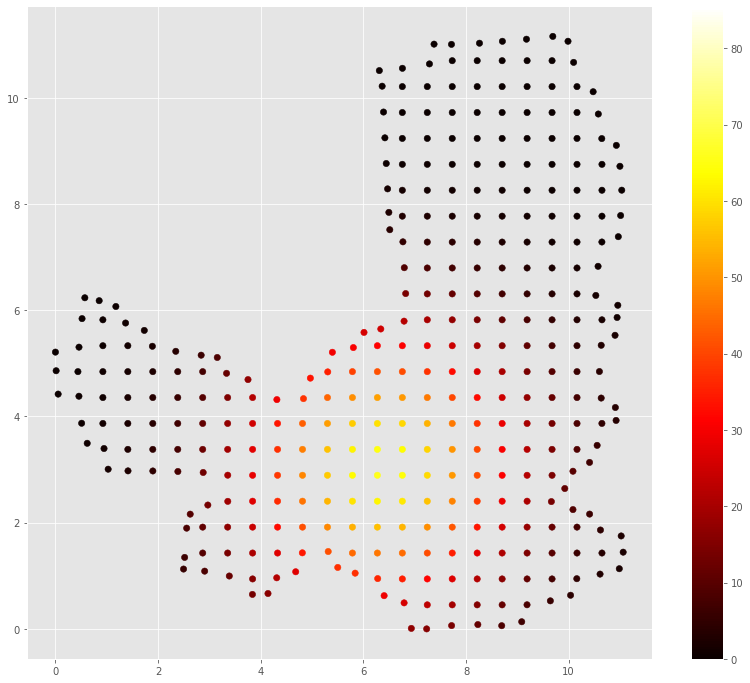

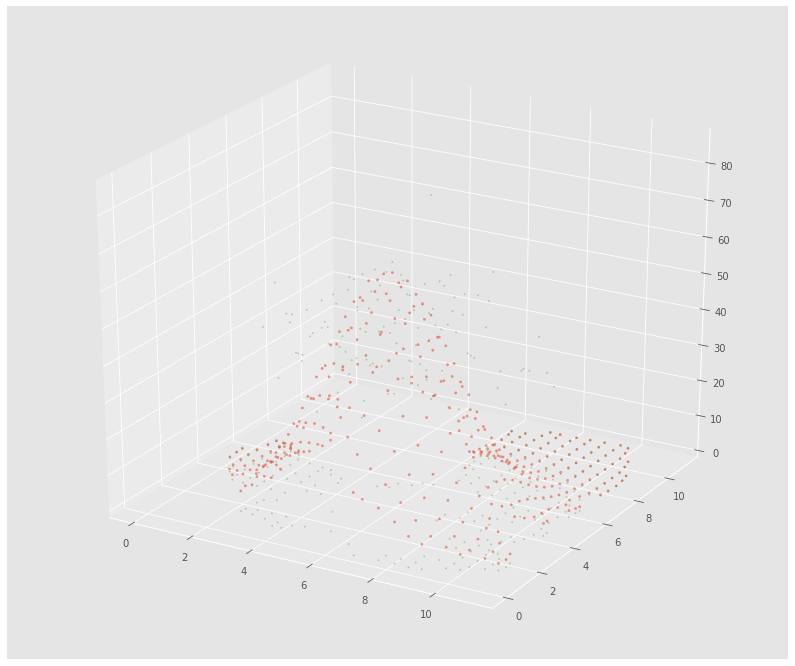

[66.17700509]
time: 637 ms


In [12]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(85.5,7.245143,3.868765, 1, 1,1)]
            

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Bordeaux_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 300)
plt.show()

print(popt[::6])

In [13]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
long stds:  [0.00572094] mean:  0.0057209390468692745
short stds:  [0.00552515] mean:  0.005525146683006936
time: 4 ms


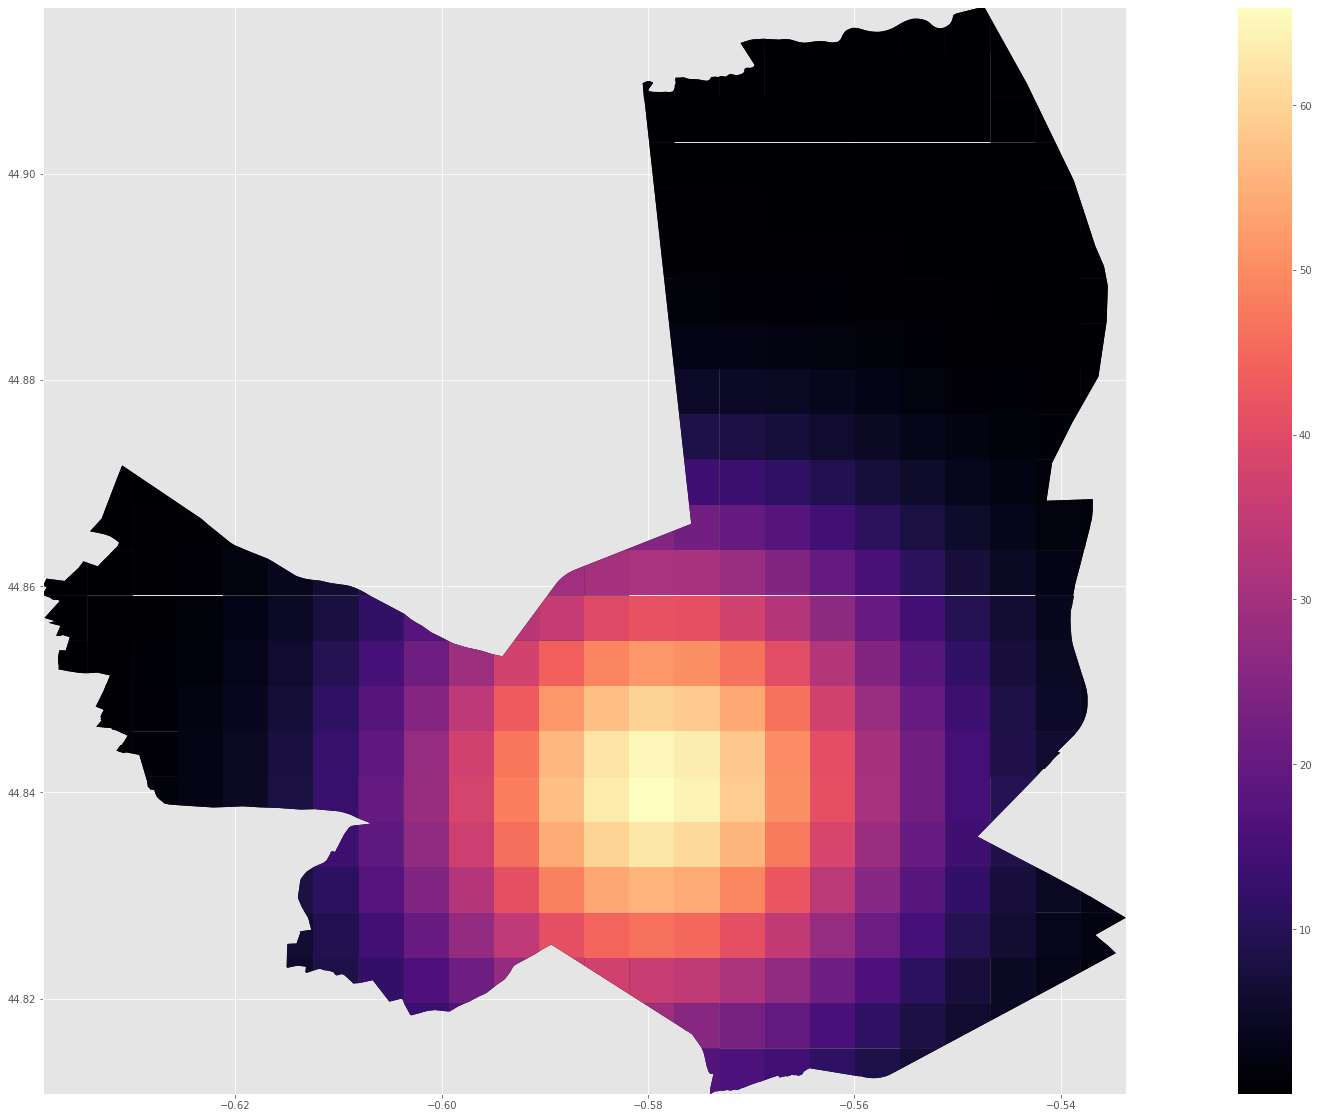

time: 693 ms


In [14]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [15]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Bordeaux'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Bordeaux'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Bordeaux'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

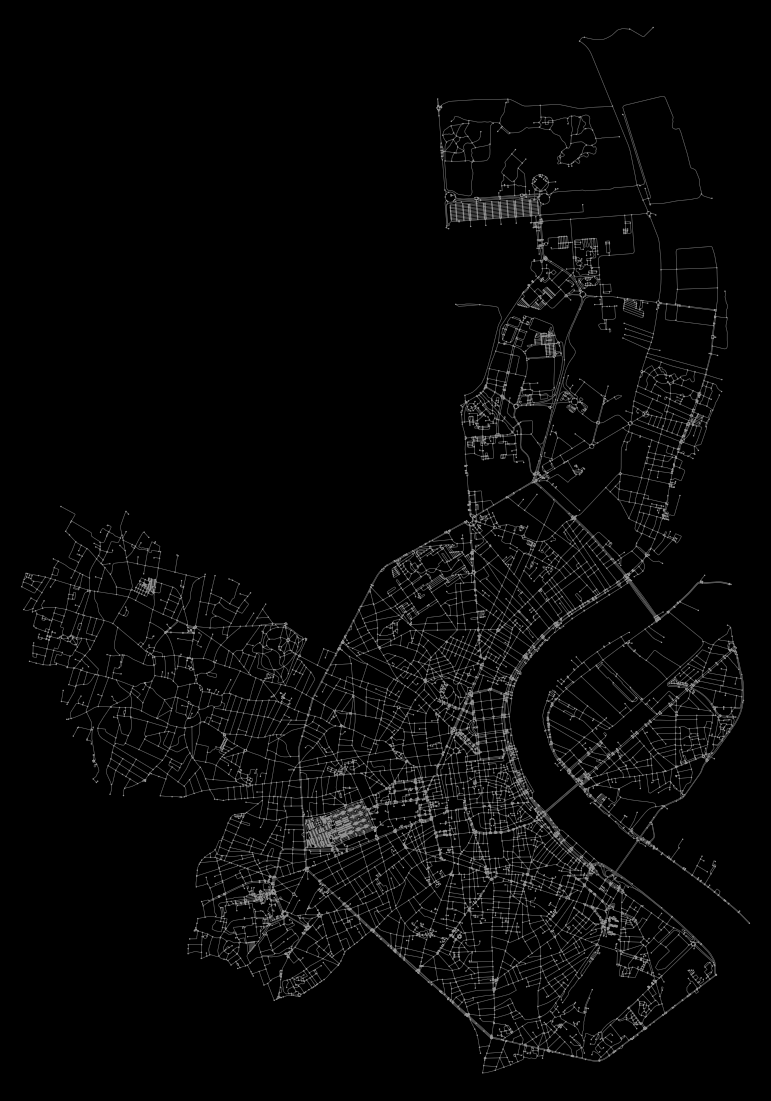

time: 31.5 s


In [16]:
# download and project a street network
G = ox.graph_from_place('Bordeaux, France', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [17]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 35258563}

time: 35 ms


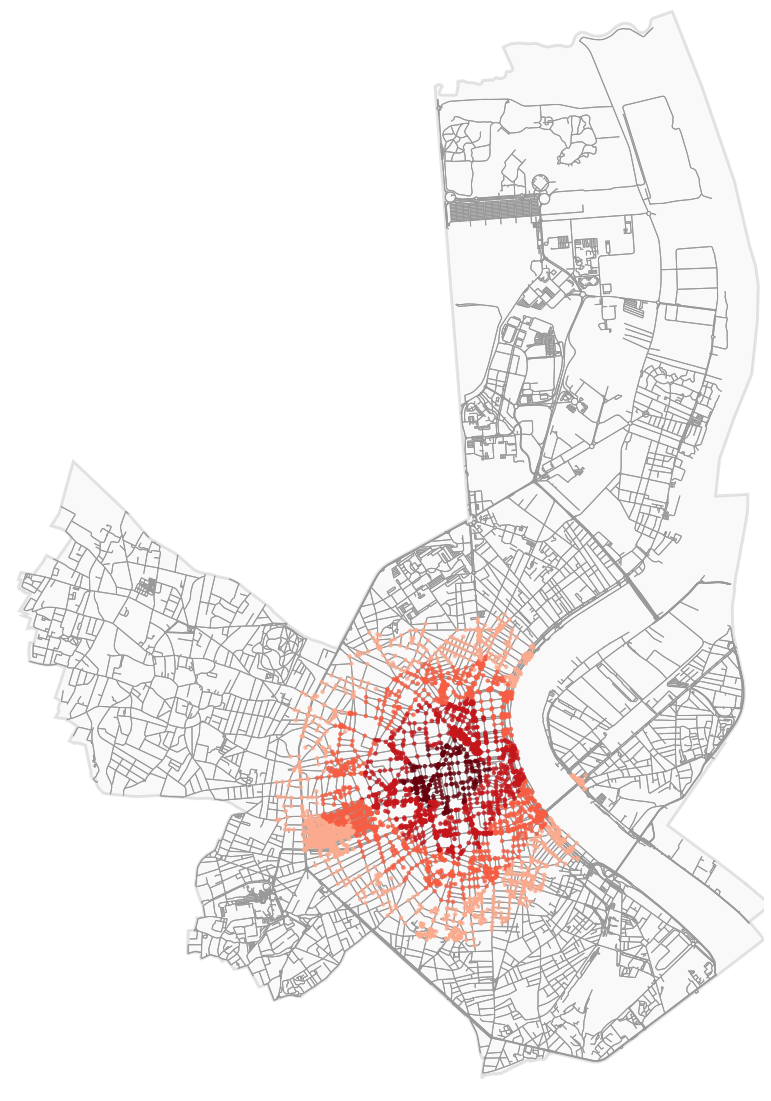

time: 7.3 s


In [18]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2500, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

355
355 224
Number of cells with price above 5th percentile:  224



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00437562 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes


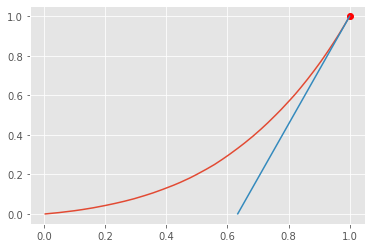

Loubar price:  28.418674235253125
Average price:  24.470548544878568
average city distance:  3886.5511701192345
eta =  0.5818334466519048
time: 1.66 s


In [19]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [20]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Bordeaux'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 5.98 ms


In [21]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Bordeaux'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345}

time: 6 ms


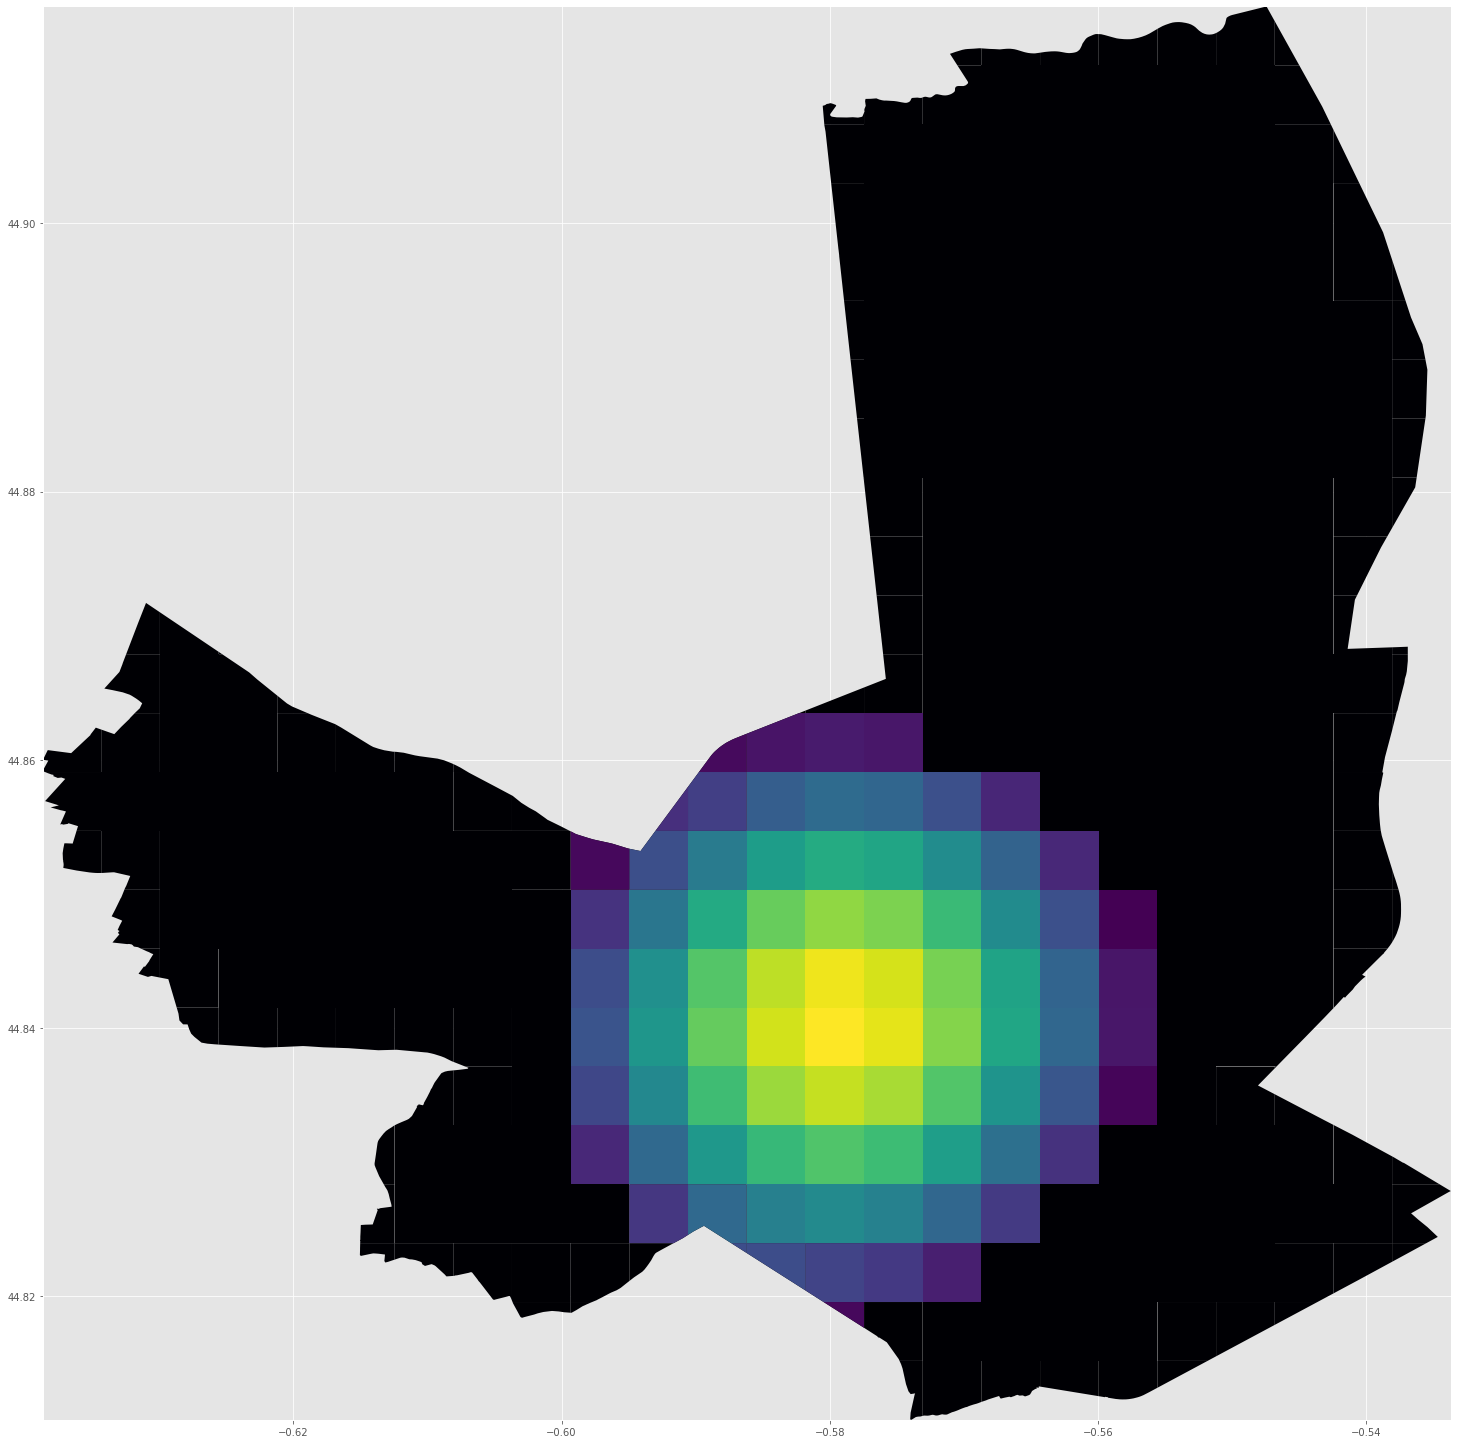

time: 688 ms


In [22]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [23]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

355
274



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00437562 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 2.14 s


355


355 274
Number of cells with price above 1.0th percentile:  274
Loubar price:  22.02493003786318
Average price:  20.316198440664685
eta =  0.5635962494653884
355 256
Number of cells with price above 2.0th percentile:  256
Loubar price:  25.482818636002055
Average price:  21.67644763542386
eta =  0.5700448937293736
355 241
Number of cells with price above 3.0th percentile:  241
Loubar price:  27.160273068857492
Average price:  22.924623568466192
eta =  0.5766181887951527
355 230
Number of cells with price above 4.0th percentile:  230
Loubar price:  27.914573389308533
Average price:  23.908664470500508
eta =  0.5799618065901108
355 224
Number of cells with price above 5.0th percentile:  224
Loubar price:  28.418674235253125
Average price:  24.470548544878568
eta =  0.5818334466519048
355 215
Number of cells with price above 6.000000000000001th percentile:  215
Loubar price:  29.32758487065377
Average price:  25.347332474111955
eta =  0.581145258167541
355 206
Number of cells with price a

eta =  0.6154223857015134
355 65
Number of cells with price above 52.0th percentile:  65
Loubar price:  51.29662471034893
Average price:  48.14512783347707
eta =  0.612241608550401
355 62
Number of cells with price above 53.0th percentile:  62
Loubar price:  51.461972894555196
Average price:  48.79763874488497
eta =  0.6087534309576859
355 61
Number of cells with price above 54.0th percentile:  61
Loubar price:  51.461972894555196
Average price:  49.01725644584779
eta =  0.6130955229385231
355 60
Number of cells with price above 55.00000000000001th percentile:  60
Loubar price:  53.64703603536637
Average price:  49.23385206083181
eta =  0.6079863039303056
355 59
Number of cells with price above 56.00000000000001th percentile:  59
Loubar price:  53.64703603536637
Average price:  49.44953060652769
eta =  0.6126352781791656
355 54
Number of cells with price above 57.00000000000001th percentile:  54
Loubar price:  54.13427809947296
Average price:  50.56991975555185
eta =  0.610065352085201

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
355 5
Number of cells with price above 96.00000000000001th percentile:  5
Loubar price:  64.95315709385194
Average price:  64.45394734812592
eta =  nan
355 3
Number of cells with price above 97.0th percentile:  3
Loubar price:  64.95315709385194
Average price:  65.12041896314679
eta =  nan
355 2
Number of cells with price above 98.0th percentile:  2
Loubar price:  65.97768979139126
Average price:  65.4654234426216
eta =  nan
355 1
Number of cells with price above 99.0th percentile:  1


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  65.97768979139126
Average price:  65.97768979139126
eta =  nan
355 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  65.97768979139126
Average price:  65.97768979139126
eta =  nan



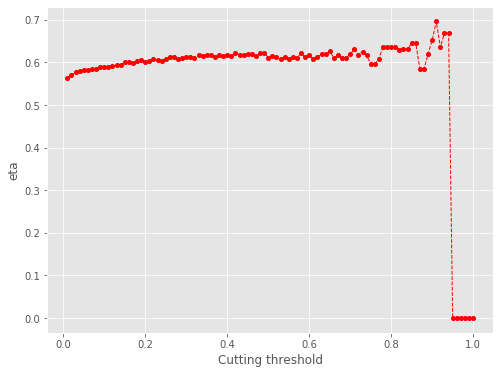

time: 1.58 s


In [24]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [25]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Bordeaux'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 24 ms


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


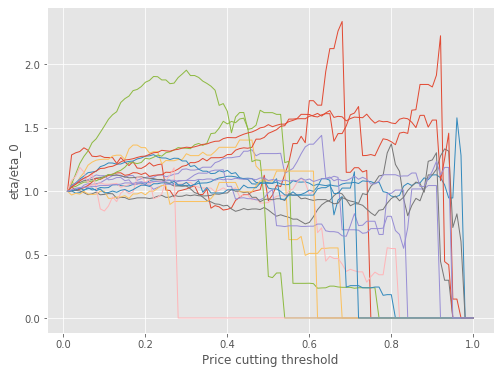

time: 240 ms


In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

355 224
Number of cells with price above 5th percentile:  224


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9737082127722259
eta =  0.9472546397237389
eta =  0.9346419683008947
eta =  0.92094481629014
eta =  0.907409982705314
eta =  0.8921972713849216
eta =  0.8728958693759197
eta =  0.8524016789560558
eta =  0.8445130648748284
eta =  0.8238426809632817
eta =  0.8238426809632817
eta =  0.8103793546276952
eta =  0.7867734755408912
eta =  0.7834906581022293
eta =  0.7772651064007994
eta =  0.7652421611839375
eta =  0.7443174424605018
eta =  0.7348404930957221
eta =  0.7290356470881104
eta =  0.7189877977513756
eta =  0.7122206443741863
eta =  0.6965306357910322
eta =  0.6965306357910322
eta =  0.6895970156021993
eta =  0.6829744663287131
eta =  0.6643453288438038
eta =  0.661284375092541
eta =  0.6441068826919235
eta =  0.6409143137991299
eta =  0.6375344303996703
eta =  0.6375344303996703
eta =  0.6312022089341327
eta =  0.6218498868968229
eta =  0.6125004313706515
eta =  0.6090305605896021
eta =  0.6027279160528165
et

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan



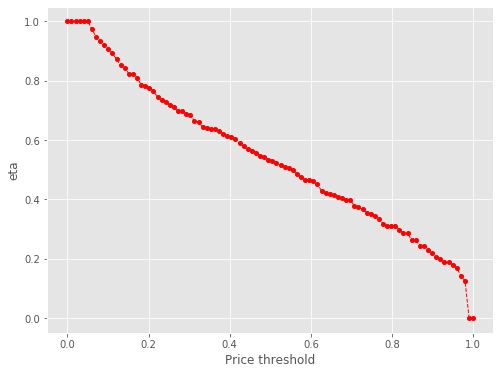

time: 597 ms


In [27]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [28]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Bordeaux'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 20 ms


355 274
Number of cells with price above 1.0th percentile:  274


eta =  1.0
eta =  0.9502808605663031
eta =  0.9191811141299118
eta =  0.8894493353986662
eta =  0.8793628685316367
eta =  0.8562428470961977
eta =  0.8359348402571776
eta =  0.8218894422951298
eta =  0.8098446754122387
eta =  0.7979426453259877
eta =  0.7866767986754923
eta =  0.7675922156238255
eta =  0.7495703855479804
eta =  0.7426334312407732
eta =  0.7244566631506654
eta =  0.7244566631506654
eta =  0.7147712878293885
eta =  0.6918593803362435
eta =  0.6889725925765161
eta =  0.6860489387808758
eta =  0.6729255419800564
eta =  0.6545251213001984
eta =  0.6490331341083388
eta =  0.643701072361993
eta =  0.6322511722698939
eta =  0.6291937678398951
eta =  0.6151253795026465
eta =  0.6125031779093668
eta =  0.6094693472260849
eta =  0.6005823858446808
eta =  0.5868821872308084
eta =  0.5815089249965276
eta =  0.5694975168968109
eta =  0.5635962494653884
eta =  0.5606241055039372
eta =  0.5606241055039372
eta =  0.5576235449725572
eta =  0.5496154966120625
eta =  0.5413736075861949
et

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan


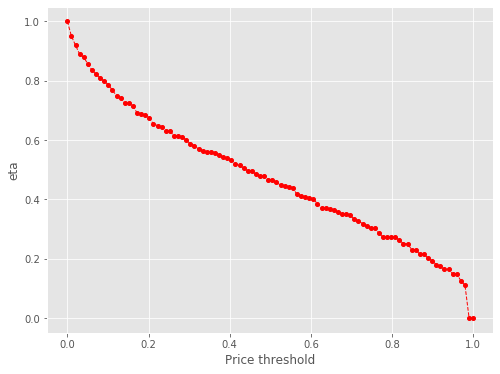

355 256
Number of cells with price above 2.0th percentile:  256


eta =  1.0
eta =  0.9630802241938489
eta =  0.9352212463016206
eta =  0.9232656867704455
eta =  0.9002867333623548
eta =  0.8801248610302234
eta =  0.8611420058357276
eta =  0.8485219937275393
eta =  0.836051535373226
eta =  0.8265414767350214
eta =  0.8072497567985925
eta =  0.7908772237387705
eta =  0.7781008121889313
eta =  0.7614199217140755
eta =  0.7590559410332491
eta =  0.7540923942247006
eta =  0.7335346380811053
eta =  0.7249018467438545
eta =  0.7188139046943643
eta =  0.7050637484533041
eta =  0.6911691118333314
eta =  0.6800302646535353
eta =  0.6744435493227411
eta =  0.6624468142090804
eta =  0.6624468142090804
eta =  0.6445031118372245
eta =  0.6417556766914015
eta =  0.6417556766914015
eta =  0.632623308440345
eta =  0.6183349911519606
eta =  0.6121014125742438
eta =  0.599746795162826
eta =  0.5905130054850366
eta =  0.5873989150966147
eta =  0.5873989150966147
eta =  0.5873989150966147
eta =  0.5785376379912756
eta =  0.5700448937293736
eta =  0.5643335822000732
eta 

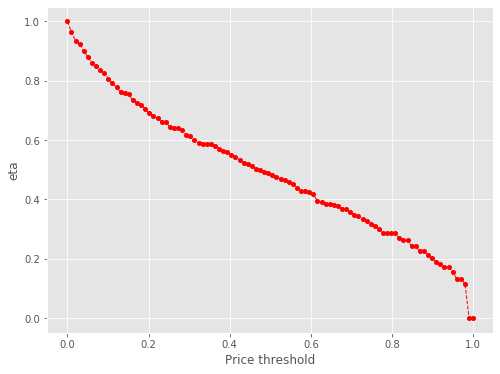

355 241
Number of cells with price above 3.0th percentile:  241


eta =  1.0
eta =  0.963030506093149
eta =  0.9491684664884247
eta =  0.9315278936150784
eta =  0.9062202697733412
eta =  0.8941539699421726
eta =  0.8810501684195613
eta =  0.8681016538087957
eta =  0.8558452589837567
eta =  0.8350826663256905
eta =  0.8154762690675131
eta =  0.8079293839100938
eta =  0.7881544257318965
eta =  0.7881544257318965
eta =  0.7830006008647072
eta =  0.7616547611027047
eta =  0.7526910308542959
eta =  0.7463697069432104
eta =  0.7320924371004308
eta =  0.7176651482090995
eta =  0.7060992922191482
eta =  0.7002984096026761
eta =  0.691291196285352
eta =  0.6878417784599251
eta =  0.6721136856517314
eta =  0.6663574441356496
eta =  0.6663574441356496
eta =  0.6568749856429514
eta =  0.6450156115883463
eta =  0.6355663808657336
eta =  0.6294284926991925
eta =  0.6131503800520133
eta =  0.6131503800520133
eta =  0.6099169107000405
eta =  0.6099169107000405
eta =  0.6038589963820514
eta =  0.5949118100139489
eta =  0.5859673659818438
eta =  0.5826478074350541
eta

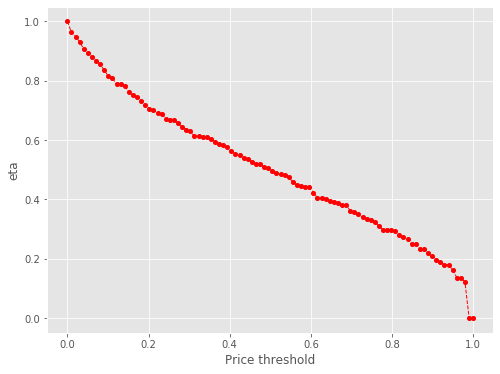

355 230
Number of cells with price above 4.0th percentile:  230


eta =  1.0
eta =  0.9872163302764411
eta =  0.9626457235895611
eta =  0.9410873250695718
eta =  0.9231940969446634
eta =  0.912630266531434
eta =  0.8939612296870219
eta =  0.8863095243310795
eta =  0.8657415934442472
eta =  0.8480226732391246
eta =  0.831996509131898
eta =  0.8165762775870673
eta =  0.8116324816560508
eta =  0.8063251313064121
eta =  0.7871151216687604
eta =  0.7751126801390743
eta =  0.7718785174449913
eta =  0.7564025947518117
eta =  0.7509322262500903
eta =  0.7304623291103847
eta =  0.7239493981244935
eta =  0.7148529458255916
eta =  0.7083316560960945
eta =  0.6984909956341492
eta =  0.6862073324673242
eta =  0.6862073324673242
eta =  0.6793764756899806
eta =  0.672852079435778
eta =  0.6544990450065474
eta =  0.6514834577508993
eta =  0.6345605535267099
eta =  0.6314153018018464
eta =  0.6280855117647436
eta =  0.6280855117647436
eta =  0.6247238857154341
eta =  0.6186104521033196
eta =  0.6095294519704774
eta =  0.6034225424537335
eta =  0.5969258715605209
eta 

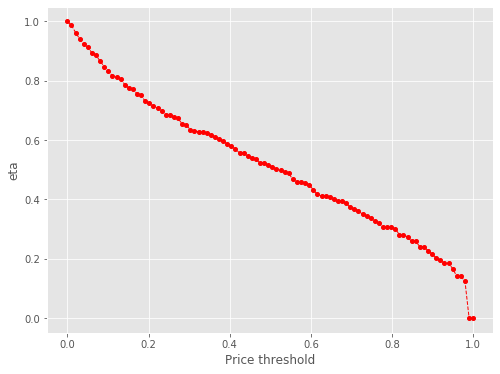

355 224
Number of cells with price above 5.0th percentile:  224


eta =  1.0
eta =  0.9737082127722259
eta =  0.9530121778310426
eta =  0.9346419683008947
eta =  0.92094481629014
eta =  0.907409982705314
eta =  0.8970882240824233
eta =  0.8761499224189306
eta =  0.8607803265998836
eta =  0.8445130648748284
eta =  0.8288608513618267
eta =  0.8238426809632817
eta =  0.8184554868333274
eta =  0.8016289335063342
eta =  0.7867734755408912
eta =  0.7834906581022293
eta =  0.7703669168260187
eta =  0.7652421611839375
eta =  0.7443174424605018
eta =  0.7348404930957221
eta =  0.7290356470881104
eta =  0.7189877977513756
eta =  0.7122206443741863
eta =  0.6995125692875628
eta =  0.6965306357910322
eta =  0.693080603055004
eta =  0.6829744663287131
eta =  0.6673947789162242
eta =  0.661284375092541
eta =  0.6509362234270896
eta =  0.6409143137991299
eta =  0.6375344303996703
eta =  0.6375344303996703
eta =  0.6375344303996703
eta =  0.627916827937744
eta =  0.6186992132360704
eta =  0.6125004313706515
eta =  0.6090305605896021
eta =  0.5955204335857311
eta =  

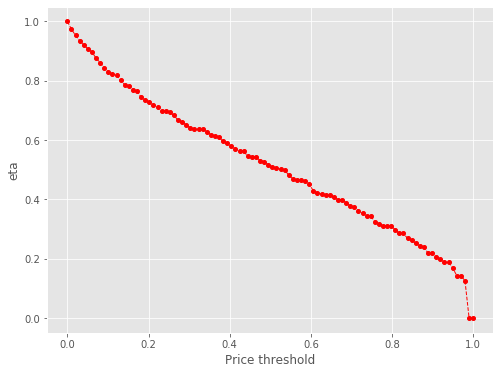

355 215
Number of cells with price above 6.000000000000001th percentile:  215


eta =  1.0
eta =  0.9776050544954364
eta =  0.9590175017889359
eta =  0.950634871649654
eta =  0.9286502892814761
eta =  0.9207016689651563
eta =  0.8993356249649425
eta =  0.8809291439814178
eta =  0.866827945201473
eta =  0.854440921166569
eta =  0.8431268760324363
eta =  0.8431268760324363
eta =  0.8233892632460051
eta =  0.805189968796408
eta =  0.8018303084199785
eta =  0.7954590313802072
eta =  0.7831546576500803
eta =  0.7617401410963622
eta =  0.7553485344761058
eta =  0.7491430500190271
eta =  0.7358175897305524
eta =  0.7322593646814213
eta =  0.7158864925512788
eta =  0.7128347590934703
eta =  0.7093039693078088
eta =  0.7026909150128746
eta =  0.6868200632509909
eta =  0.6798960707642464
eta =  0.6694387686429308
eta =  0.6559165914614917
eta =  0.6559165914614917
eta =  0.6524575930412979
eta =  0.6524575930412979
eta =  0.648965523251828
eta =  0.6364059117298996
eta =  0.6268376077168468
eta =  0.6232865155247773
eta =  0.6200888415466845
eta =  0.6058559236710531
eta = 

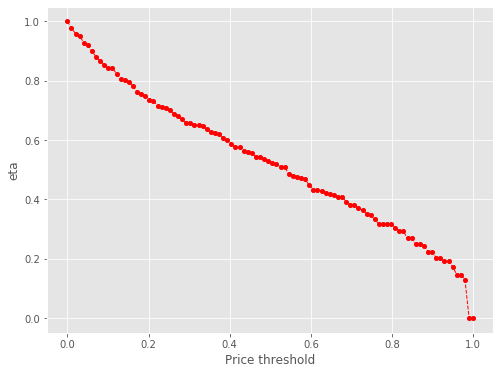

355 206
Number of cells with price above 6.999999999999999th percentile:  206


eta =  1.0
eta =  0.980724055833204
eta =  0.9663515721132918
eta =  0.9521494098538021
eta =  0.9439996529101073
eta =  0.9220929497942828
eta =  0.9032207002421845
eta =  0.8887626763213132
eta =  0.8760622036452058
eta =  0.8644618611676743
eta =  0.8644618611676743
eta =  0.8469898375755508
eta =  0.8255649758133273
eta =  0.8221203005877356
eta =  0.815587800955256
eta =  0.802972070016513
eta =  0.7810156677687913
eta =  0.7744623241240017
eta =  0.7680998123885711
eta =  0.7544371567084459
eta =  0.7507888922112922
eta =  0.73400171116342
eta =  0.7308727548227811
eta =  0.7308727548227811
eta =  0.720472224863908
eta =  0.7074646514330953
eta =  0.6971005662863462
eta =  0.6938886936340688
eta =  0.6758642729601256
eta =  0.6725142959429803
eta =  0.6689677689645402
eta =  0.6689677689645402
eta =  0.6653873337591792
eta =  0.6558316864138608
eta =  0.6492038901792062
eta =  0.6426994802570511
eta =  0.6357799392841698
eta =  0.6248822915789746
eta =  0.6177116786998125
eta =  

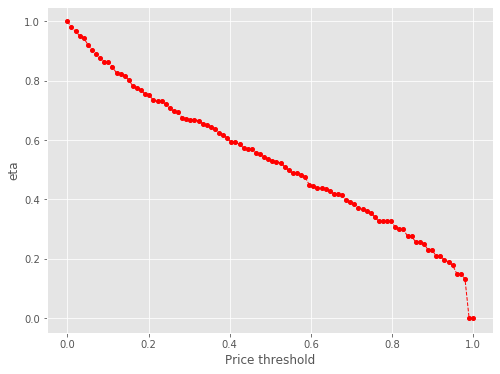

355 199
Number of cells with price above 8.0th percentile:  199


eta =  1.0
eta =  0.9745349049429883
eta =  0.9682576377244545
eta =  0.9469112827500991
eta =  0.9339360942273707
eta =  0.9120087775489631
eta =  0.9035685251862661
eta =  0.8814526940845195
eta =  0.8814526940845195
eta =  0.8756887820062422
eta =  0.8548262424563855
eta =  0.8417912978711871
eta =  0.8382789182113803
eta =  0.8214716882647508
eta =  0.8155307344926211
eta =  0.7932999263507252
eta =  0.7862267242627721
eta =  0.7763477549426698
eta =  0.7692654750550508
eta =  0.7620251053662261
eta =  0.7484283747275134
eta =  0.7452379193470949
eta =  0.741546631289166
eta =  0.7346329689566031
eta =  0.7180406796575602
eta =  0.7108019448896898
eta =  0.6964551619808387
eta =  0.6857324360944989
eta =  0.6857324360944989
eta =  0.6821162028050779
eta =  0.6821162028050779
eta =  0.6784653948290065
eta =  0.6687219330586105
eta =  0.6553316158957947
eta =  0.6553316158957947
eta =  0.6482760726655404
eta =  0.6371642337742871
eta =  0.629852683867346
eta =  0.6187762265782067
eta

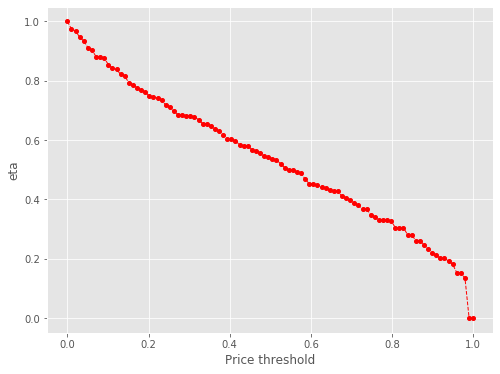

355 194
Number of cells with price above 9.0th percentile:  194


eta =  1.0
eta =  0.9853033174785123
eta =  0.9713921972445481
eta =  0.9513598501464425
eta =  0.9320644951870527
eta =  0.9170072407560713
eta =  0.9000114194689135
eta =  0.8945624823450153
eta =  0.8916608701746086
eta =  0.8736207612450045
eta =  0.8543112047801801
eta =  0.8507465857274489
eta =  0.8439866240106237
eta =  0.8309316124570606
eta =  0.8082106867801812
eta =  0.8014291552611107
eta =  0.7948451004315453
eta =  0.7846218309286503
eta =  0.780706710145444
eta =  0.7628551809454589
eta =  0.7563217941731625
eta =  0.7563217941731625
eta =  0.7487929823853251
eta =  0.7416019442727876
eta =  0.721373655720219
eta =  0.7180499454423401
eta =  0.7032182024372973
eta =  0.6959312897605934
eta =  0.6922612724700082
eta =  0.6922612724700082
eta =  0.6922612724700082
eta =  0.6818180816383695
eta =  0.6752303459417176
eta =  0.6650783201516882
eta =  0.6613105908375398
eta =  0.6544669185291656
eta =  0.6428166322642037
eta =  0.6317788388187208
eta =  0.6241181670190248
eta

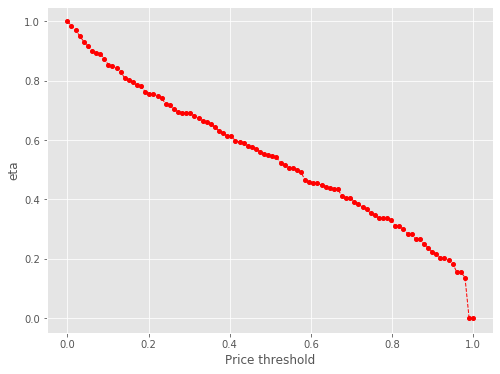

355 189
Number of cells with price above 10.0th percentile:  189


eta =  1.0
eta =  0.9780371446895952
eta =  0.961964146320613
eta =  0.9393787760795194
eta =  0.9306852260507786
eta =  0.9079056839413556
eta =  0.9079056839413556
eta =  0.9019687929740628
eta =  0.8804801545413008
eta =  0.867054022477511
eta =  0.8634362339351427
eta =  0.8528522784810894
eta =  0.8433257025699417
eta =  0.8202658739122806
eta =  0.8133831897694676
eta =  0.8067009278580648
eta =  0.7923516508026676
eta =  0.7923516508026676
eta =  0.7742338500368394
eta =  0.767603011942215
eta =  0.767603011942215
eta =  0.7599619011753251
eta =  0.7526636022809906
eta =  0.7321335906655474
eta =  0.7287603042684362
eta =  0.7137073325165508
eta =  0.7063117290029529
eta =  0.7025869701135004
eta =  0.7025869701135004
eta =  0.7025869701135004
eta =  0.6919880097259886
eta =  0.685302012044066
eta =  0.6749985596858528
eta =  0.6711746313103851
eta =  0.6677312748445546
eta =  0.6524048187610232
eta =  0.6445825771061352
eta =  0.6373461184795809
eta =  0.6223295150529065
eta = 

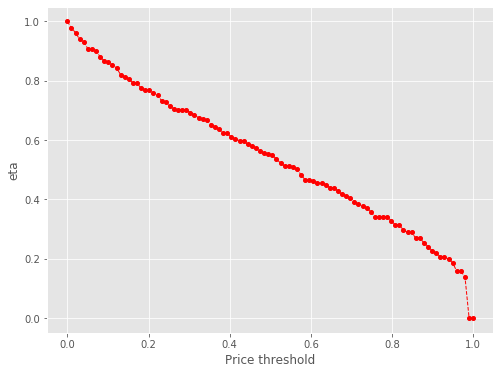

355 184
Number of cells with price above 11.0th percentile:  184


eta =  1.0
eta =  0.9757402492563667
eta =  0.9595140848680355
eta =  0.944013389604379
eta =  0.9265170360868521
eta =  0.9209076260675472
eta =  0.9179205605149955
eta =  0.899349164758702
eta =  0.8794709358418978
eta =  0.8758013376478392
eta =  0.8720848764523866
eta =  0.855402807243132
eta =  0.8385454504489115
eta =  0.8250314934940237
eta =  0.8182535361990796
eta =  0.8077291882252188
eta =  0.8036987659155564
eta =  0.7925331959442118
eta =  0.778595706573046
eta =  0.778595706573046
eta =  0.7747391918157913
eta =  0.7634423525085092
eta =  0.750181084204579
eta =  0.7426183345578317
eta =  0.7276293715891284
eta =  0.7164266829965
eta =  0.7164266829965
eta =  0.7126485825536556
eta =  0.7126485825536556
eta =  0.7088343598176706
eta =  0.6986547684353168
eta =  0.6915942046664645
eta =  0.6846650838232488
eta =  0.6807863937073142
eta =  0.6656845068125268
eta =  0.658045682729439
eta =  0.6464734292712155
eta =  0.6424986414235145
eta =  0.6312417759642077
eta =  0.62769

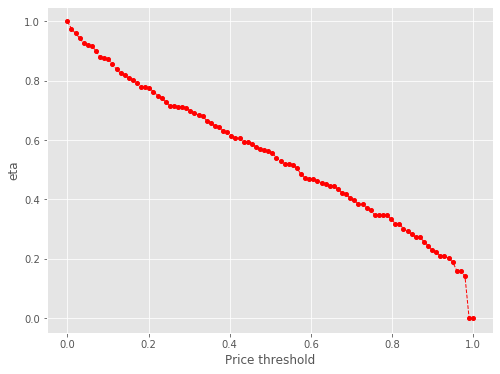

355 176
Number of cells with price above 12.0th percentile:  176


eta =  1.0
eta =  0.9765216091187184
eta =  0.9674843180076179
eta =  0.9438040777444523
eta =  0.9438040777444523
eta =  0.937632443396124
eta =  0.9152941488609759
eta =  0.9013371504477367
eta =  0.8975763153311621
eta =  0.8865738725742927
eta =  0.8766706179180919
eta =  0.8526990086373699
eta =  0.8455441846565195
eta =  0.8385977075586344
eta =  0.8278116935739886
eta =  0.8236810632010652
eta =  0.8048468885230106
eta =  0.7979538685284645
eta =  0.7979538685284645
eta =  0.7900106298993366
eta =  0.7824237578498433
eta =  0.7688327757067607
eta =  0.757575328618898
eta =  0.7457203616881347
eta =  0.7342391415568894
eta =  0.7342391415568894
eta =  0.7303671065089105
eta =  0.7303671065089105
eta =  0.7264580510621439
eta =  0.7160253653242009
eta =  0.7087892553305492
eta =  0.7016878563173419
eta =  0.6977127306433824
eta =  0.6822353667585812
eta =  0.6744066192113631
eta =  0.662546645753219
eta =  0.6584730330773759
eta =  0.6469362890844066
eta =  0.6469362890844066
eta 

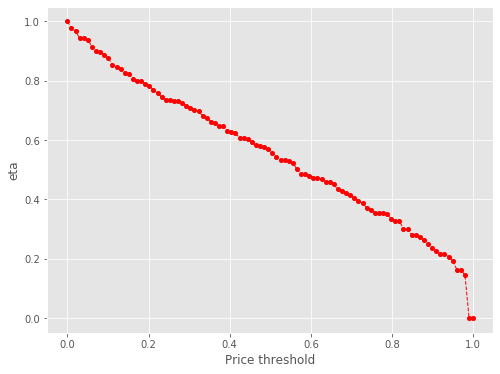

355 169
Number of cells with price above 13.0th percentile:  169


eta =  1.0
eta =  0.9907454263922982
eta =  0.9664958449779798
eta =  0.9664958449779798
eta =  0.9601758267718307
eta =  0.9373004553242826
eta =  0.9230078904870999
eta =  0.919156634066908
eta =  0.9118530917873404
eta =  0.8977483035006885
eta =  0.8732003477187824
eta =  0.8658735011707501
eta =  0.8587600107645786
eta =  0.8477146699508923
eta =  0.8434847273317512
eta =  0.8317664217399111
eta =  0.8171389768308291
eta =  0.8171389768308291
eta =  0.8130915508095036
eta =  0.8055108536684701
eta =  0.7873177290982933
eta =  0.7793805963139746
eta =  0.7757896205723365
eta =  0.7518923643886573
eta =  0.7518923643886573
eta =  0.7479272344705663
eta =  0.7479272344705663
eta =  0.7479272344705663
eta =  0.7366442880623599
eta =  0.7258305896274125
eta =  0.7185584525370556
eta =  0.7144877533975384
eta =  0.707093769208647
eta =  0.6945066626732009
eta =  0.6861796258547475
eta =  0.6784761745837324
eta =  0.6624904999985072
eta =  0.6624904999985072
eta =  0.6545223493180807
eta

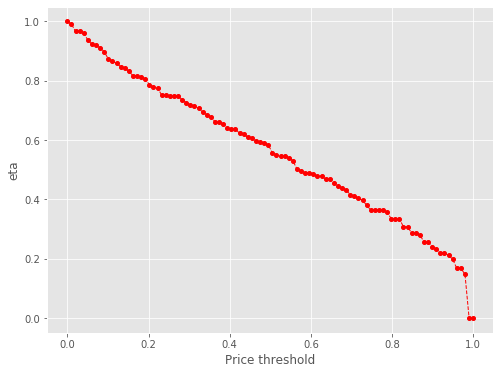

355 166
Number of cells with price above 14.000000000000002th percentile:  166


eta =  1.0
eta =  0.975523902741978
eta =  0.975523902741978
eta =  0.9691448491144857
eta =  0.9460557983470788
eta =  0.9316297263648665
eta =  0.9277424952784553
eta =  0.9203707304587452
eta =  0.9061341890517227
eta =  0.8813569303049477
eta =  0.8739616435311169
eta =  0.8667817058633
eta =  0.855633190291639
eta =  0.8513637356906281
eta =  0.8395359691628419
eta =  0.8283028390937242
eta =  0.8247718889870227
eta =  0.8206866558751589
eta =  0.8130351472846646
eta =  0.7983564212836248
eta =  0.786660806653443
eta =  0.7830362875328104
eta =  0.7626961730750625
eta =  0.7589158065827255
eta =  0.754913638303706
eta =  0.754913638303706
eta =  0.754913638303706
eta =  0.743525297658731
eta =  0.73634134599089
eta =  0.7252705219681057
eta =  0.7211617983433698
eta =  0.7174619905356947
eta =  0.7009940638355289
eta =  0.6970724038196274
eta =  0.6848138346238312
eta =  0.6724030586895723
eta =  0.6686788375202508
eta =  0.6649180733505776
eta =  0.6516485746457031
eta =  0.64306

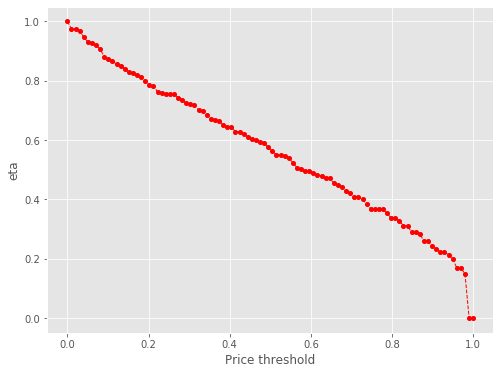

355 159
Number of cells with price above 15.000000000000002th percentile:  159


eta =  1.0
eta =  0.979788554733319
eta =  0.9550045096242801
eta =  0.9510197471028441
eta =  0.9469840967398184
eta =  0.9319520988224271
eta =  0.9252121412365014
eta =  0.8999914932186461
eta =  0.8919670102992315
eta =  0.8885294388245862
eta =  0.8727246285792039
eta =  0.8727246285792039
eta =  0.8527690306726283
eta =  0.8454655869208071
eta =  0.8454655869208071
eta =  0.8370493924833864
eta =  0.8290107833817764
eta =  0.814610567845981
eta =  0.8063982896188567
eta =  0.802682830560965
eta =  0.7818323784084587
eta =  0.7779571617359493
eta =  0.7738545782238792
eta =  0.7738545782238792
eta =  0.7738545782238792
eta =  0.7621805017476752
eta =  0.7548163032409563
eta =  0.7434677099449164
eta =  0.7392558975913829
eta =  0.7354632608376593
eta =  0.7228569814924084
eta =  0.7145620951576008
eta =  0.7019959559155585
eta =  0.6976797924533511
eta =  0.685456128384702
eta =  0.685456128384702
eta =  0.6679985726788096
eta =  0.6633202322143079
eta =  0.6592025510877658
eta = 

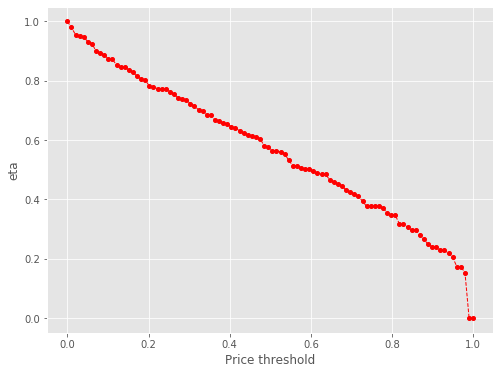

355 159
Number of cells with price above 16.0th percentile:  159


eta =  1.0
eta =  0.979788554733319
eta =  0.9550045096242801
eta =  0.9510197471028441
eta =  0.9469840967398184
eta =  0.9319520988224271
eta =  0.9252121412365014
eta =  0.8999914932186461
eta =  0.8919670102992315
eta =  0.8885294388245862
eta =  0.8727246285792039
eta =  0.8727246285792039
eta =  0.8527690306726283
eta =  0.8454655869208071
eta =  0.8454655869208071
eta =  0.8370493924833864
eta =  0.8290107833817764
eta =  0.814610567845981
eta =  0.8063982896188567
eta =  0.802682830560965
eta =  0.7818323784084587
eta =  0.7779571617359493
eta =  0.7738545782238792
eta =  0.7738545782238792
eta =  0.7738545782238792
eta =  0.7621805017476752
eta =  0.7548163032409563
eta =  0.7434677099449164
eta =  0.7392558975913829
eta =  0.7354632608376593
eta =  0.7228569814924084
eta =  0.7145620951576008
eta =  0.7019959559155585
eta =  0.6976797924533511
eta =  0.685456128384702
eta =  0.685456128384702
eta =  0.6679985726788096
eta =  0.6633202322143079
eta =  0.6592025510877658
eta = 

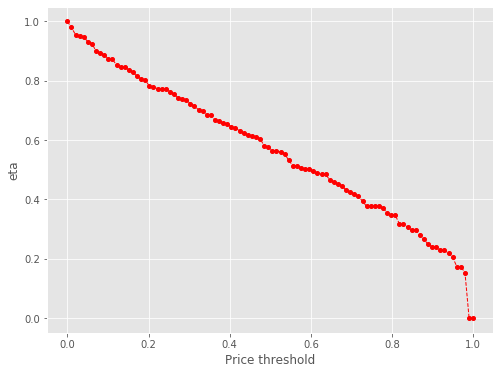

355 155
Number of cells with price above 17.0th percentile:  155


eta =  1.0
eta =  0.9754719311385621
eta =  0.9679451205115924
eta =  0.963906363207149
eta =  0.9445803423070781
eta =  0.9414557543624773
eta =  0.9157126656386195
eta =  0.9080291068760152
eta =  0.9005692916356212
eta =  0.8889862013335944
eta =  0.8845503212501848
eta =  0.8722615024489724
eta =  0.8605904993339255
eta =  0.8569219110205327
eta =  0.8526774334723438
eta =  0.8447276652381122
eta =  0.8294767551330081
eta =  0.8173252395766712
eta =  0.8135594348822393
eta =  0.7967548873238267
eta =  0.7884987254831022
eta =  0.7843405506766168
eta =  0.7843405506766168
eta =  0.7843405506766168
eta =  0.7801426196985944
eta =  0.7689389682693192
eta =  0.7611681165338047
eta =  0.7535419307938457
eta =  0.7492730470608073
eta =  0.7415190820183196
eta =  0.7283191641433869
eta =  0.7158132081791092
eta =  0.7071335726471552
eta =  0.6947442740932911
eta =  0.6947442740932911
eta =  0.6863881888960675
eta =  0.6723084295811916
eta =  0.668134952582819
eta =  0.668134952582819
eta 

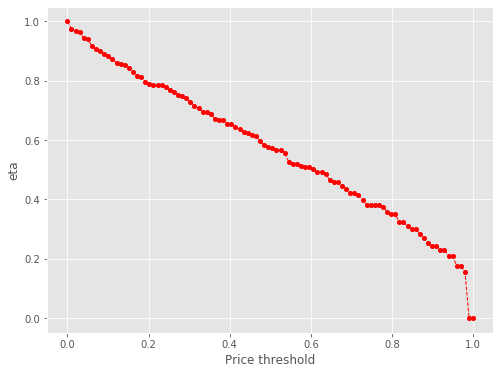

355 148
Number of cells with price above 18.000000000000004th percentile:  148


eta =  1.0
eta =  0.9922839290535151
eta =  0.988143617912292
eta =  0.9683316476411292
eta =  0.9651284924863175
eta =  0.9387380983579998
eta =  0.9308613378717846
eta =  0.9232139468989997
eta =  0.9113396018437738
eta =  0.9067921823416749
eta =  0.8941943633692017
eta =  0.8822298949488501
eta =  0.8784690606323661
eta =  0.8741178564483207
eta =  0.8659681927004845
eta =  0.8541966284790339
eta =  0.8378767379013116
eta =  0.8340162427151132
eta =  0.8209650851554655
eta =  0.8083253862187234
eta =  0.8083253862187234
eta =  0.8040626548435295
eta =  0.8040626548435295
eta =  0.7997591676349097
eta =  0.7919328707879166
eta =  0.7803075539501951
eta =  0.7724896091211135
eta =  0.7681133850630254
eta =  0.7601644479434945
eta =  0.746632620472533
eta =  0.7424556388897591
eta =  0.7293989696337857
eta =  0.716180184146228
eta =  0.7122134957613714
eta =  0.7082078852264995
eta =  0.6940744694081569
eta =  0.6892135059144954
eta =  0.6849350875765106
eta =  0.6739841774577697
eta 

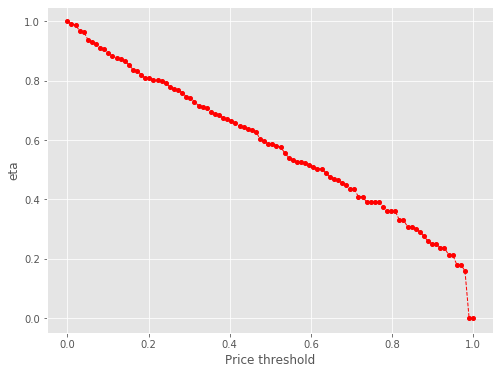

355 145
Number of cells with price above 19.0th percentile:  145


eta =  1.0
eta =  0.9799503129787747
eta =  0.9767087243101362
eta =  0.9500016812751632
eta =  0.9420304103551961
eta =  0.9342912610714695
eta =  0.9222744399940704
eta =  0.9176724576307106
eta =  0.9090352731190526
eta =  0.892815456130545
eta =  0.8890094969073
eta =  0.8890094969073
eta =  0.8801598442443984
eta =  0.8717072236483502
eta =  0.8479301214043583
eta =  0.844023305516244
eta =  0.8308155517818004
eta =  0.8180241936152146
eta =  0.8180241936152146
eta =  0.8137103152498408
eta =  0.8137103152498408
eta =  0.8137103152498408
eta =  0.8014349902507885
eta =  0.7936915143354324
eta =  0.7817584358366821
eta =  0.7817584358366821
eta =  0.7773297030302769
eta =  0.760086195575325
eta =  0.7513640987313037
eta =  0.7381507671676603
eta =  0.7336123088702841
eta =  0.7207590909367061
eta =  0.7207590909367061
eta =  0.712090110716033
eta =  0.6974831324323447
eta =  0.6931533788819204
eta =  0.6931533788819204
eta =  0.6777064225524153
eta =  0.6777064225524153
eta =  0.67

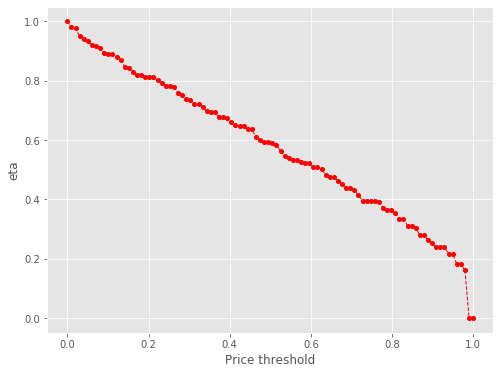

355 144
Number of cells with price above 20.0th percentile:  144


eta =  1.0
eta =  0.9808710486104095
eta =  0.9687794675279434
eta =  0.9460449501775852
eta =  0.9419028401532885
eta =  0.9382728198747222
eta =  0.9215831940406732
eta =  0.9215831940406732
eta =  0.9005104030875024
eta =  0.8927980837603197
eta =  0.8927980837603197
eta =  0.888375905528147
eta =  0.8800933096993065
eta =  0.8642039000082624
eta =  0.8515436451309409
eta =  0.8476201800266346
eta =  0.8301120877889858
eta =  0.821510270778804
eta =  0.821510270778804
eta =  0.8171780084671199
eta =  0.8171780084671199
eta =  0.8128043255390301
eta =  0.8048503711642397
eta =  0.7930354296245196
eta =  0.7850899635003927
eta =  0.7806423572860607
eta =  0.7766373937742336
eta =  0.7588112122594016
eta =  0.7545660984356795
eta =  0.7412964571763344
eta =  0.7367386578668563
eta =  0.7238306648913339
eta =  0.7238306648913339
eta =  0.7053957663898769
eta =  0.7004555139816182
eta =  0.696107308831481
eta =  0.696107308831481
eta =  0.6805945240312197
eta =  0.6761014006254216
eta = 

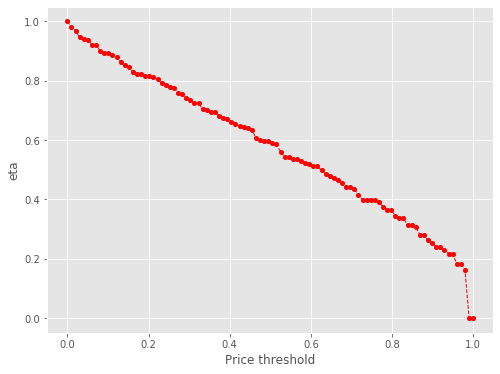

355 139
Number of cells with price above 21.000000000000004th percentile:  139


eta =  1.0
eta =  0.9726560822379909
eta =  0.964494722846431
eta =  0.9565710204251254
eta =  0.9442676378727818
eta =  0.9395559134366044
eta =  0.9307127606146015
eta =  0.9141061545868281
eta =  0.9102094358123201
eta =  0.9102094358123201
eta =  0.901148748175735
eta =  0.8924945605088659
eta =  0.8769916089267102
eta =  0.8681504529441608
eta =  0.864150472406592
eta =  0.8417033396270266
eta =  0.8375313675968208
eta =  0.8331146174869856
eta =  0.8331146174869856
eta =  0.8331146174869856
eta =  0.8286556389757065
eta =  0.8167552906296899
eta =  0.8085012099684307
eta =  0.8004007913299327
eta =  0.7958664478801665
eta =  0.7876303040077032
eta =  0.7736095517697277
eta =  0.7692816497180398
eta =  0.7557532238580411
eta =  0.7468376119365131
eta =  0.7379468136171189
eta =  0.7379468136171189
eta =  0.7191523976461577
eta =  0.7141158004142815
eta =  0.7096827965486895
eta =  0.7096827965486895
eta =  0.6938674813528356
eta =  0.6892867330351404
eta =  0.6844667171984548
eta 

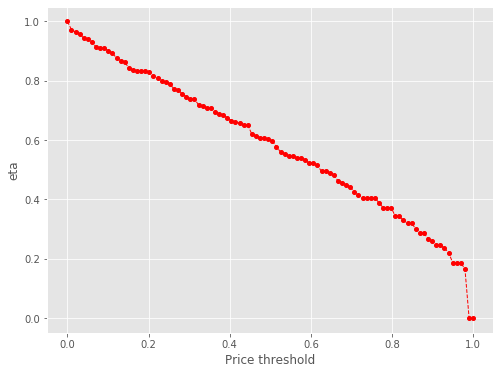

355 132
Number of cells with price above 22.0th percentile:  132


eta =  1.0
eta =  0.9916092033550221
eta =  0.9834627448420872
eta =  0.9708134818836582
eta =  0.965969298495285
eta =  0.9525493478247957
eta =  0.9398040800645127
eta =  0.9357978142880812
eta =  0.9357978142880812
eta =  0.9264824069184616
eta =  0.9175849273006335
eta =  0.8966534180765761
eta =  0.8884440124183075
eta =  0.8788282677074319
eta =  0.8653658317648574
eta =  0.8610765746405854
eta =  0.8565356580818028
eta =  0.8565356580818028
eta =  0.8565356580818028
eta =  0.8519513259702721
eta =  0.8397164275685318
eta =  0.8312303030153729
eta =  0.8229021603281246
eta =  0.8182403445716928
eta =  0.809772661057585
eta =  0.7953577486399142
eta =  0.7909081778916084
eta =  0.7769994324398029
eta =  0.7722221163709677
eta =  0.7586924372273209
eta =  0.7586924372273209
eta =  0.7447259136880876
eta =  0.7341914716362721
eta =  0.7296338443859576
eta =  0.7296338443859576
eta =  0.713373919131119
eta =  0.713373919131119
eta =  0.7037088747993645
eta =  0.6942818114136687
eta =

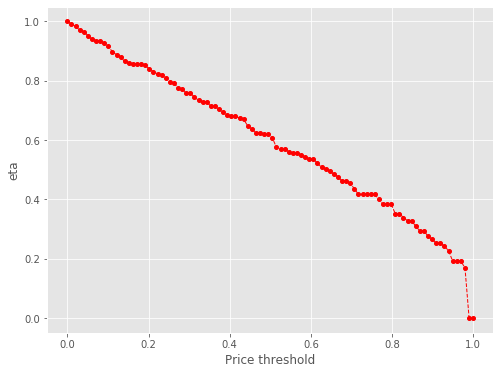

355 130
Number of cells with price above 23.0th percentile:  130


eta =  1.0
eta =  0.9917846078017709
eta =  0.9790283093369814
eta =  0.9741431354479297
eta =  0.9649744457573269
eta =  0.9477565122275677
eta =  0.943716346239922
eta =  0.943716346239922
eta =  0.9343221137760626
eta =  0.9253493454841545
eta =  0.9092756944677931
eta =  0.9001090751249134
eta =  0.8959618460703428
eta =  0.8726883825169922
eta =  0.8683628305659215
eta =  0.8637834896890731
eta =  0.8637834896890731
eta =  0.8637834896890731
eta =  0.8591603658858451
eta =  0.8507527797840458
eta =  0.8382640058230386
eta =  0.829865392075737
eta =  0.8251641289766662
eta =  0.8209307534789424
eta =  0.806859510287711
eta =  0.7976006830267816
eta =  0.7835742445823354
eta =  0.7787565038305639
eta =  0.7651123392767555
eta =  0.7651123392767555
eta =  0.7559098972691728
eta =  0.7456260574695365
eta =  0.7358078584963773
eta =  0.7358078584963773
eta =  0.7194103450406485
eta =  0.7194103450406485
eta =  0.7146609688033411
eta =  0.7048479433544742
eta =  0.7001566837667779
eta =

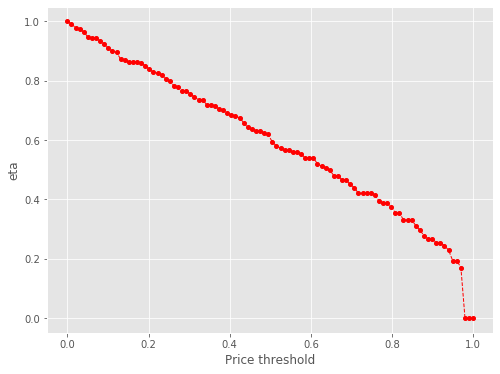

355 128
Number of cells with price above 24.000000000000004th percentile:  128


eta =  1.0
eta =  0.9822123954989154
eta =  0.9822123954989154
eta =  0.9597532658014523
eta =  0.9515335676882611
eta =  0.9515335676882611
eta =  0.9468204627804977
eta =  0.9379929707617622
eta =  0.9330144249114067
eta =  0.9075650781876413
eta =  0.9033834957936953
eta =  0.8892468402508652
eta =  0.875555865391573
eta =  0.875555865391573
eta =  0.8709385918012941
eta =  0.8709385918012941
eta =  0.8709385918012941
eta =  0.8662771726112192
eta =  0.8577999427412839
eta =  0.8452077187213046
eta =  0.8367395355278623
eta =  0.8319993297794683
eta =  0.8277308873531366
eta =  0.8135430858077793
eta =  0.8042075635702938
eta =  0.79006493790933
eta =  0.7852072896721289
eta =  0.7714501044461454
eta =  0.7714501044461454
eta =  0.7671113370907274
eta =  0.7518024091159979
eta =  0.7419028816420632
eta =  0.7419028816420632
eta =  0.7300411564639243
eta =  0.7253695403028858
eta =  0.7205808228737718
eta =  0.7106865117787279
eta =  0.7059563924052338
eta =  0.6961386439166001
eta =

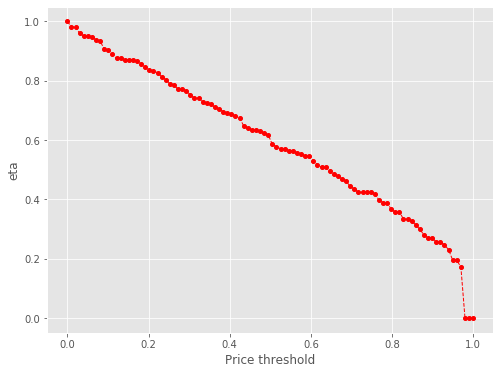

355 124
Number of cells with price above 25.0th percentile:  124


eta =  1.0
eta =  0.9771341414541455
eta =  0.9687655868005302
eta =  0.9687655868005302
eta =  0.9639671288199939
eta =  0.954979773275319
eta =  0.9499110672875204
eta =  0.9240008396825853
eta =  0.9197435299468207
eta =  0.9097890265005371
eta =  0.8958523144709255
eta =  0.8914119485804635
eta =  0.8867110573970106
eta =  0.8867110573970106
eta =  0.8867110573970106
eta =  0.8819652211487243
eta =  0.8733344709069405
eta =  0.8648963012190886
eta =  0.8518926653362382
eta =  0.8518926653362382
eta =  0.847066615726076
eta =  0.8282761340988164
eta =  0.8233778753412383
eta =  0.8135056908800032
eta =  0.8043728032041543
eta =  0.7897952784471345
eta =  0.785420860072008
eta =  0.785420860072008
eta =  0.765417350219979
eta =  0.7600567355297325
eta =  0.7553385449439509
eta =  0.7553385449439509
eta =  0.7385057892029899
eta =  0.7385057892029899
eta =  0.7336303493785092
eta =  0.7235568549486022
eta =  0.7141365372387357
eta =  0.7087455290797833
eta =  0.7037260204336889
eta = 

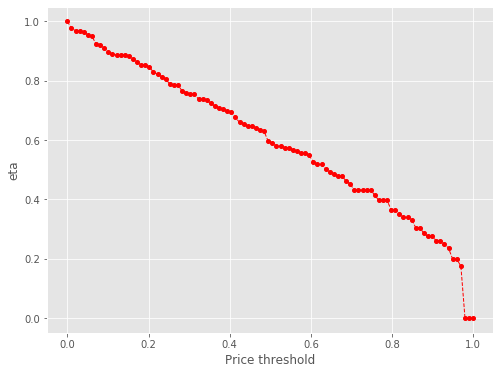

355 123
Number of cells with price above 26.0th percentile:  123


eta =  1.0
eta =  0.9776406108001557
eta =  0.9734730526848203
eta =  0.9734730526848203
eta =  0.9637826068314016
eta =  0.959620250563254
eta =  0.9422950429506298
eta =  0.9284907828526628
eta =  0.9242127858210106
eta =  0.9097501817749271
eta =  0.8957435344604389
eta =  0.8957435344604389
eta =  0.891019800511746
eta =  0.891019800511746
eta =  0.891019800511746
eta =  0.8862509030992982
eta =  0.8735234274474217
eta =  0.8646956513529542
eta =  0.8560322174774241
eta =  0.8511827169270084
eta =  0.846815857133438
eta =  0.8323009278127624
eta =  0.8227501566791585
eta =  0.8082814448620811
eta =  0.8033117939544145
eta =  0.7892374096625129
eta =  0.7892374096625129
eta =  0.784798603459775
eta =  0.7691366979264808
eta =  0.7637500347151917
eta =  0.7590089173021973
eta =  0.7590089173021973
eta =  0.7420943671370033
eta =  0.7371952363732929
eta =  0.7320402079304819
eta =  0.7222336107875851
eta =  0.7121894947245634
eta =  0.7071455950740514
eta =  0.7071455950740514
eta =  

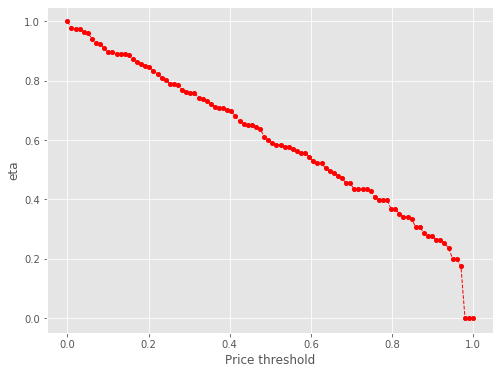

355 118
Number of cells with price above 27.0th percentile:  118


eta =  1.0
eta =  0.995737126640101
eta =  0.995737126640101
eta =  0.981567500329029
eta =  0.9763576757803031
eta =  0.959397991716954
eta =  0.9497260778607939
eta =  0.9453502397620156
eta =  0.9207938655740402
eta =  0.9162298748282481
eta =  0.9162298748282481
eta =  0.9113981054679035
eta =  0.9113981054679035
eta =  0.9113981054679035
eta =  0.8976490995397876
eta =  0.8889760015751574
eta =  0.8801028629706634
eta =  0.8756103296249114
eta =  0.8706499172843821
eta =  0.8616398654089673
eta =  0.8463016553251365
eta =  0.8415670826171734
eta =  0.8267674602843454
eta =  0.8216841496559142
eta =  0.8072878734206396
eta =  0.8072878734206396
eta =  0.8027475483219257
eta =  0.7867274430191441
eta =  0.7812175826964634
eta =  0.7763680322986808
eta =  0.7763680322986808
eta =  0.7590666334223082
eta =  0.7540554557875119
eta =  0.7487825278977918
eta =  0.7387516463708158
eta =  0.7284778136841795
eta =  0.7233185561873129
eta =  0.7233185561873129
eta =  0.7182302221667471
eta =

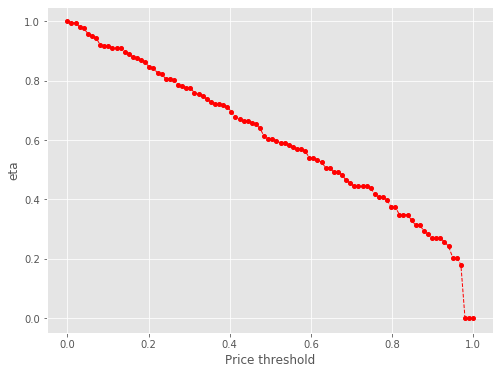

355 117
Number of cells with price above 28.000000000000004th percentile:  117


eta =  1.0
eta =  0.9857697117723386
eta =  0.980537583322629
eta =  0.963505292761589
eta =  0.9537919722501849
eta =  0.9493974006492005
eta =  0.9247358975968482
eta =  0.9201523678441792
eta =  0.9201523678441792
eta =  0.915299913083706
eta =  0.915299913083706
eta =  0.915299913083706
eta =  0.9062088248527537
eta =  0.8973267673288547
eta =  0.8882584360893606
eta =  0.879358925361625
eta =  0.8743772768845142
eta =  0.8698914210290011
eta =  0.8549809627675796
eta =  0.8451699350177482
eta =  0.8303069536777172
eta =  0.8303069536777172
eta =  0.8107439723018639
eta =  0.8107439723018639
eta =  0.8107439723018639
eta =  0.7900955201638261
eta =  0.7845620714500349
eta =  0.7796917595293111
eta =  0.7796917595293111
eta =  0.7623162912320182
eta =  0.7623162912320182
eta =  0.7572836601281591
eta =  0.7468853815691776
eta =  0.7419143332172148
eta =  0.7315965169866369
eta =  0.7264151720725676
eta =  0.7213050542669422
eta =  0.7158314409405497
eta =  0.7158314409405497
eta =  

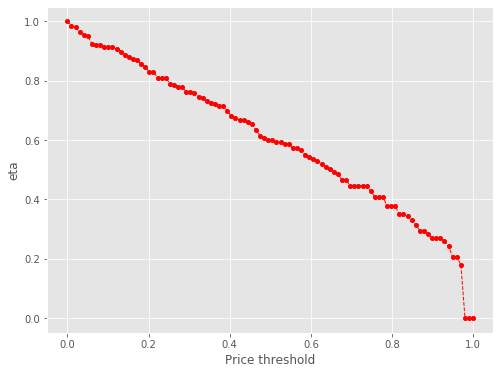

355 116
Number of cells with price above 29.000000000000004th percentile:  116


eta =  1.0
eta =  0.9906766991570798
eta =  0.9727907911848259
eta =  0.958539780099834
eta =  0.9541233330981858
eta =  0.9391926719025929
eta =  0.9293390694427012
eta =  0.9247327236890887
eta =  0.919856114266517
eta =  0.919856114266517
eta =  0.919856114266517
eta =  0.9149328797428505
eta =  0.9059795140276223
eta =  0.8972259274834616
eta =  0.8837362186603316
eta =  0.8837362186603316
eta =  0.8787297724176368
eta =  0.8696361049437464
eta =  0.8541555523258838
eta =  0.8493770415656235
eta =  0.8344400749315992
eta =  0.8293095898732855
eta =  0.8147797124923264
eta =  0.8147797124923264
eta =  0.810197252009083
eta =  0.794028476009278
eta =  0.7884674827658584
eta =  0.7835729272932489
eta =  0.7835729272932489
eta =  0.7661109669859859
eta =  0.7661109669859859
eta =  0.7610532843340382
eta =  0.7506032449823457
eta =  0.7408307979473538
eta =  0.7352382751343076
eta =  0.7300311384010887
eta =  0.7248955833322696
eta =  0.719394723326231
eta =  0.719394723326231
eta =  0.

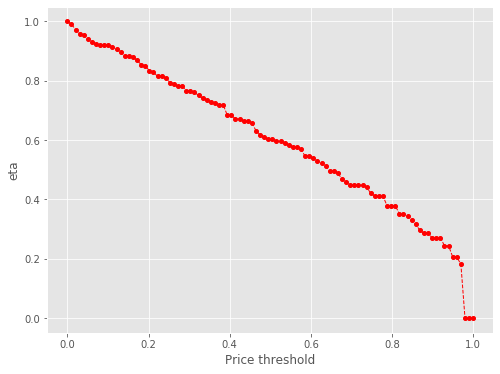

355 113
Number of cells with price above 30.0th percentile:  113


eta =  1.0
eta =  0.9727235227620602
eta =  0.9682417245365471
eta =  0.9682417245365471
eta =  0.9430907221968051
eta =  0.9384162152420209
eta =  0.9384162152420209
eta =  0.9334674454620495
eta =  0.9334674454620495
eta =  0.9334674454620495
eta =  0.9241959107594769
eta =  0.9151375557560906
eta =  0.9058892297421449
eta =  0.8968130751111526
eta =  0.8917325472845393
eta =  0.8871576529288202
eta =  0.8719512411450963
eta =  0.8619454770451768
eta =  0.8564019505562517
eta =  0.846787484538998
eta =  0.8367979425114872
eta =  0.8268362030087557
eta =  0.8268362030087557
eta =  0.8168913729264824
eta =  0.8001346249181845
eta =  0.7951676435361754
eta =  0.7951676435361754
eta =  0.7891626086936265
eta =  0.7774472944207291
eta =  0.772314772027446
eta =  0.7669141611442407
eta =  0.7566403836385134
eta =  0.7461177719548131
eta =  0.7461177719548131
eta =  0.7408335839724292
eta =  0.7356220368654744
eta =  0.7300397793166667
eta =  0.7244424076922233
eta =  0.6943973725308117
eta

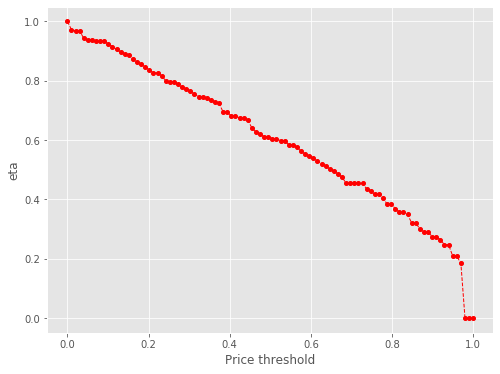

355 108
Number of cells with price above 31.0th percentile:  108


eta =  1.0
eta =  0.995430815210493
eta =  0.9908443937280933
eta =  0.9651062654968359
eta =  0.9603226366857475
eta =  0.9603226366857475
eta =  0.955258342648344
eta =  0.955258342648344
eta =  0.955258342648344
eta =  0.9501456290634624
eta =  0.9408476778278246
eta =  0.927036340081608
eta =  0.9177483113746933
eta =  0.9125491835261296
eta =  0.9125491835261296
eta =  0.8923061018739027
eta =  0.8870291827427004
eta =  0.8820667628616157
eta =  0.8665549216402423
eta =  0.8612269811310956
eta =  0.846137896685659
eta =  0.846137896685659
eta =  0.8413790724102285
eta =  0.824588013542786
eta =  0.8188129960081975
eta =  0.8137300652364717
eta =  0.8137300652364717
eta =  0.7955960516621767
eta =  0.7955960516621767
eta =  0.7903437154839329
eta =  0.77949148857922
eta =  0.7743034236159858
eta =  0.7635351717115735
eta =  0.7581276294573325
eta =  0.7527944238096957
eta =  0.7470818538424905
eta =  0.7470818538424905
eta =  0.7285694723127383
eta =  0.7106074094472702
eta =  0.70

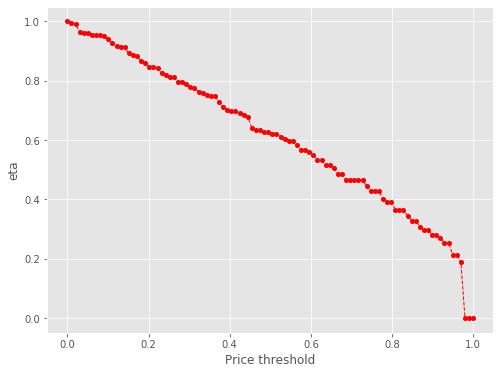

355 106
Number of cells with price above 32.0th percentile:  106


eta =  1.0
eta =  0.9740240461628726
eta =  0.9691962156363357
eta =  0.9691962156363357
eta =  0.964085126478987
eta =  0.964085126478987
eta =  0.964085126478987
eta =  0.958925170367569
eta =  0.9495413041475121
eta =  0.9356023467959436
eta =  0.9262284947908188
eta =  0.9262284947908188
eta =  0.9209813259301244
eta =  0.9114504118874274
eta =  0.8952255150833686
eta =  0.8902172414205249
eta =  0.8745620675914544
eta =  0.869184895814663
eta =  0.8539563851212095
eta =  0.8539563851212095
eta =  0.8491535883293488
eta =  0.8322073766196922
eta =  0.8263789967336641
eta =  0.8212490986347296
eta =  0.8212490986347296
eta =  0.802947523040135
eta =  0.802947523040135
eta =  0.7976466541938354
eta =  0.7866941504774032
eta =  0.7814581467253773
eta =  0.770590393955544
eta =  0.770590393955544
eta =  0.7651328848971388
eta =  0.7597503993308934
eta =  0.7539850440406328
eta =  0.7482040789338847
eta =  0.7171735682669407
eta =  0.7171735682669407
eta =  0.7034433075921812
eta =  0.7

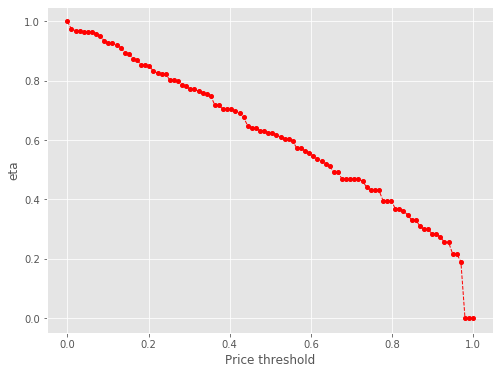

355 102
Number of cells with price above 33.0th percentile:  102


eta =  1.0
eta =  0.9896377644215579
eta =  0.9896377644215579
eta =  0.9844188760624892
eta =  0.9844188760624892
eta =  0.9844188760624892
eta =  0.9791500900847558
eta =  0.969568306501799
eta =  0.9602003241688342
eta =  0.9457638011168948
eta =  0.9457638011168948
eta =  0.9404059629649674
eta =  0.9306740301386347
eta =  0.9141069301622929
eta =  0.9089930258038719
eta =  0.8930076649658084
eta =  0.8930076649658084
eta =  0.8768238242238142
eta =  0.8719673831268571
eta =  0.8719673831268571
eta =  0.8559156177680363
eta =  0.843808353456568
eta =  0.8385702594520358
eta =  0.8385702594520358
eta =  0.8385702594520358
eta =  0.8198826809569679
eta =  0.8198826809569679
eta =  0.8144700102202178
eta =  0.8032865046329284
eta =  0.7979400670756421
eta =  0.786843099937401
eta =  0.781270485252433
eta =  0.7757744763980101
eta =  0.7698875226228106
eta =  0.7698875226228106
eta =  0.750810025986419
eta =  0.7322996472246214
eta =  0.7245452416451459
eta =  0.7182797983437909
eta = 

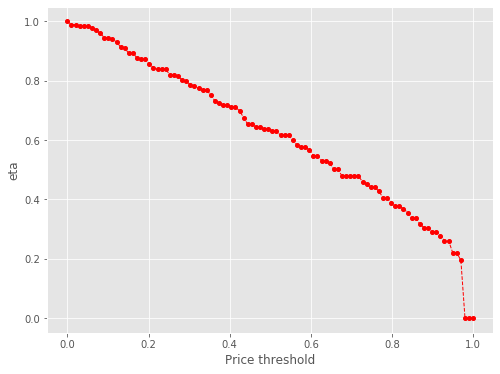

355 100
Number of cells with price above 34.0th percentile:  100


eta =  1.0
eta =  0.9947264660397038
eta =  0.9947264660397038
eta =  0.9947264660397038
eta =  0.9894025119959603
eta =  0.9797204000885218
eta =  0.9702543280874796
eta =  0.9556666440166545
eta =  0.9556666440166545
eta =  0.9502527053569277
eta =  0.9404188720330539
eta =  0.923678302329729
eta =  0.9185108516298154
eta =  0.9023581123015959
eta =  0.9023581123015959
eta =  0.8860048148388079
eta =  0.8810975232301498
eta =  0.8810975232301498
eta =  0.8705000613355803
eta =  0.8586572700072894
eta =  0.852643647799529
eta =  0.8473507070965295
eta =  0.8473507070965295
eta =  0.828467455904119
eta =  0.828467455904119
eta =  0.8229981105220601
eta =  0.8116975054023412
eta =  0.8062950867098702
eta =  0.7950819261604368
eta =  0.7894509620993341
eta =  0.7894509620993341
eta =  0.7838974059881894
eta =  0.7779488114752865
eta =  0.7719841110219808
eta =  0.7399673633641595
eta =  0.7399673633641595
eta =  0.7258007163496075
eta =  0.7258007163496075
eta =  0.7258007163496075
eta =

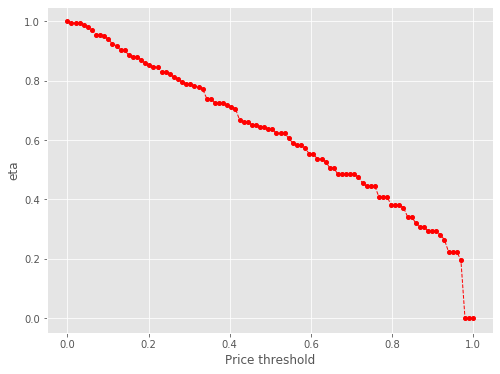

355 99
Number of cells with price above 35.0th percentile:  99


eta =  1.0
eta =  0.9849143795168881
eta =  0.9753981232150634
eta =  0.9704561569297644
eta =  0.9607331026603144
eta =  0.9552904620504981
eta =  0.9552904620504981
eta =  0.945404494742294
eta =  0.9285751750500434
eta =  0.9233803291538778
eta =  0.9071419562145026
eta =  0.9015644697155355
eta =  0.890701961883302
eta =  0.8857686543096174
eta =  0.8857686543096174
eta =  0.8751150100602983
eta =  0.8632094342737803
eta =  0.857163930898664
eta =  0.8518429297152209
eta =  0.8518429297152209
eta =  0.832859569126063
eta =  0.832859569126063
eta =  0.8273612280556438
eta =  0.8215756905851518
eta =  0.810569653303753
eta =  0.8053768262855806
eta =  0.7992970462783502
eta =  0.793636229708825
eta =  0.7880532314668509
eta =  0.7820731005303675
eta =  0.7820731005303675
eta =  0.7626936502777492
eta =  0.7438902940927925
eta =  0.7360131538143657
eta =  0.7296485427187153
eta =  0.7296485427187153
eta =  0.7232380964113122
eta =  0.7232380964113122
eta =  0.7164535621985898
eta =  0

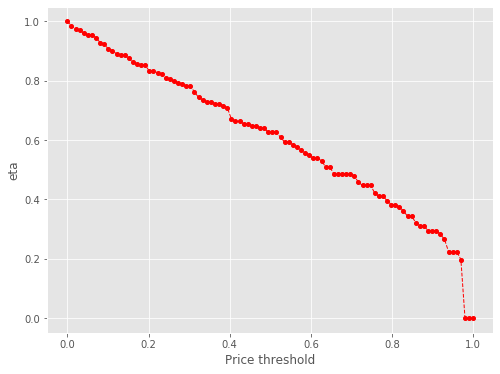

355 99
Number of cells with price above 36.00000000000001th percentile:  99


eta =  1.0
eta =  0.9849143795168881
eta =  0.9753981232150634
eta =  0.9704561569297644
eta =  0.9607331026603144
eta =  0.9552904620504981
eta =  0.9552904620504981
eta =  0.945404494742294
eta =  0.9285751750500434
eta =  0.9233803291538778
eta =  0.9071419562145026
eta =  0.9015644697155355
eta =  0.890701961883302
eta =  0.8857686543096174
eta =  0.8857686543096174
eta =  0.8751150100602983
eta =  0.8632094342737803
eta =  0.857163930898664
eta =  0.8518429297152209
eta =  0.8518429297152209
eta =  0.832859569126063
eta =  0.832859569126063
eta =  0.8273612280556438
eta =  0.8215756905851518
eta =  0.810569653303753
eta =  0.8053768262855806
eta =  0.7992970462783502
eta =  0.793636229708825
eta =  0.7880532314668509
eta =  0.7820731005303675
eta =  0.7820731005303675
eta =  0.7626936502777492
eta =  0.7438902940927925
eta =  0.7360131538143657
eta =  0.7296485427187153
eta =  0.7296485427187153
eta =  0.7232380964113122
eta =  0.7232380964113122
eta =  0.7164535621985898
eta =  0

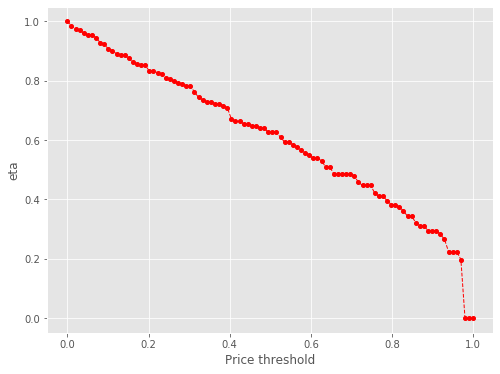

355 98
Number of cells with price above 37.0th percentile:  98


eta =  1.0
eta =  0.9902141830144474
eta =  0.9806467199382258
eta =  0.965902787217258
eta =  0.965902787217258
eta =  0.9604308598731429
eta =  0.9555035195699634
eta =  0.9391256188311145
eta =  0.9283490192246102
eta =  0.9223784241973223
eta =  0.9120232679430272
eta =  0.9064157691068768
eta =  0.8905349567515018
eta =  0.8905349567515018
eta =  0.8855264358154836
eta =  0.867854346028581
eta =  0.8617763119273446
eta =  0.8564266785487898
eta =  0.8564266785487898
eta =  0.8427339188257279
eta =  0.8373411688967913
eta =  0.8373411688967913
eta =  0.8318132413690702
eta =  0.820391595494206
eta =  0.8149313115076892
eta =  0.8035980468216996
eta =  0.7979067695176393
eta =  0.7979067695176393
eta =  0.792293729279909
eta =  0.7862814193850185
eta =  0.7862814193850185
eta =  0.754419785207424
eta =  0.7478931520715411
eta =  0.7399736250674591
eta =  0.7335747661337765
eta =  0.7335747661337765
eta =  0.7271298253500337
eta =  0.7271298253500337
eta =  0.7131126227726302
eta =  

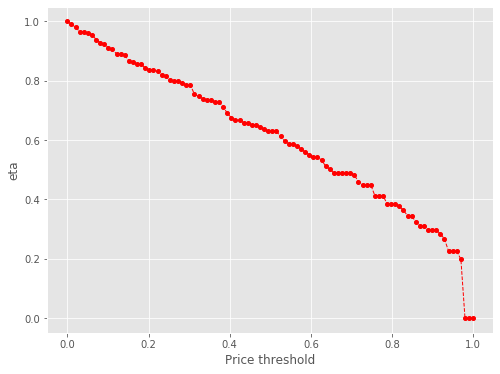

355 96
Number of cells with price above 38.0th percentile:  96


eta =  1.0
eta =  0.9853203254132449
eta =  0.97544834621215
eta =  0.97544834621215
eta =  0.9699223424061277
eta =  0.9649463075363993
eta =  0.9484065517746805
eta =  0.9375234521469841
eta =  0.9314938525616581
eta =  0.9210363612108762
eta =  0.9153734461240817
eta =  0.8993356912344981
eta =  0.8993356912344981
eta =  0.894277673462251
eta =  0.8764309387961159
eta =  0.8702928383674455
eta =  0.8648903371002256
eta =  0.8648903371002256
eta =  0.8648903371002256
eta =  0.8456162144110335
eta =  0.8456162144110335
eta =  0.8400336569981586
eta =  0.82849913641586
eta =  0.8229848910332153
eta =  0.8115396250691502
eta =  0.8057921035715944
eta =  0.8057921035715944
eta =  0.8001235923201772
eta =  0.7940518656190027
eta =  0.7940518656190027
eta =  0.7743755864868773
eta =  0.755284225272129
eta =  0.7472864333399099
eta =  0.7408243375191824
eta =  0.7408243375191824
eta =  0.7343157044433333
eta =  0.7343157044433333
eta =  0.7274272536766277
eta =  0.7122931076808642
eta =  0.

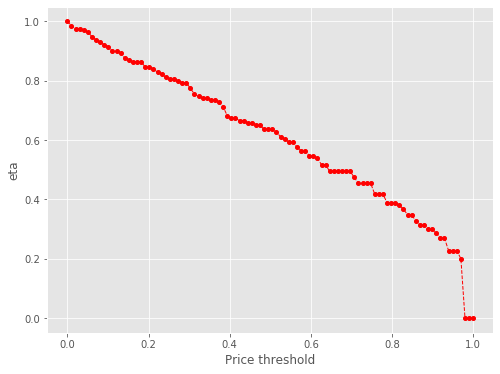

355 92
Number of cells with price above 39.0th percentile:  92


eta =  1.0
eta =  0.9948954451408235
eta =  0.9892592717465158
eta =  0.9841840317853441
eta =  0.9673145299455236
eta =  0.961594026030735
eta =  0.9562144585879224
eta =  0.9393986715299485
eta =  0.933622857312877
eta =  0.9172653645231342
eta =  0.9172653645231342
eta =  0.9172653645231342
eta =  0.9062328913956356
eta =  0.8939039697742334
eta =  0.8876434966471684
eta =  0.8821332880092672
eta =  0.8821332880092672
eta =  0.8680295247111725
eta =  0.8624749053311627
eta =  0.8567810508447884
eta =  0.8507897876509363
eta =  0.8450165714299901
eta =  0.8393923908817471
eta =  0.827718945516556
eta =  0.8218568381266854
eta =  0.8218568381266854
eta =  0.8160753161766365
eta =  0.8098825400418511
eta =  0.8098825400418511
eta =  0.7832617394432967
eta =  0.7703420057329502
eta =  0.7621847652235503
eta =  0.7555938373460561
eta =  0.7555938373460561
eta =  0.7489554444199719
eta =  0.7489554444199719
eta =  0.741929661539223
eta =  0.726493792509612
eta =  0.6959179462531851
eta = 

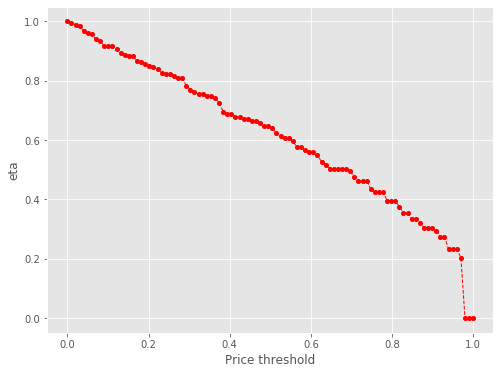

355 91
Number of cells with price above 40.0th percentile:  91


eta =  1.0
eta =  0.9943349088370689
eta =  0.9840448841873204
eta =  0.9665277197993655
eta =  0.9611205511676396
eta =  0.9549391889163834
eta =  0.9442184865938152
eta =  0.938413038146663
eta =  0.9219716192321082
eta =  0.9219716192321082
eta =  0.9167862931285905
eta =  0.8984903631232373
eta =  0.8921977691047986
eta =  0.8866592889913217
eta =  0.8866592889913217
eta =  0.8866592889913217
eta =  0.8669000441640204
eta =  0.8669000441640204
eta =  0.8611769759620463
eta =  0.8551549731243471
eta =  0.843699099218345
eta =  0.8382940319798026
eta =  0.8319657603813793
eta =  0.8260735760131607
eta =  0.8260735760131607
eta =  0.8202623905481086
eta =  0.8140378408579562
eta =  0.8077964380731566
eta =  0.7810514631403941
eta =  0.7742944341492198
eta =  0.766095340918629
eta =  0.7594705966706932
eta =  0.7594705966706932
eta =  0.7527981438431053
eta =  0.7527981438431053
eta =  0.7457363134617687
eta =  0.7217927353553572
eta =  0.6994885237962675
eta =  0.690748943666456
eta =

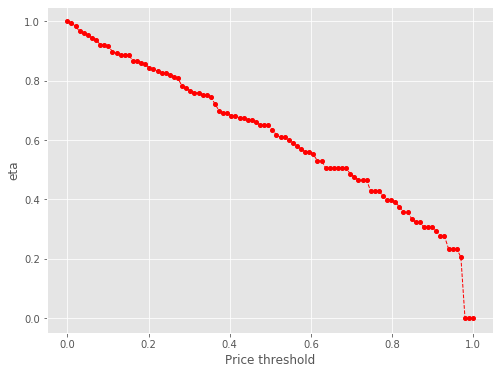

355 89
Number of cells with price above 41.0th percentile:  89


eta =  1.0
eta =  0.9828594030232144
eta =  0.971580952043406
eta =  0.9653323146443779
eta =  0.9544949330521514
eta =  0.9486263007328544
eta =  0.9320059408596407
eta =  0.9320059408596407
eta =  0.9320059408596407
eta =  0.9207961744224783
eta =  0.9082691253917831
eta =  0.9019080456293851
eta =  0.8963092872062216
eta =  0.8963092872062216
eta =  0.8819788745571666
eta =  0.8763349917053654
eta =  0.8763349917053654
eta =  0.8705496362205326
eta =  0.8585961000577306
eta =  0.8528815381804763
eta =  0.8410204989965596
eta =  0.8410204989965596
eta =  0.835064186761706
eta =  0.8291897549854039
eta =  0.8228974601149502
eta =  0.8228974601149502
eta =  0.802506398997404
eta =  0.7827215041637314
eta =  0.7827215041637314
eta =  0.7677363307504417
eta =  0.7677363307504417
eta =  0.7677363307504417
eta =  0.7609912579676188
eta =  0.7609912579676188
eta =  0.7463212936081866
eta =  0.7225839740067892
eta =  0.7071014401552174
eta =  0.6982667423926254
eta =  0.6982667423926254
eta 

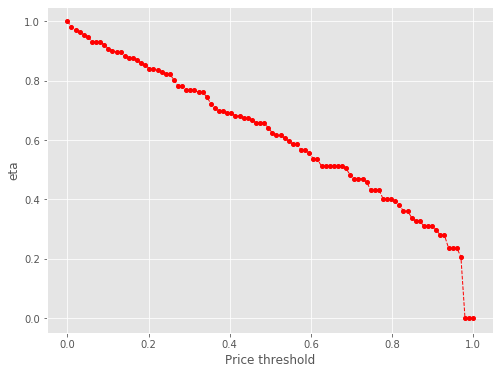

355 85
Number of cells with price above 42.00000000000001th percentile:  85


eta =  1.0
eta =  0.9944055731450223
eta =  0.9769181651508336
eta =  0.9709116654631089
eta =  0.953900855966649
eta =  0.953900855966649
eta =  0.953900855966649
eta =  0.9485359543737655
eta =  0.9296064093327281
eta =  0.9230958935042272
eta =  0.9173656076572506
eta =  0.9173656076572506
eta =  0.9173656076572506
eta =  0.8969220710441433
eta =  0.8969220710441433
eta =  0.8910008045509671
eta =  0.8787664529469333
eta =  0.8729176431623527
eta =  0.8673253904749033
eta =  0.8607779614992118
eta =  0.8546817220975714
eta =  0.8546817220975714
eta =  0.848669286710557
eta =  0.8422291716857706
eta =  0.8422291716857706
eta =  0.814545138842472
eta =  0.8011093921961701
eta =  0.7926263522764325
eta =  0.7857721833661906
eta =  0.7857721833661906
eta =  0.7857721833661906
eta =  0.7788686536578311
eta =  0.7715622616768515
eta =  0.7638540588511119
eta =  0.7395590962404208
eta =  0.7237128428571808
eta =  0.7146705981798883
eta =  0.7146705981798883
eta =  0.7058313883341296
eta = 

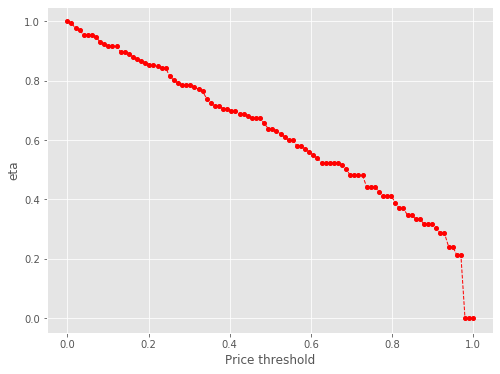

355 83
Number of cells with price above 43.0th percentile:  83


eta =  1.0
eta =  0.9887734188239427
eta =  0.9826940280998695
eta =  0.9654767863054348
eta =  0.9654767863054348
eta =  0.9654767863054348
eta =  0.9538644469409413
eta =  0.9408875178144052
eta =  0.9342979945322167
eta =  0.9284981696032999
eta =  0.9284981696032999
eta =  0.9136531132101197
eta =  0.9078065433127053
eta =  0.9078065433127053
eta =  0.9018134201186846
eta =  0.8894306002529624
eta =  0.8835108130557842
eta =  0.8778506963684842
eta =  0.8712238119847735
eta =  0.8650535925230455
eta =  0.8650535925230455
eta =  0.8589681940678346
eta =  0.8524499259284616
eta =  0.8524499259284616
eta =  0.8244299373789844
eta =  0.8108311431095943
eta =  0.8022451584461154
eta =  0.795307811728307
eta =  0.795307811728307
eta =  0.795307811728307
eta =  0.7883205052013234
eta =  0.7883205052013234
eta =  0.7731237028806256
eta =  0.748533912151262
eta =  0.732495358777779
eta =  0.7233433832056708
eta =  0.7233433832056708
eta =  0.7143969063658798
eta =  0.7143969063658798
eta = 

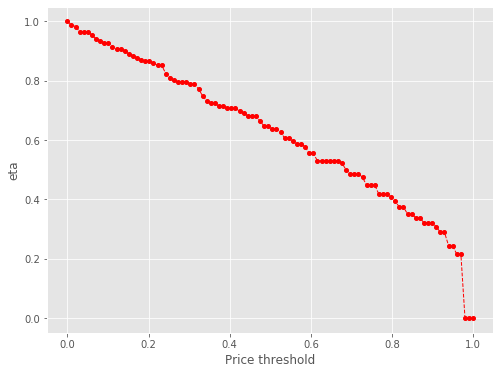

355 80
Number of cells with price above 44.0th percentile:  80


eta =  1.0
eta =  0.9824795497864927
eta =  0.9824795497864927
eta =  0.9824795497864927
eta =  0.9643934017169858
eta =  0.9574572460094205
eta =  0.9507516763267291
eta =  0.9448497121719949
eta =  0.9448497121719949
eta =  0.9297432233070074
eta =  0.9237936909701526
eta =  0.9237936909701526
eta =  0.9176950244242604
eta =  0.9050941339012301
eta =  0.8990700948535676
eta =  0.8933102993063775
eta =  0.8865667105654096
eta =  0.880287828954967
eta =  0.880287828954967
eta =  0.8740952621119817
eta =  0.8674622024281077
eta =  0.8674622024281077
eta =  0.8459668452977042
eta =  0.8251104819242789
eta =  0.8163732916921569
eta =  0.8093137731447384
eta =  0.8093137731447384
eta =  0.8093137731447384
eta =  0.8022034149587888
eta =  0.8022034149587888
eta =  0.7946781248207879
eta =  0.778144822418533
eta =  0.7453951462329806
eta =  0.736081997571841
eta =  0.736081997571841
eta =  0.7269779666283643
eta =  0.7269779666283643
eta =  0.7269779666283643
eta =  0.71904313742099
eta =  0

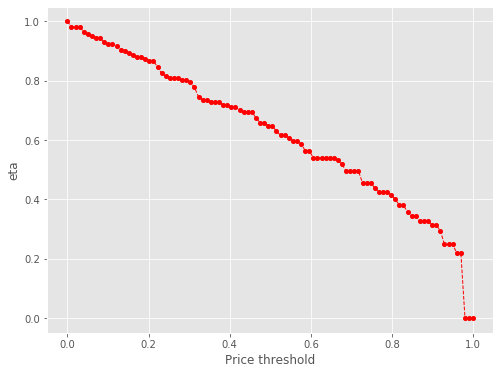

355 77
Number of cells with price above 45.0th percentile:  77


eta =  1.0
eta =  0.9815913236327034
eta =  0.9745314762200293
eta =  0.9677063268475578
eta =  0.9616991136124153
eta =  0.9616991136124153
eta =  0.9544364480195237
eta =  0.9402676026904648
eta =  0.9402676026904648
eta =  0.934060179291965
eta =  0.9275285217961358
eta =  0.9151031133919774
eta =  0.9151031133919774
eta =  0.9023767576211369
eta =  0.8959859054025773
eta =  0.8959859054025773
eta =  0.8896829071932699
eta =  0.8829315608824836
eta =  0.8829315608824836
eta =  0.8761619351645056
eta =  0.8471534772305858
eta =  0.8398245867851272
eta =  0.8309315871964632
eta =  0.8237461770279231
eta =  0.8237461770279231
eta =  0.8237461770279231
eta =  0.8165090206031459
eta =  0.8165090206031459
eta =  0.8088495327902583
eta =  0.7828795597379927
eta =  0.7586876962425997
eta =  0.7492084672213305
eta =  0.7492084672213305
eta =  0.7399420850910814
eta =  0.7399420850910814
eta =  0.7399420850910814
eta =  0.7318657549434476
eta =  0.7318657549434476
eta =  0.7229229032530032
et

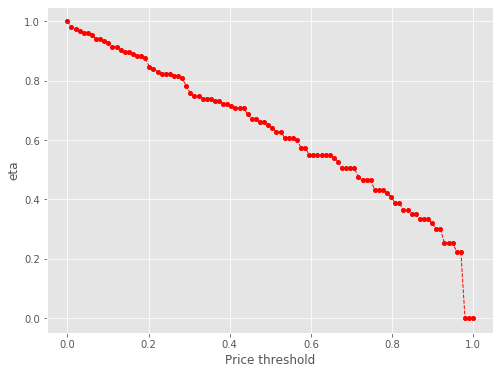

355 77
Number of cells with price above 46.0th percentile:  77


eta =  1.0
eta =  0.9815913236327034
eta =  0.9745314762200293
eta =  0.9677063268475578
eta =  0.9616991136124153
eta =  0.9616991136124153
eta =  0.9544364480195237
eta =  0.9402676026904648
eta =  0.9402676026904648
eta =  0.934060179291965
eta =  0.9275285217961358
eta =  0.9151031133919774
eta =  0.9151031133919774
eta =  0.9023767576211369
eta =  0.8959859054025773
eta =  0.8959859054025773
eta =  0.8896829071932699
eta =  0.8829315608824836
eta =  0.8829315608824836
eta =  0.8761619351645056
eta =  0.8471534772305858
eta =  0.8398245867851272
eta =  0.8309315871964632
eta =  0.8237461770279231
eta =  0.8237461770279231
eta =  0.8237461770279231
eta =  0.8165090206031459
eta =  0.8165090206031459
eta =  0.8088495327902583
eta =  0.7828795597379927
eta =  0.7586876962425997
eta =  0.7492084672213305
eta =  0.7492084672213305
eta =  0.7399420850910814
eta =  0.7399420850910814
eta =  0.7399420850910814
eta =  0.7318657549434476
eta =  0.7318657549434476
eta =  0.7229229032530032
et

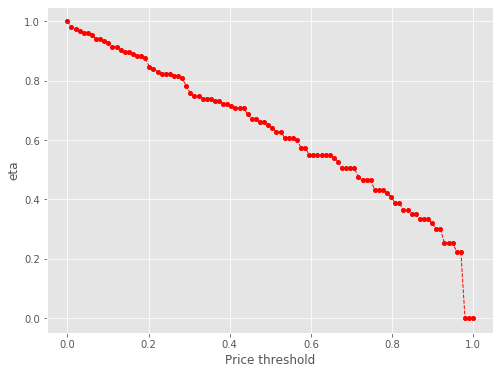

355 73
Number of cells with price above 47.0th percentile:  73


eta =  1.0
eta =  0.9929964813461494
eta =  0.986832274871831
eta =  0.986832274871831
eta =  0.9793798058955987
eta =  0.9648406702444688
eta =  0.9648406702444688
eta =  0.9584710212901049
eta =  0.951768664665192
eta =  0.9453102346591096
eta =  0.9390185291309828
eta =  0.9259595812351151
eta =  0.9259595812351151
eta =  0.9194017097096634
eta =  0.912933988180796
eta =  0.912933988180796
eta =  0.9060062013667947
eta =  0.9060062013667947
eta =  0.8835557397717794
eta =  0.8617726643808392
eta =  0.8526472540624802
eta =  0.8452740595132281
eta =  0.8452740595132281
eta =  0.8452740595132281
eta =  0.8378477663648032
eta =  0.8378477663648032
eta =  0.8299881045685553
eta =  0.8216962051707526
eta =  0.7955615288531377
eta =  0.7785153325014855
eta =  0.7687883721594381
eta =  0.7687883721594381
eta =  0.7592798212748724
eta =  0.7592798212748724
eta =  0.7592798212748724
eta =  0.750992423335752
eta =  0.750992423335752
eta =  0.741815858074739
eta =  0.741815858074739
eta =  0.7

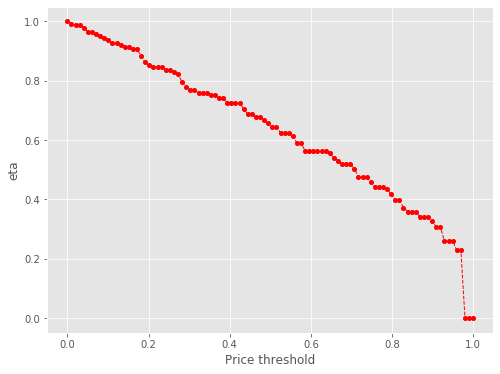

355 71
Number of cells with price above 48.00000000000001th percentile:  71


eta =  1.0
eta =  0.9777149519859203
eta =  0.9777149519859203
eta =  0.9712603100811537
eta =  0.9644685210450854
eta =  0.9579239134450539
eta =  0.9515482549989984
eta =  0.9383150559758272
eta =  0.9383150559758272
eta =  0.9316696799657009
eta =  0.9316696799657009
eta =  0.9251156568621218
eta =  0.9180954296255318
eta =  0.9180954296255318
eta =  0.895345401919019
eta =  0.8732716656361543
eta =  0.8732716656361543
eta =  0.8640244910648279
eta =  0.8565529128270674
eta =  0.8565529128270674
eta =  0.8565529128270674
eta =  0.8490275274728141
eta =  0.8490275274728141
eta =  0.841062990847511
eta =  0.8326604490894604
eta =  0.8061770466075043
eta =  0.7889033955669907
eta =  0.779046644232717
eta =  0.779046644232717
eta =  0.7694112166867333
eta =  0.7694112166867333
eta =  0.7694112166867333
eta =  0.7610132364522535
eta =  0.7610132364522535
eta =  0.7517142243559934
eta =  0.7517142243559934
eta =  0.7437258880883916
eta =  0.7349798285294976
eta =  0.7349798285294976
eta =

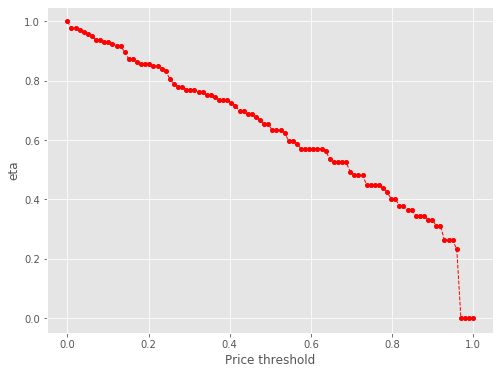

355 71
Number of cells with price above 49.0th percentile:  71


eta =  1.0
eta =  0.9777149519859203
eta =  0.9777149519859203
eta =  0.9712603100811537
eta =  0.9644685210450854
eta =  0.9579239134450539
eta =  0.9515482549989984
eta =  0.9383150559758272
eta =  0.9383150559758272
eta =  0.9316696799657009
eta =  0.9316696799657009
eta =  0.9251156568621218
eta =  0.9180954296255318
eta =  0.9180954296255318
eta =  0.895345401919019
eta =  0.8732716656361543
eta =  0.8732716656361543
eta =  0.8640244910648279
eta =  0.8565529128270674
eta =  0.8565529128270674
eta =  0.8565529128270674
eta =  0.8490275274728141
eta =  0.8490275274728141
eta =  0.841062990847511
eta =  0.8326604490894604
eta =  0.8061770466075043
eta =  0.7889033955669907
eta =  0.779046644232717
eta =  0.779046644232717
eta =  0.7694112166867333
eta =  0.7694112166867333
eta =  0.7694112166867333
eta =  0.7610132364522535
eta =  0.7610132364522535
eta =  0.7517142243559934
eta =  0.7517142243559934
eta =  0.7437258880883916
eta =  0.7349798285294976
eta =  0.7349798285294976
eta =

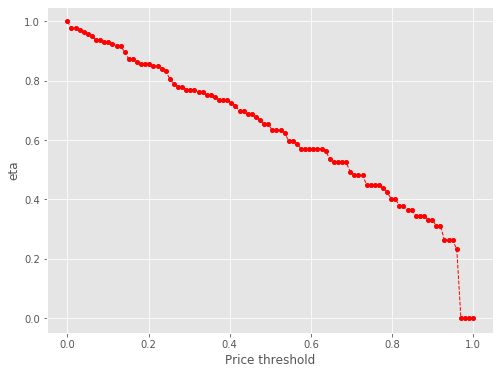

355 68
Number of cells with price above 50.0th percentile:  68


eta =  1.0
eta =  0.9933982375009648
eta =  0.9797578644975541
eta =  0.9732368857264866
eta =  0.9670019486366465
eta =  0.9597020625182578
eta =  0.9529052185131331
eta =  0.9529052185131331
eta =  0.9462018096205242
eta =  0.9462018096205242
eta =  0.9390215704083381
eta =  0.9390215704083381
eta =  0.9157530015270877
eta =  0.8931761387737578
eta =  0.8931761387737578
eta =  0.8837181934364755
eta =  0.8760763155838515
eta =  0.8760763155838515
eta =  0.8760763155838515
eta =  0.8683794041896176
eta =  0.8683794041896176
eta =  0.8602333319534043
eta =  0.8516392711374339
eta =  0.8245522327034166
eta =  0.8068848634917383
eta =  0.7968034473138912
eta =  0.7968034473138912
eta =  0.7869483995554292
eta =  0.7869483995554292
eta =  0.7869483995554292
eta =  0.7783590042337949
eta =  0.7783590042337949
eta =  0.7783590042337949
eta =  0.7688480398393442
eta =  0.7688480398393442
eta =  0.7517322170808755
eta =  0.7517322170808755
eta =  0.7517322170808755
eta =  0.7517322170808755
e

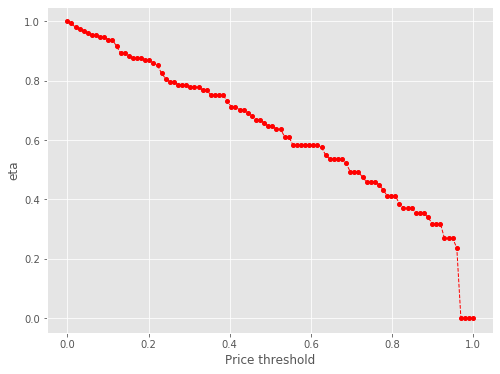

355 67
Number of cells with price above 51.0th percentile:  67


eta =  1.0
eta =  0.9862689780508117
eta =  0.9797046632323438
eta =  0.9734282910238276
eta =  0.9660798925237934
eta =  0.9592378791715017
eta =  0.9592378791715017
eta =  0.9524899218674177
eta =  0.9524899218674177
eta =  0.945261965403302
eta =  0.945261965403302
eta =  0.9218387620968558
eta =  0.8991118617450641
eta =  0.8991118617450641
eta =  0.8895910623513837
eta =  0.8818983993647368
eta =  0.8818983993647368
eta =  0.8818983993647368
eta =  0.8741503371036273
eta =  0.8741503371036273
eta =  0.8659501290413443
eta =  0.8572989552305369
eta =  0.8300319062148687
eta =  0.8122471261088328
eta =  0.8020987125146951
eta =  0.8020987125146951
eta =  0.7921781717019253
eta =  0.7921781717019253
eta =  0.7921781717019253
eta =  0.7835316943906284
eta =  0.7835316943906284
eta =  0.7835316943906284
eta =  0.7739575235944564
eta =  0.7739575235944564
eta =  0.7567279553182673
eta =  0.7567279553182673
eta =  0.7567279553182673
eta =  0.7567279553182673
eta =  0.7469502515602131
eta

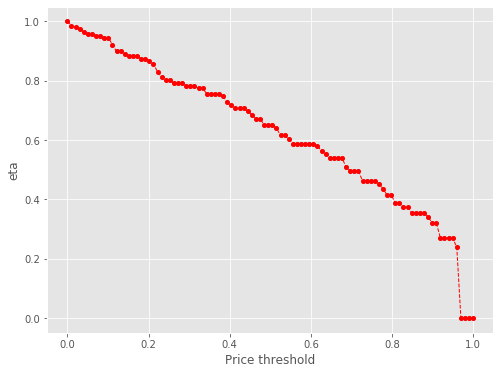

355 65
Number of cells with price above 52.0th percentile:  65


eta =  1.0
eta =  0.9933442955577483
eta =  0.9795298382324481
eta =  0.9795298382324481
eta =  0.9725925690852284
eta =  0.9725925690852284
eta =  0.9657506654521848
eta =  0.9584220800206523
eta =  0.9584220800206523
eta =  0.9510736522952905
eta =  0.926918791802878
eta =  0.9116294659515719
eta =  0.9019761162005775
eta =  0.8941763545150279
eta =  0.8941763545150279
eta =  0.8941763545150279
eta =  0.8941763545150279
eta =  0.8863204222759117
eta =  0.8863204222759117
eta =  0.878006049376858
eta =  0.8692344322994305
eta =  0.8415877663061873
eta =  0.8235553831512548
eta =  0.8132656814370286
eta =  0.8132656814370286
eta =  0.8032070249918303
eta =  0.8032070249918303
eta =  0.8032070249918303
eta =  0.7944401697994617
eta =  0.7944401697994617
eta =  0.7944401697994617
eta =  0.7847327055992861
eta =  0.7847327055992861
eta =  0.7672632640375731
eta =  0.7672632640375731
eta =  0.7672632640375731
eta =  0.7672632640375731
eta =  0.7573494332513933
eta =  0.7375527480701677
eta

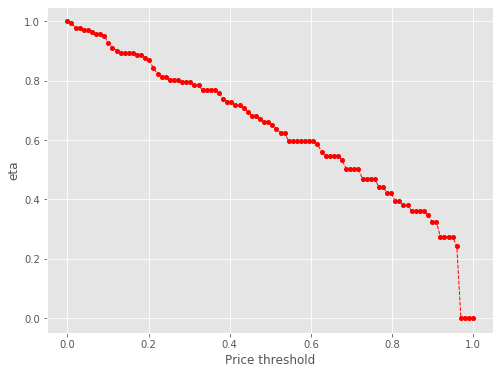

355 62
Number of cells with price above 53.0th percentile:  62


eta =  1.0
eta =  0.9929177561760263
eta =  0.9929177561760263
eta =  0.9859328708096042
eta =  0.9784511329946982
eta =  0.9784511329946982
eta =  0.9623868306413058
eta =  0.938802412712699
eta =  0.9306806493986934
eta =  0.9208255644648707
eta =  0.9128628037799852
eta =  0.9128628037799852
eta =  0.9128628037799852
eta =  0.9128628037799852
eta =  0.904842698692332
eta =  0.904842698692332
eta =  0.8963545724765375
eta =  0.8873996466181729
eta =  0.8591752220890219
eta =  0.8407659991627742
eta =  0.8302612638166883
eta =  0.8302612638166883
eta =  0.8302612638166883
eta =  0.8199924021112103
eta =  0.8199924021112103
eta =  0.8199924021112103
eta =  0.8110423376515219
eta =  0.8110423376515219
eta =  0.8011320073876754
eta =  0.8011320073876754
eta =  0.7926185169382504
eta =  0.7832974903777224
eta =  0.7832974903777224
eta =  0.7832974903777224
eta =  0.7832974903777224
eta =  0.7731764808900797
eta =  0.7529660856488806
eta =  0.7423411189916362
eta =  0.7423411189916362
eta 

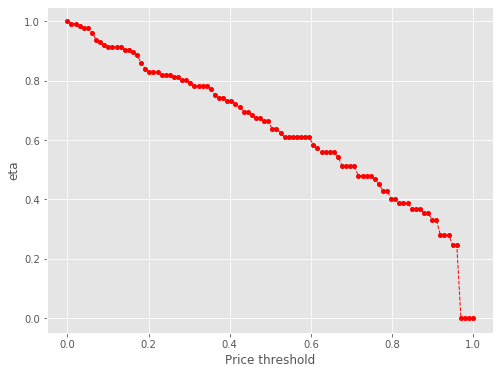

355 61
Number of cells with price above 54.0th percentile:  61


eta =  1.0
eta =  0.9929652931242537
eta =  0.9854301898708684
eta =  0.9854301898708684
eta =  0.9778746851724587
eta =  0.9530391463659763
eta =  0.9373189708913823
eta =  0.9373189708913823
eta =  0.9273935920042354
eta =  0.9193740348602962
eta =  0.9193740348602962
eta =  0.9193740348602962
eta =  0.9112967242897405
eta =  0.9112967242897405
eta =  0.90274805430877
eta =  0.8937292551155195
eta =  0.8653035125466179
eta =  0.8467629810557257
eta =  0.8361833179559919
eta =  0.8361833179559919
eta =  0.8361833179559919
eta =  0.8258412109268801
eta =  0.8258412109268801
eta =  0.8258412109268801
eta =  0.8168273078074946
eta =  0.8168273078074946
eta =  0.8168273078074946
eta =  0.8068462895386566
eta =  0.8068462895386566
eta =  0.7982720744070705
eta =  0.7888845632032971
eta =  0.7888845632032971
eta =  0.7888845632032971
eta =  0.7888845632032971
eta =  0.7675952220535375
eta =  0.7476360598591538
eta =  0.7476360598591538
eta =  0.7371251430658354
eta =  0.7371251430658354
eta

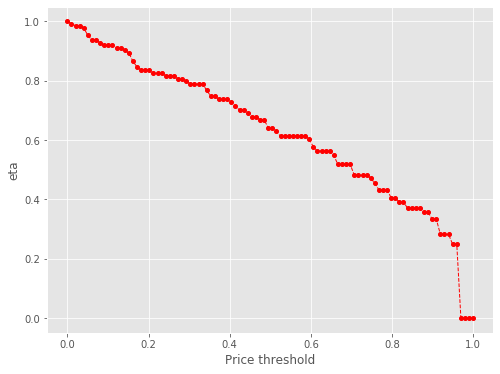

355 60
Number of cells with price above 55.00000000000001th percentile:  60


eta =  1.0
eta =  0.9924115139717754
eta =  0.9924115139717754
eta =  0.9678199642149827
eta =  0.9439594489171051
eta =  0.9439594489171051
eta =  0.9339637532408568
eta =  0.9258873811868985
eta =  0.9258873811868985
eta =  0.9258873811868985
eta =  0.9177528465495987
eta =  0.9177528465495987
eta =  0.9177528465495987
eta =  0.9091436131351326
eta =  0.9000609198570283
eta =  0.8714337938479578
eta =  0.8527619111353641
eta =  0.8421072959408632
eta =  0.8421072959408632
eta =  0.8421072959408632
eta =  0.8316919197935545
eta =  0.8316919197935545
eta =  0.8316919197935545
eta =  0.8226141572757687
eta =  0.8226141572757687
eta =  0.8226141572757687
eta =  0.8125624280381497
eta =  0.8125624280381497
eta =  0.8039274684973099
eta =  0.7944734510520106
eta =  0.7944734510520106
eta =  0.7944734510520106
eta =  0.7842080366538359
eta =  0.7730332846160065
eta =  0.7529327208474739
eta =  0.7529327208474739
eta =  0.7423473389956602
eta =  0.7423473389956602
eta =  0.7423473389956602
e

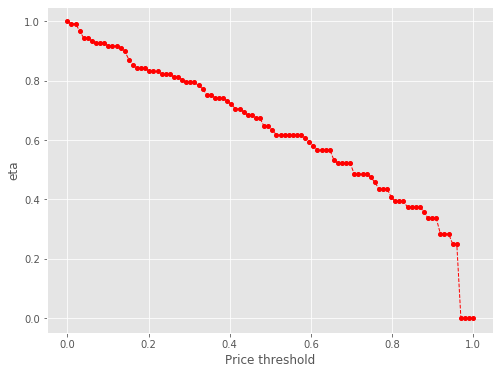

355 59
Number of cells with price above 56.00000000000001th percentile:  59


eta =  1.0
eta =  0.9752204106758358
eta =  0.9511774456739643
eta =  0.9511774456739643
eta =  0.9411053177960399
eta =  0.9329671896705051
eta =  0.9329671896705051
eta =  0.9329671896705051
eta =  0.9247704542207679
eta =  0.9247704542207679
eta =  0.9247704542207679
eta =  0.9160953902042183
eta =  0.9069432460077507
eta =  0.8780972223511927
eta =  0.8592825648732014
eta =  0.8485464790413678
eta =  0.8485464790413678
eta =  0.8485464790413678
eta =  0.8380514616008456
eta =  0.8380514616008456
eta =  0.8380514616008456
eta =  0.828904285867812
eta =  0.828904285867812
eta =  0.828904285867812
eta =  0.818775695967247
eta =  0.818775695967247
eta =  0.8100747091092031
eta =  0.8005484014110358
eta =  0.8005484014110358
eta =  0.8005484014110358
eta =  0.8005484014110358
eta =  0.790204492403883
eta =  0.7695489945873062
eta =  0.7586900295363639
eta =  0.7586900295363639
eta =  0.7480237064407667
eta =  0.7480237064407667
eta =  0.7375811435690393
eta =  0.7254986108281144
eta =  

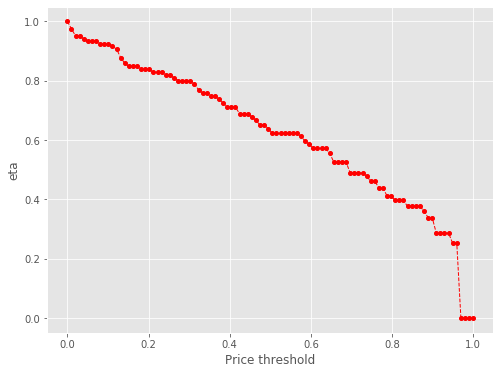

355 54
Number of cells with price above 57.00000000000001th percentile:  54


eta =  1.0
eta =  0.9913488043873497
eta =  0.9808512973503299
eta =  0.9723694692499132
eta =  0.9723694692499132
eta =  0.9723694692499132
eta =  0.9723694692499132
eta =  0.9638265586448171
eta =  0.9638265586448171
eta =  0.9638265586448171
eta =  0.9452464486685797
eta =  0.9349207848454075
eta =  0.9151821623534265
eta =  0.8955728998750168
eta =  0.8843833937512179
eta =  0.8843833937512179
eta =  0.8843833937512179
eta =  0.8734451371314828
eta =  0.8734451371314828
eta =  0.8734451371314828
eta =  0.8639116460171737
eta =  0.8639116460171737
eta =  0.8639116460171737
eta =  0.8533552923801925
eta =  0.8533552923801925
eta =  0.8442868341677503
eta =  0.8343581990957605
eta =  0.8343581990957605
eta =  0.8343581990957605
eta =  0.8343581990957605
eta =  0.8118416774521862
eta =  0.802049585144505
eta =  0.7907320102071513
eta =  0.7907320102071513
eta =  0.7796152131298856
eta =  0.7796152131298856
eta =  0.7687316264082812
eta =  0.7561388084843872
eta =  0.7411811932658242
et

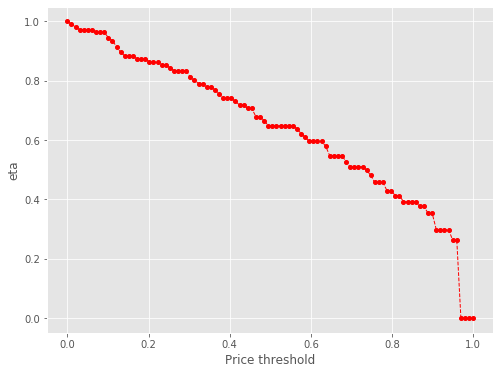

355 52
Number of cells with price above 58.00000000000001th percentile:  52


eta =  1.0
eta =  0.9913525851234234
eta =  0.9913525851234234
eta =  0.9913525851234234
eta =  0.9826428952569024
eta =  0.9826428952569024
eta =  0.9826428952569024
eta =  0.9734249428635767
eta =  0.9637000544548056
eta =  0.933048837092532
eta =  0.9130567521237072
eta =  0.9016487984878949
eta =  0.9016487984878949
eta =  0.9016487984878949
eta =  0.890496999383093
eta =  0.890496999383093
eta =  0.890496999383093
eta =  0.8807773903658416
eta =  0.8807773903658416
eta =  0.8807773903658416
eta =  0.8700149499577
eta =  0.8700149499577
eta =  0.8700149499577
eta =  0.8607694524628813
eta =  0.8506469852766616
eta =  0.8506469852766616
eta =  0.8506469852766616
eta =  0.8506469852766616
eta =  0.8276908840772235
eta =  0.8177076253160498
eta =  0.8061691026389357
eta =  0.8061691026389357
eta =  0.7948352775144784
eta =  0.7948352775144784
eta =  0.7837392156027438
eta =  0.7709005539647236
eta =  0.7709005539647236
eta =  0.7556509281968122
eta =  0.7556509281968122
eta =  0.74458

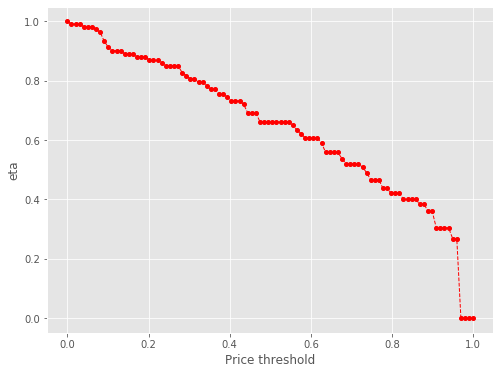

355 51
Number of cells with price above 59.0th percentile:  51


eta =  1.0
eta =  0.9912143368593358
eta =  0.9912143368593358
eta =  0.9819159776966591
eta =  0.9721062605942818
eta =  0.9503893087099025
eta =  0.9411876774158684
eta =  0.9210212045899205
eta =  0.9095137411435101
eta =  0.9095137411435101
eta =  0.9095137411435101
eta =  0.8982646666243637
eta =  0.8982646666243637
eta =  0.8982646666243637
eta =  0.8884602749648197
eta =  0.8884602749648197
eta =  0.8884602749648197
eta =  0.8776039554578688
eta =  0.8776039554578688
eta =  0.8776039554578688
eta =  0.86827781092205
eta =  0.8580670470241988
eta =  0.8580670470241988
eta =  0.8580670470241988
eta =  0.8580670470241988
eta =  0.8469799379364655
eta =  0.8349107033136711
eta =  0.8132011907131584
eta =  0.8132011907131584
eta =  0.8017685023896128
eta =  0.8017685023896128
eta =  0.8017685023896128
eta =  0.7905756512504261
eta =  0.7776249999577561
eta =  0.7622423540689447
eta =  0.7622423540689447
eta =  0.7622423540689447
eta =  0.7510812452741716
eta =  0.738810981531941
eta 

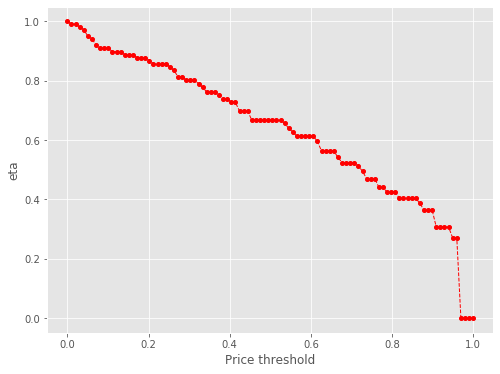

355 50
Number of cells with price above 60.0th percentile:  50


eta =  1.0
eta =  0.9906192245038155
eta =  0.980722558628845
eta =  0.9495299275008704
eta =  0.9291847084336751
eta =  0.917575248180233
eta =  0.917575248180233
eta =  0.917575248180233
eta =  0.9062264670934005
eta =  0.9062264670934005
eta =  0.9062264670934005
eta =  0.9062264670934005
eta =  0.8963351738635131
eta =  0.8963351738635131
eta =  0.8963351738635131
eta =  0.885382628986742
eta =  0.885382628986742
eta =  0.8759738218407833
eta =  0.8656725544779603
eta =  0.8656725544779603
eta =  0.8656725544779603
eta =  0.8656725544779603
eta =  0.8656725544779603
eta =  0.8544871744088396
eta =  0.8321513636978651
eta =  0.8204090280713531
eta =  0.8204090280713531
eta =  0.8088750057127074
eta =  0.8088750057127074
eta =  0.8088750057127074
eta =  0.7975829463437405
eta =  0.7845175064977996
eta =  0.7689985159860689
eta =  0.7689985159860689
eta =  0.7689985159860689
eta =  0.757738480310902
eta =  0.7453594586543862
eta =  0.7453594586543862
eta =  0.7453594586543862
eta =  0

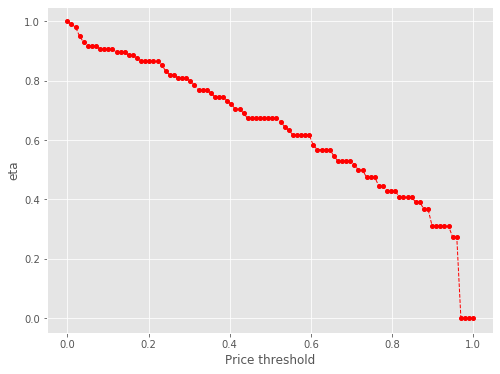

355 49
Number of cells with price above 61.0th percentile:  49


eta =  1.0
eta =  0.9900096165810557
eta =  0.9585216034712771
eta =  0.9379837231597116
eta =  0.9262643258713568
eta =  0.9262643258713568
eta =  0.9262643258713568
eta =  0.9148080762790708
eta =  0.9148080762790708
eta =  0.9148080762790708
eta =  0.9148080762790708
eta =  0.9048231163820512
eta =  0.9048231163820512
eta =  0.9048231163820512
eta =  0.8937668552013164
eta =  0.8937668552013164
eta =  0.8937668552013164
eta =  0.8842689503421901
eta =  0.873870134018004
eta =  0.873870134018004
eta =  0.873870134018004
eta =  0.873870134018004
eta =  0.862578832786975
eta =  0.8502873181391475
eta =  0.8281779797704634
eta =  0.8281779797704634
eta =  0.8165347347441791
eta =  0.8165347347441791
eta =  0.8165347347441791
eta =  0.8051357440021785
eta =  0.7919465795656764
eta =  0.7919465795656764
eta =  0.7762806303009588
eta =  0.7762806303009588
eta =  0.7649139665045773
eta =  0.7524177203685143
eta =  0.7524177203685143
eta =  0.7524177203685143
eta =  0.7401771025880222
eta = 

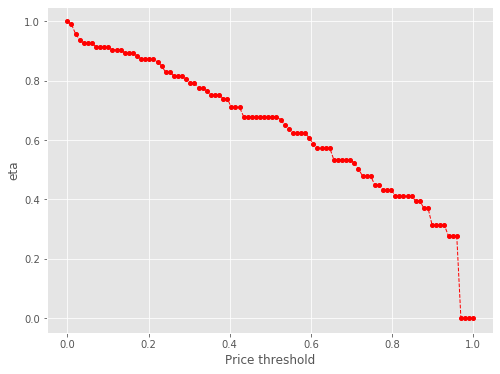

355 45
Number of cells with price above 62.0th percentile:  45


eta =  1.0
eta =  0.9785733777546715
eta =  0.9663468434273146
eta =  0.9663468434273146
eta =  0.9663468434273146
eta =  0.954394844066218
eta =  0.954394844066218
eta =  0.954394844066218
eta =  0.954394844066218
eta =  0.9439778019663225
eta =  0.9439778019663225
eta =  0.9439778019663225
eta =  0.9324430998368195
eta =  0.9324430998368195
eta =  0.9324430998368195
eta =  0.9225341892554306
eta =  0.9116853817934737
eta =  0.9116853817934737
eta =  0.9116853817934737
eta =  0.9116853817934737
eta =  0.8999054686541792
eta =  0.887082059559054
eta =  0.8640159770747206
eta =  0.8640159770747206
eta =  0.8640159770747206
eta =  0.8518688903694044
eta =  0.8518688903694044
eta =  0.8399766276382157
eta =  0.8399766276382157
eta =  0.8262167244824208
eta =  0.809872857836136
eta =  0.809872857836136
eta =  0.7980143209443047
eta =  0.7849773209530597
eta =  0.7849773209530597
eta =  0.7849773209530597
eta =  0.7849773209530597
eta =  0.7722070112008718
eta =  0.7590898400474051
eta =  0

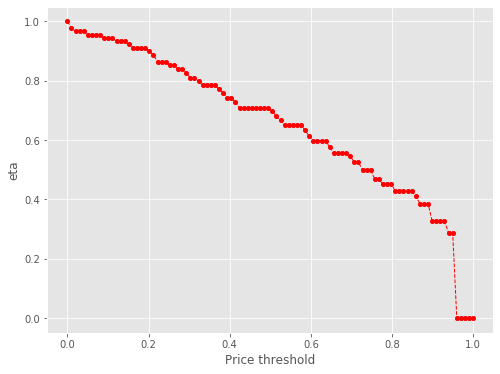

355 42
Number of cells with price above 63.0th percentile:  42


eta =  1.0
eta =  0.9876317706811079
eta =  0.9876317706811079
eta =  0.9876317706811079
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9649155540569164
eta =  0.9649155540569164
eta =  0.9546615643545802
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9312447955668902
eta =  0.9179748095547822
eta =  0.9069025841185414
eta =  0.894105447698613
eta =  0.894105447698613
eta =  0.8815353370929484
eta =  0.8815353370929484
eta =  0.8815353370929484
eta =  0.8692289247399978
eta =  0.8549898311377535
eta =  0.8549898311377535
eta =  0.838076787174865
eta =  0.838076787174865
eta =  0.8258052751680859
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.7990992224511309
eta =  0.7855252440781645
eta =  0.7672651459220966
eta =  0.7672651459220966
eta =  0.7528186944622808
eta =

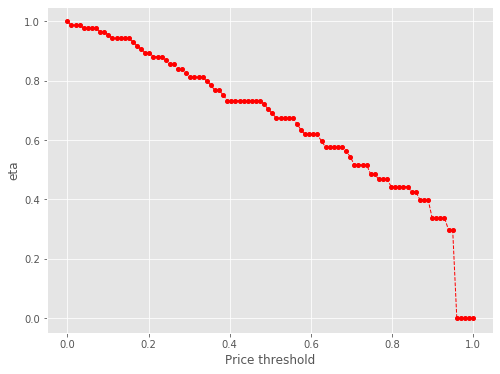

355 42
Number of cells with price above 64.0th percentile:  42


eta =  1.0
eta =  0.9876317706811079
eta =  0.9876317706811079
eta =  0.9876317706811079
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9768519537129583
eta =  0.9649155540569164
eta =  0.9649155540569164
eta =  0.9546615643545802
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9434349457385562
eta =  0.9312447955668902
eta =  0.9179748095547822
eta =  0.9069025841185414
eta =  0.894105447698613
eta =  0.894105447698613
eta =  0.8815353370929484
eta =  0.8815353370929484
eta =  0.8815353370929484
eta =  0.8692289247399978
eta =  0.8549898311377535
eta =  0.8549898311377535
eta =  0.838076787174865
eta =  0.838076787174865
eta =  0.8258052751680859
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.8123142599286641
eta =  0.7990992224511309
eta =  0.7855252440781645
eta =  0.7672651459220966
eta =  0.7672651459220966
eta =  0.7528186944622808
eta =

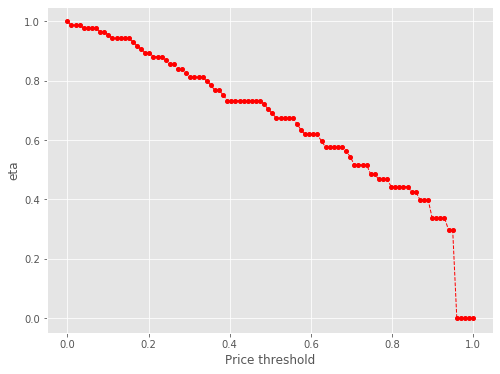

355 41
Number of cells with price above 65.0th percentile:  41


eta =  1.0
eta =  0.9890851861106945
eta =  0.9890851861106945
eta =  0.9890851861106945
eta =  0.9769993055118857
eta =  0.9769993055118857
eta =  0.9769993055118857
eta =  0.9666169038853517
eta =  0.9552496929983613
eta =  0.9552496929983613
eta =  0.9552496929983613
eta =  0.9552496929983613
eta =  0.9552496929983613
eta =  0.9429068841362493
eta =  0.9294707165219203
eta =  0.9053024358278838
eta =  0.9053024358278838
eta =  0.9053024358278838
eta =  0.8925749082423793
eta =  0.8925749082423793
eta =  0.8925749082423793
eta =  0.8801143812339542
eta =  0.8656969697806709
eta =  0.8656969697806709
eta =  0.8485721217705419
eta =  0.8485721217705419
eta =  0.8361469321694457
eta =  0.8361469321694457
eta =  0.8224869673526823
eta =  0.8224869673526823
eta =  0.8224869673526823
eta =  0.8091064363999166
eta =  0.8091064363999166
eta =  0.7768736979704104
eta =  0.7768736979704104
eta =  0.7768736979704104
eta =  0.7622463318926129
eta =  0.7423891116434084
eta =  0.7423891116434084
e

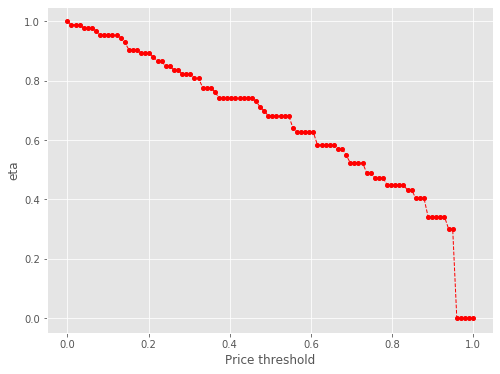

355 40
Number of cells with price above 66.0th percentile:  40


eta =  1.0
eta =  0.987780748545701
eta =  0.987780748545701
eta =  0.9772837743999653
eta =  0.9657911233658427
eta =  0.9657911233658427
eta =  0.9657911233658427
eta =  0.9657911233658427
eta =  0.9657911233658427
eta =  0.9657911233658427
eta =  0.9533121083776124
eta =  0.9397276691371834
eta =  0.9152926851404344
eta =  0.9152926851404344
eta =  0.9152926851404344
eta =  0.9024247059570113
eta =  0.9024247059570113
eta =  0.9024247059570113
eta =  0.8898266737719144
eta =  0.87525016240996
eta =  0.87525016240996
eta =  0.8579363372201725
eta =  0.8579363372201725
eta =  0.8579363372201725
eta =  0.8453740323999428
eta =  0.8315633262963791
eta =  0.8315633262963791
eta =  0.8315633262963791
eta =  0.818035137682635
eta =  0.818035137682635
eta =  0.8041395025033506
eta =  0.7854467025486981
eta =  0.7854467025486981
eta =  0.7706579196579993
eta =  0.7505815697863694
eta =  0.7505815697863694
eta =  0.7505815697863694
eta =  0.7505815697863694
eta =  0.7505815697863694
eta =  0.

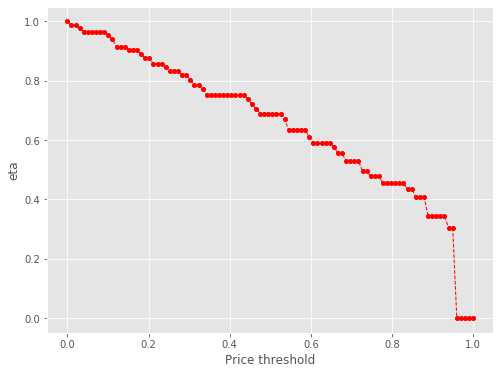

355 39
Number of cells with price above 67.0th percentile:  39


eta =  1.0
eta =  0.98937317399515
eta =  0.9777383541719827
eta =  0.9777383541719827
eta =  0.9777383541719827
eta =  0.9777383541719827
eta =  0.9777383541719827
eta =  0.9651049686695794
eta =  0.9513524843653154
eta =  0.9266152296326994
eta =  0.9266152296326994
eta =  0.9266152296326994
eta =  0.913588068289083
eta =  0.913588068289083
eta =  0.913588068289083
eta =  0.9008341932984589
eta =  0.9008341932984589
eta =  0.8860773645351779
eta =  0.8685493602535816
eta =  0.8685493602535816
eta =  0.8685493602535816
eta =  0.8558316545899259
eta =  0.8558316545899259
eta =  0.8418501044089803
eta =  0.8418501044089803
eta =  0.8418501044089803
eta =  0.8281545665746366
eta =  0.8281545665746366
eta =  0.7951629991828683
eta =  0.7951629991828683
eta =  0.7951629991828683
eta =  0.7801912730053009
eta =  0.7598665704828147
eta =  0.7598665704828147
eta =  0.7598665704828147
eta =  0.7598665704828147
eta =  0.7598665704828147
eta =  0.7598665704828147
eta =  0.7598665704828147
eta = 

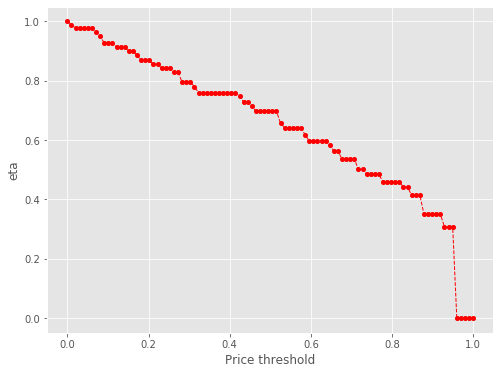

355 37
Number of cells with price above 68.0th percentile:  37


eta =  1.0
eta =  0.9730133632437762
eta =  0.9730133632437762
eta =  0.9477128780709662
eta =  0.9477128780709662
eta =  0.9477128780709662
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.921344845944341
eta =  0.9062520261727589
eta =  0.9062520261727589
eta =  0.8883249353444153
eta =  0.8883249353444153
eta =  0.8883249353444153
eta =  0.8753176664678395
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8470104123878579
eta =  0.8470104123878579
eta =  0.8326225858246388
eta =  0.8132676761527555
eta =  0.8132676761527555
eta =  0.8132676761527555
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7652695041290982
et

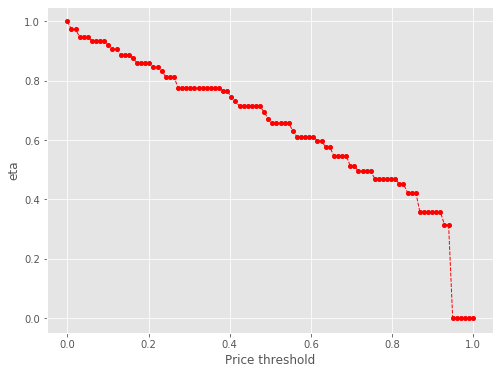

355 37
Number of cells with price above 69.0th percentile:  37


eta =  1.0
eta =  0.9730133632437762
eta =  0.9730133632437762
eta =  0.9477128780709662
eta =  0.9477128780709662
eta =  0.9477128780709662
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.9343891076695803
eta =  0.921344845944341
eta =  0.9062520261727589
eta =  0.9062520261727589
eta =  0.8883249353444153
eta =  0.8883249353444153
eta =  0.8883249353444153
eta =  0.8753176664678395
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8610177772170121
eta =  0.8470104123878579
eta =  0.8470104123878579
eta =  0.8326225858246388
eta =  0.8132676761527555
eta =  0.8132676761527555
eta =  0.8132676761527555
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7771676003508351
eta =  0.7652695041290982
et

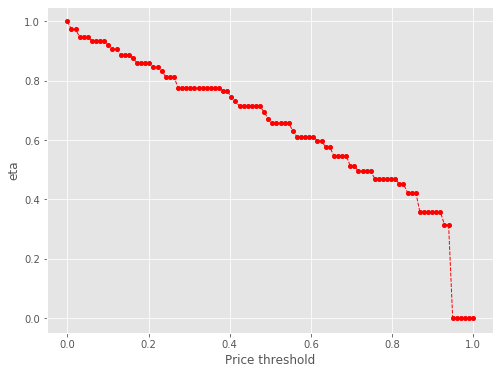

355 36
Number of cells with price above 70.0th percentile:  36


eta =  1.0
eta =  0.985750270954234
eta =  0.9601185981977286
eta =  0.9601185981977286
eta =  0.9601185981977286
eta =  0.9466204174127154
eta =  0.9466204174127154
eta =  0.9466204174127154
eta =  0.9466204174127154
eta =  0.9334054041191816
eta =  0.9181150168117537
eta =  0.9181150168117537
eta =  0.8999532573652562
eta =  0.8999532573652562
eta =  0.8999532573652562
eta =  0.8867757211629639
eta =  0.8722886439694649
eta =  0.8722886439694649
eta =  0.8722886439694649
eta =  0.8722886439694649
eta =  0.8580979203912582
eta =  0.8580979203912582
eta =  0.8435217547712364
eta =  0.8239134860936626
eta =  0.8239134860936626
eta =  0.8239134860936626
eta =  0.8084004313860422
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7873408542599352
eta =  0.7752870099680987
et

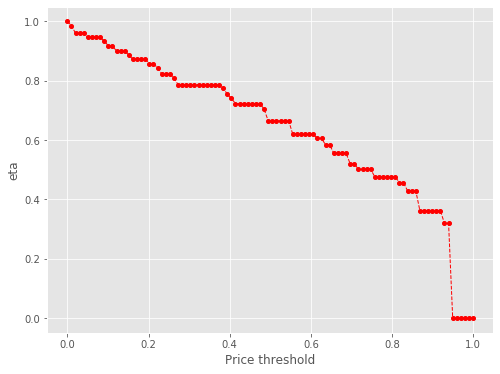

355 33
Number of cells with price above 71.00000000000001th percentile:  33


eta =  1.0
eta =  0.9859411318452209
eta =  0.9859411318452209
eta =  0.9859411318452209
eta =  0.9721771933918464
eta =  0.9721771933918464
eta =  0.9562516740485797
eta =  0.9562516740485797
eta =  0.9373355115238776
eta =  0.9373355115238776
eta =  0.9373355115238776
eta =  0.9236106068849836
eta =  0.9085217655473685
eta =  0.9085217655473685
eta =  0.9085217655473685
eta =  0.9085217655473685
eta =  0.8937415877601196
eta =  0.8937415877601196
eta =  0.8785599574413409
eta =  0.8581372005919463
eta =  0.8581372005919463
eta =  0.8581372005919463
eta =  0.8419797646910687
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8200454149496527
eta =  0.8074908781304898
eta =  0.7866759074673947
eta =  0.7715197364090266
eta =  0.7715197364090266
e

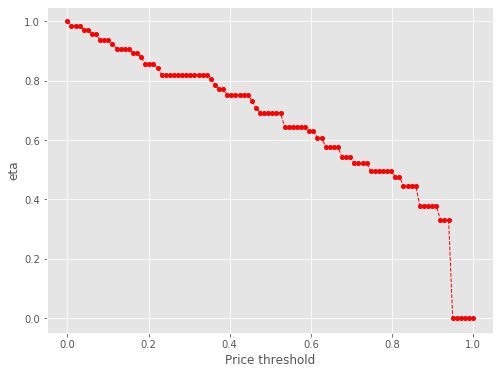

355 32
Number of cells with price above 72.0th percentile:  32


eta =  1.0
eta =  0.9860397968917121
eta =  0.9698871901803342
eta =  0.9698871901803342
eta =  0.950701295694626
eta =  0.950701295694626
eta =  0.950701295694626
eta =  0.950701295694626
eta =  0.936780682997185
eta =  0.9214766847661994
eta =  0.9214766847661994
eta =  0.9214766847661994
eta =  0.9214766847661994
eta =  0.9064857514235694
eta =  0.9064857514235694
eta =  0.8910876411019463
eta =  0.8703736692533708
eta =  0.8703736692533708
eta =  0.8703736692533708
eta =  0.8539858390077267
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8317387199526923
eta =  0.8190051637456734
eta =  0.8190051637456734
eta =  0.7978933853739372
eta =  0.782521097344932
eta =  0.7641110777593535
eta =  0.7641110777593535
eta =  0.7641110777593535
eta =  

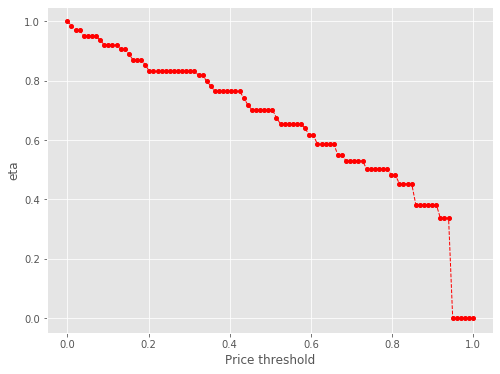

355 31
Number of cells with price above 73.0th percentile:  31


eta =  1.0
eta =  0.9836187071127396
eta =  0.9641611816191563
eta =  0.9641611816191563
eta =  0.9641611816191563
eta =  0.9641611816191563
eta =  0.9500434829813093
eta =  0.9345228130456452
eta =  0.9345228130456452
eta =  0.9345228130456452
eta =  0.9345228130456452
eta =  0.9345228130456452
eta =  0.9193196403239297
eta =  0.9193196403239297
eta =  0.8826962887269307
eta =  0.8826962887269307
eta =  0.8826962887269307
eta =  0.8826962887269307
eta =  0.8660764420459921
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8435143516261492
eta =  0.8306005156459394
eta =  0.8091898398919924
eta =  0.8091898398919924
eta =  0.7935999133216215
eta =  0.7749292474482843
eta =  0.7749292474482843
eta =  0.7749292474482843
eta =  0.7749292474482843
e

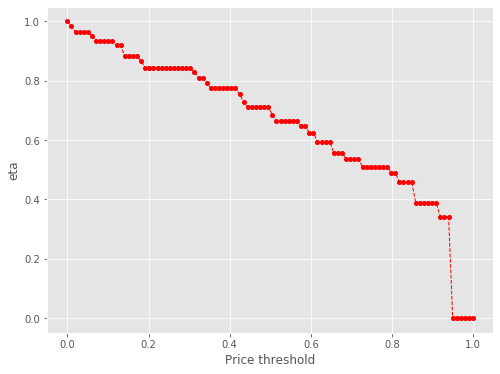

355 29
Number of cells with price above 74.0th percentile:  29


eta =  1.0
eta =  0.9853575326335597
eta =  0.9692599441477844
eta =  0.9692599441477844
eta =  0.9692599441477844
eta =  0.9692599441477844
eta =  0.9692599441477844
eta =  0.9534916545593317
eta =  0.9534916545593317
eta =  0.9372950737916863
eta =  0.9155069770021044
eta =  0.9155069770021044
eta =  0.9155069770021044
eta =  0.8982693542915238
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8748686088041837
eta =  0.8614747528531248
eta =  0.8392682212460432
eta =  0.8392682212460432
eta =  0.8230988017884063
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
eta =  0.8037341289211759
e

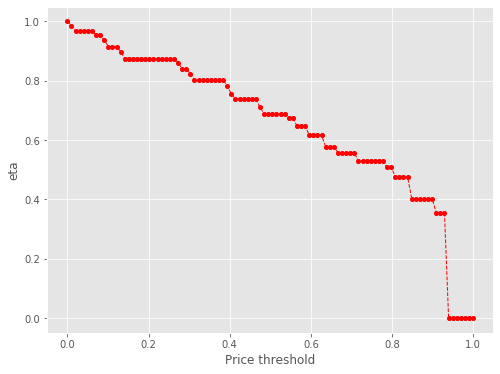

355 27
Number of cells with price above 75.0th percentile:  27


eta =  1.0
eta =  0.9837316194859194
eta =  0.9837316194859194
eta =  0.9670213645481832
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.9267579452912618
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.8887964039518532
eta =  0.8887964039518532
eta =  0.8658855927281348
eta =  0.8492033605207019
eta =  0.8492033605207019
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.8067864024717427
eta =  0.7804261208300579
eta =  0.7620867409763773
eta =  0.7620867409763773
eta =  0.7620

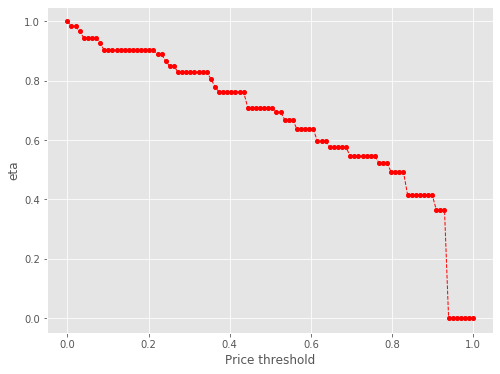

355 27
Number of cells with price above 76.0th percentile:  27


eta =  1.0
eta =  0.9837316194859194
eta =  0.9837316194859194
eta =  0.9670213645481832
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.944542258792153
eta =  0.9267579452912618
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.9026150457227512
eta =  0.8887964039518532
eta =  0.8887964039518532
eta =  0.8658855927281348
eta =  0.8492033605207019
eta =  0.8492033605207019
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.829224537518523
eta =  0.8067864024717427
eta =  0.7804261208300579
eta =  0.7620867409763773
eta =  0.7620867409763773
eta =  0.7620

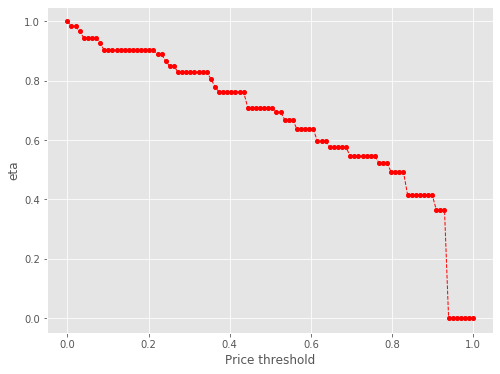

355 24
Number of cells with price above 77.0th percentile:  24


eta =  1.0
eta =  0.9811715004433648
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9556110775572743
eta =  0.9409810897062608
eta =  0.9409810897062608
eta =  0.9167250958526709
eta =  0.9167250958526709
eta =  0.8990633850587403
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.87791152783244
eta =  0.854155962808305
eta =  0.8262479667432127
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.806831810734341
eta =  0.7766122604798882
e

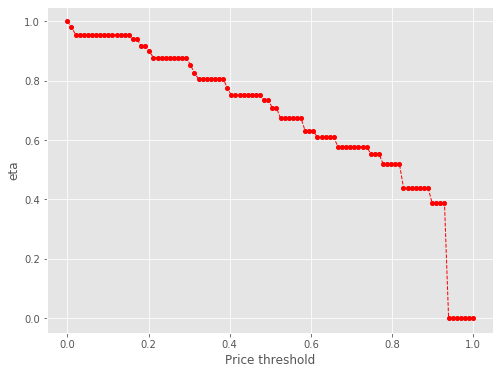

355 22
Number of cells with price above 78.0th percentile:  22


eta =  1.0
eta =  0.9846904371510525
eta =  0.9593077323841793
eta =  0.9593077323841793
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.893832211522382
eta =  0.8646278660302489
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8126865402869319
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7693277832273656
eta =

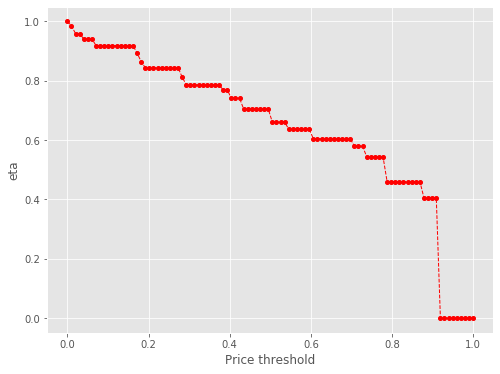

355 22
Number of cells with price above 79.0th percentile:  22


eta =  1.0
eta =  0.9846904371510525
eta =  0.9593077323841793
eta =  0.9593077323841793
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.893832211522382
eta =  0.8646278660302489
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8126865402869319
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7693277832273656
eta =

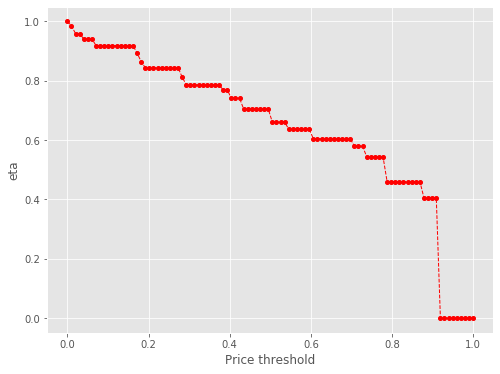

355 22
Number of cells with price above 80.0th percentile:  22


eta =  1.0
eta =  0.9846904371510525
eta =  0.9593077323841793
eta =  0.9593077323841793
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.893832211522382
eta =  0.8646278660302489
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8126865402869319
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7693277832273656
eta =

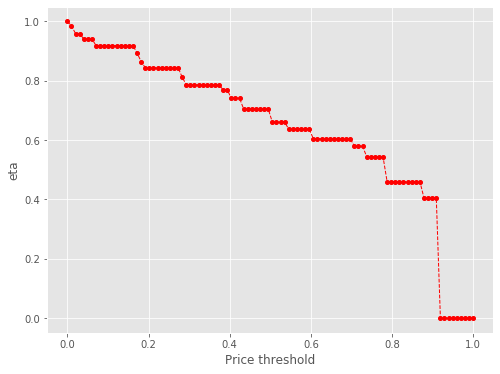

355 22
Number of cells with price above 81.0th percentile:  22


eta =  1.0
eta =  0.9846904371510525
eta =  0.9593077323841793
eta =  0.9593077323841793
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.940825620561996
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.9186912421280744
eta =  0.893832211522382
eta =  0.8646278660302489
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8443098135663708
eta =  0.8126865402869319
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7862355778297493
eta =  0.7693277832273656
eta =

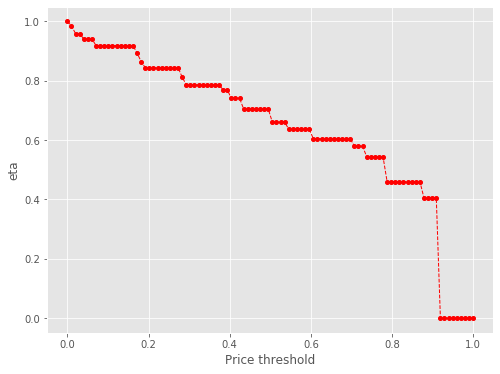

355 20
Number of cells with price above 82.0th percentile:  20


eta =  1.0
eta =  0.9807339071725718
eta =  0.9807339071725718
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9576606245472866
eta =  0.9317471144540134
eta =  0.9317471144540134
eta =  0.901303968312002
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8801240572386477
eta =  0.8471593763423046
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8195864072477643
eta =  0.8019614116059982
eta =  0.8019614116059982
eta =  0.8019614116059982
eta =  0.7729281167610499
et

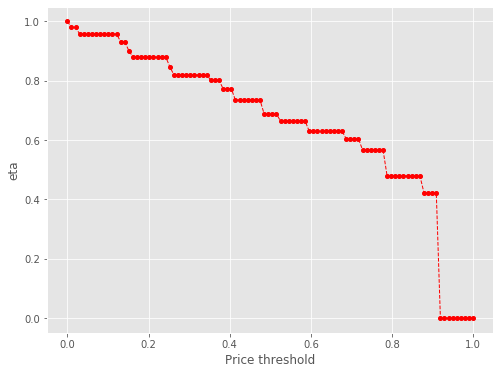

355 18
Number of cells with price above 83.0th percentile:  18


eta =  1.0
eta =  0.9729408211750136
eta =  0.9411517454192857
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.884613353235423
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8374171298784557
eta =  0.8374171298784557
eta =  0.8374171298784557
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
et

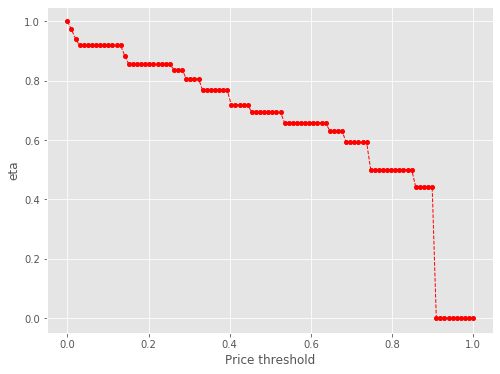

355 18
Number of cells with price above 84.00000000000001th percentile:  18


eta =  1.0
eta =  0.9729408211750136
eta =  0.9411517454192857
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.9190354439545924
eta =  0.884613353235423
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8558213486486469
eta =  0.8374171298784557
eta =  0.8374171298784557
eta =  0.8374171298784557
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.8071002367111365
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
eta =  0.7672638743396751
et

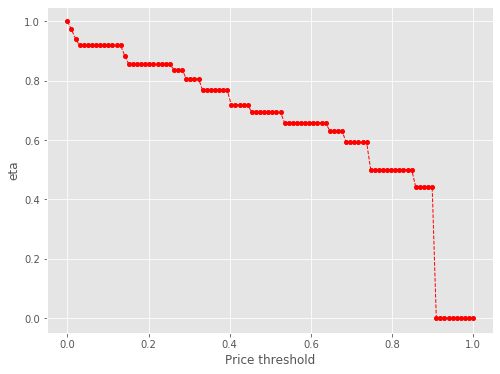

355 15
Number of cells with price above 85.0th percentile:  15


eta =  1.0
eta =  0.9625454154727138
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9111913315062861
eta =  0.9111913315062861
eta =  0.9111913315062861
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7544337423268608
eta =  0.7544337423268608
eta =  0.7544337423268608
e

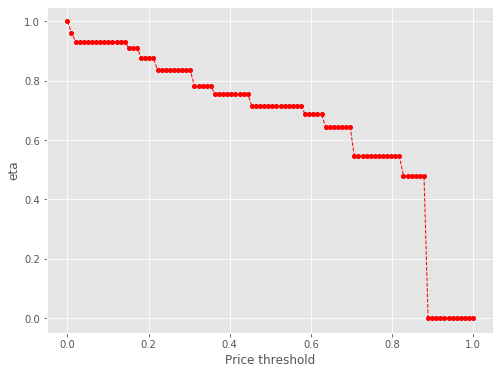

355 15
Number of cells with price above 86.0th percentile:  15


eta =  1.0
eta =  0.9625454154727138
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9312169125556938
eta =  0.9111913315062861
eta =  0.9111913315062861
eta =  0.9111913315062861
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8782036014173723
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.8348577624364008
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7823757327834429
eta =  0.7544337423268608
eta =  0.7544337423268608
eta =  0.7544337423268608
e

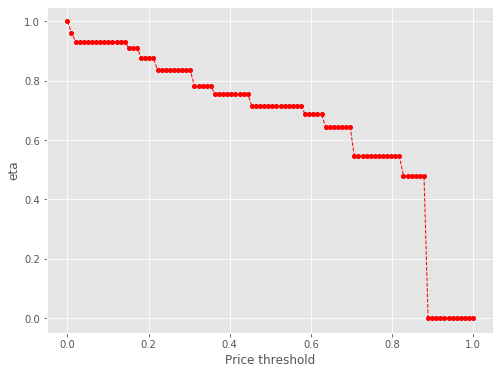

355 13
Number of cells with price above 87.0th percentile:  13


eta =  1.0
eta =  0.9784952562830412
eta =  0.9784952562830412
eta =  0.9784952562830412
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.7689921793255825
eta =  0.7689921793255825
eta =  0.7689921793255825
eta = 

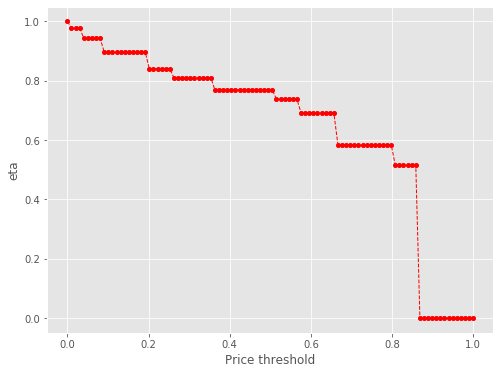

355 13
Number of cells with price above 88.0th percentile:  13


eta =  1.0
eta =  0.9784952562830412
eta =  0.9784952562830412
eta =  0.9784952562830412
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.943070931784488
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8965234105823544
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8401648662460808
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.8101589781658308
eta =  0.7689921793255825
eta =  0.7689921793255825
eta =  0.7689921793255825
eta = 

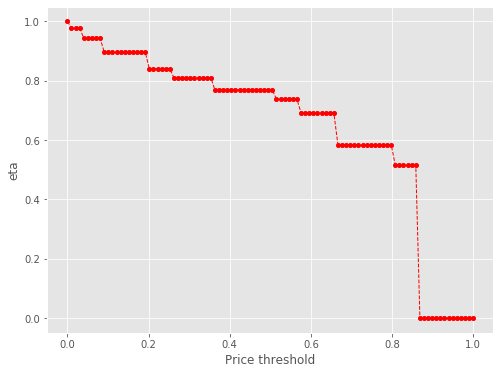

355 11
Number of cells with price above 89.0th percentile:  11


eta =  1.0
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.950642608489633
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.890881945280948
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8590647329494507
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744807011
eta =  0.8154128744

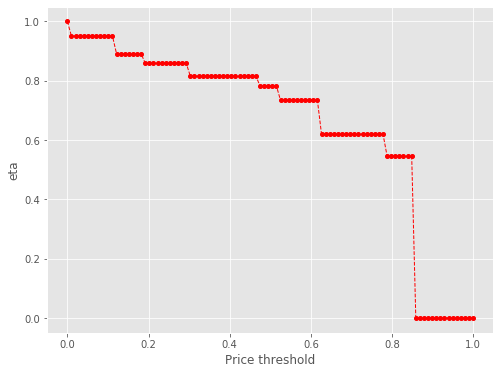

355 10
Number of cells with price above 90.0th percentile:  10


eta =  1.0
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9371365614427573
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.9036673985340508
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
eta =  0.8577491343210643
e

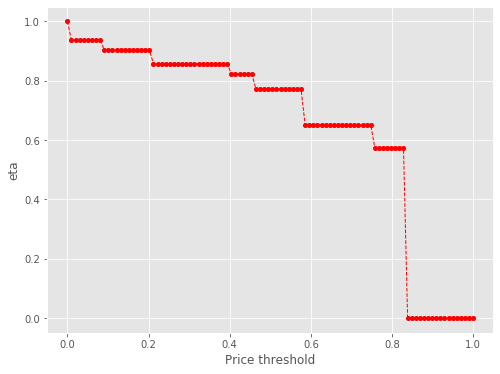

355 9
Number of cells with price above 91.0th percentile:  9


eta =  1.0
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9642857142856752
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.9152872373269985
eta =  0.8784313964456512
eta =  0.8784313964456512
eta =  0.8784313964456512
eta =  0.8784313964456512
e

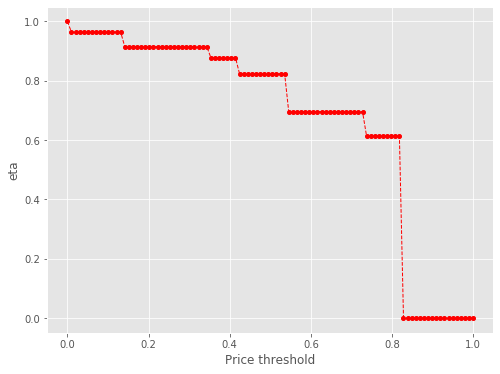

355 8
Number of cells with price above 92.0th percentile:  8


eta =  1.0
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9491867646354443
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.9109658926103419
eta =  0.8544301588611313
eta =  0.8544301588611313
eta =  0.8544301588611313
eta =  0.8544301588611313
eta =  0.8544301588611313
eta =  0.8544301588611313
e

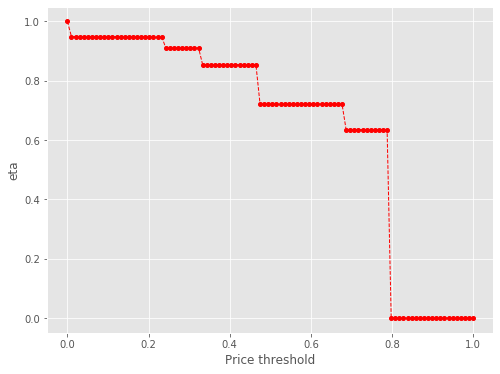

355 7
Number of cells with price above 93.0th percentile:  7


eta =  1.0
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
e

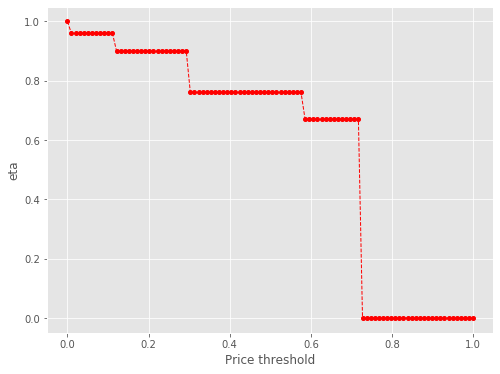

355 7
Number of cells with price above 94.0th percentile:  7


eta =  1.0
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9597330331088404
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.9001707468912018
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
eta =  0.7605027828715811
e

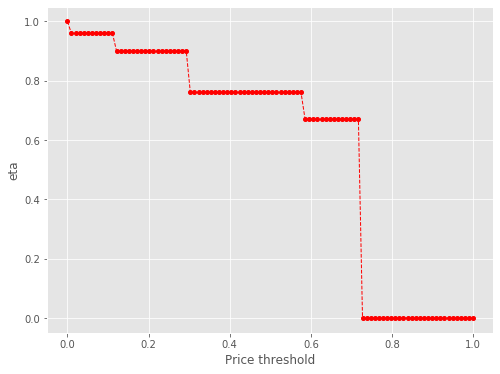

355 5
Number of cells with price above 95.0th percentile:  5


eta =  1.0
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
e

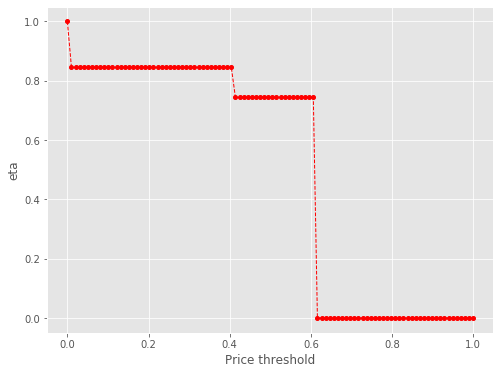

355 5
Number of cells with price above 96.00000000000001th percentile:  5


eta =  1.0
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
eta =  0.8448428095425528
e

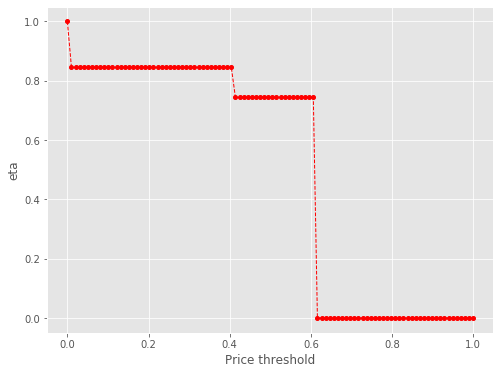

355 3
Number of cells with price above 97.0th percentile:  3


eta =  1.0
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  0.880278869282036
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

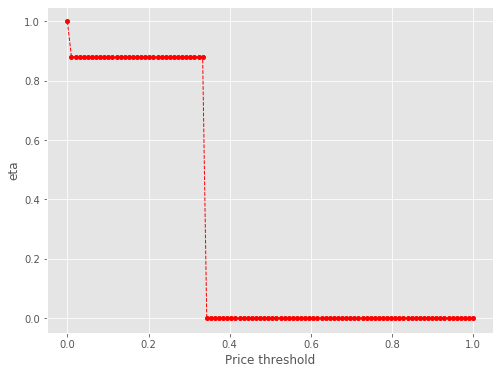

355 2
Number of cells with price above 98.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

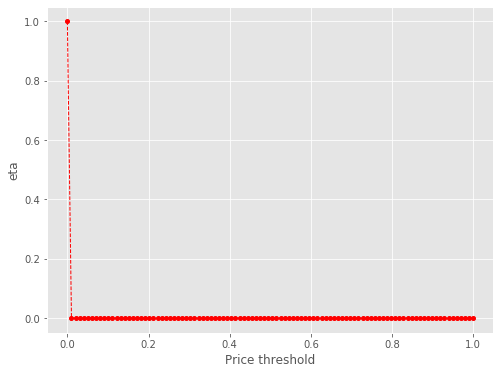

355 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



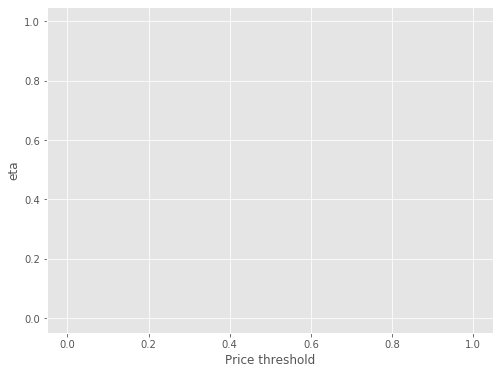

355 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

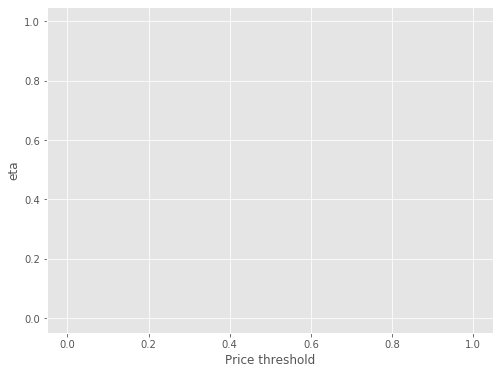


time: 1min 7s


In [29]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

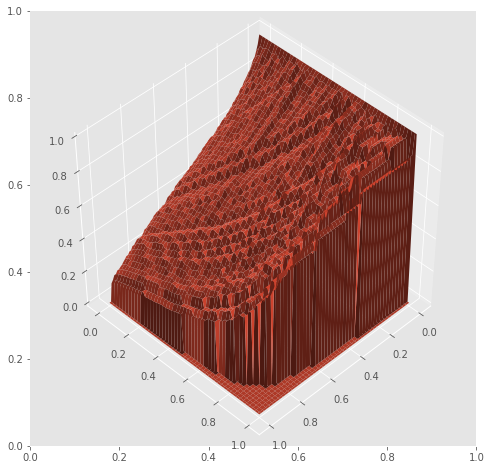

time: 1.12 s


In [30]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [31]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Bordeaux'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 26 ms


355 224
Number of cells with price above 5th percentile:  224
total number of cells:  355
number of cells within urban airbnb territory:  224



Mean travel times in minutes:  13.149932250330687


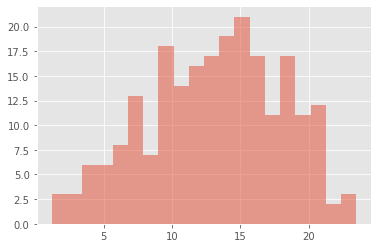

time: 16.8 s


In [32]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.6)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  13.149932250330687


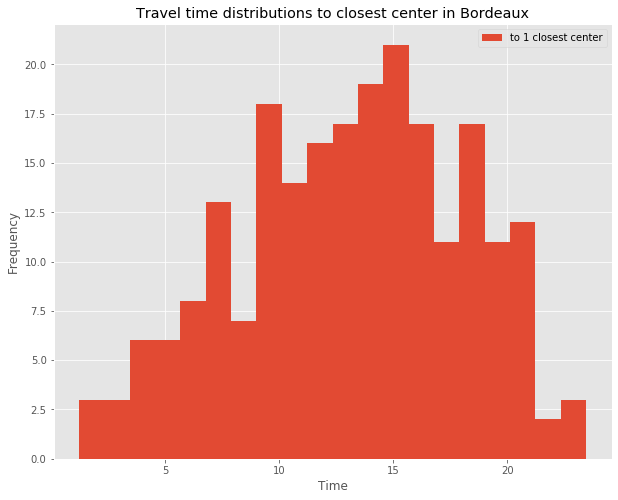

time: 313 ms


In [33]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Bordeaux')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Bordeaux'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 696 ms


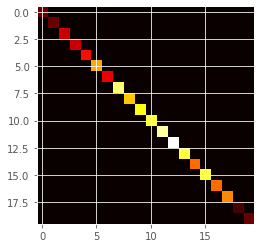

time: 172 ms


In [35]:
x = times_dict['times_{}'.format(1)]
#y = times_dict['times_{}'.format(2)]
#c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xx, cmap='hot', interpolation='nearest')
plt.show()

In [36]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.8372851341384413
average mutual information =  2.8372851341384413
time: 6.98 ms


In [37]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Bordeaux'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 5.98 ms
